# visualization_evaluation.ipynb — Latent coordinates, ROI-wise differences, and FDR selection

**Goal.** This notebook reproduces the *visualization and evaluation* figures from the manuscript that are based on the fitted models: latent coordinate plots for each group and ROI-wise effect summaries with Bayesian FDR.

Specifically, this notebook:

- **Loads fitted models** (MLE and hierarchical NUTS) from the output folders created by  
  `03_h0h1_connectome_real.ipynb` (or from the synthetic connectome run in `toyexample.ipynb`).
- **Constructs latent coordinates** by embedding the estimated edge-wise intensity matrix \(\Lambda\) (e.g., via rank-\(K\) spectral/SVD embedding).
- **Generates latent coordinate panels** for each class/group, matching the manuscript’s latent space figures.
- **Computes ROI-wise latent distance summaries** between selected group pairs, based on posterior draws of $\|z_i^{(p)} - z_i^{(q)}\|_2$.
- **Applies the Bayesian FDR procedure** to select ROIs with strong latent differences and saves:
  - per-ROI summaries (CSV),
  - FDR-selected ROIs,
  - violin plots used in the manuscript.

**Data / output requirements**

- This notebook assumes that the corresponding MLE and HMC runs have already been executed and saved (e.g. under `runs_connectome/...`).
- For readers **without access to the real connectome data**, the same visualization and FDR workflow can be reproduced using the synthetic connectome-like outputs generated by `toyexample.ipynb`.

No raw connectome data are included in this archive; all plots here are derived from model outputs saved by the other notebooks.


# Figrue 7

## Figure 7 (a)

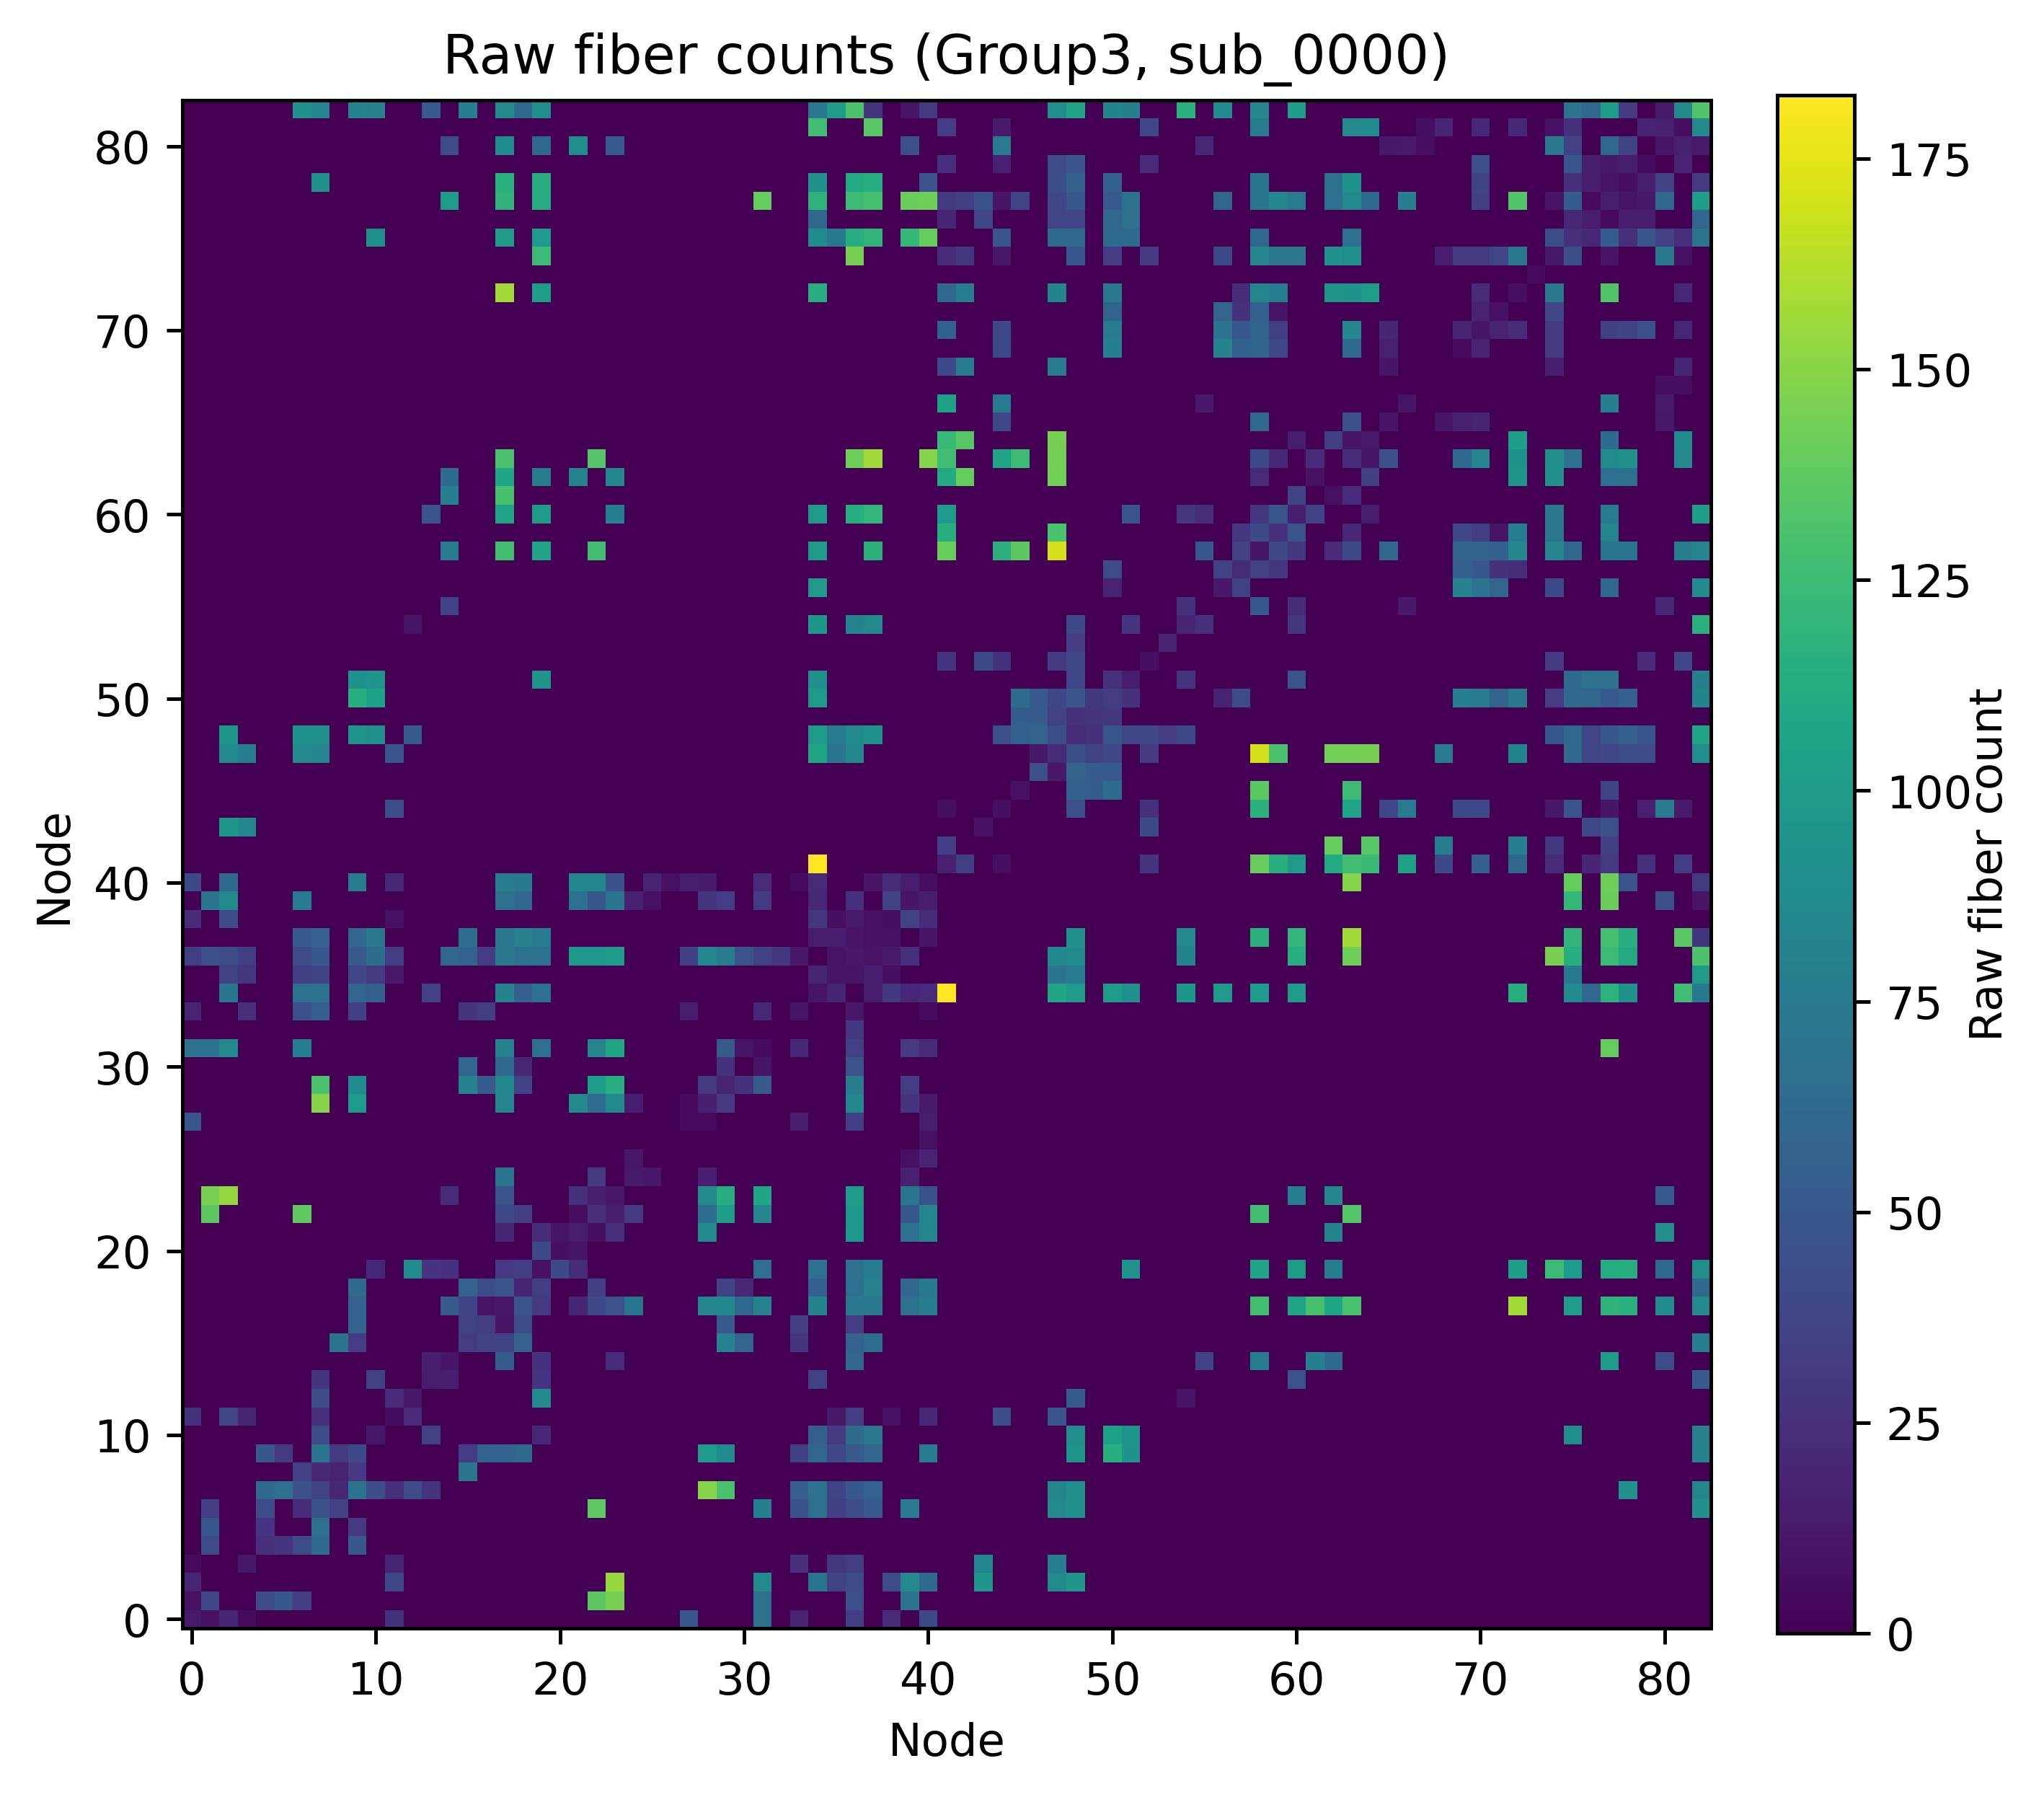

Hemisphere counts: {'L': 41, 'M': 1, 'R': 41, 'U': 0}


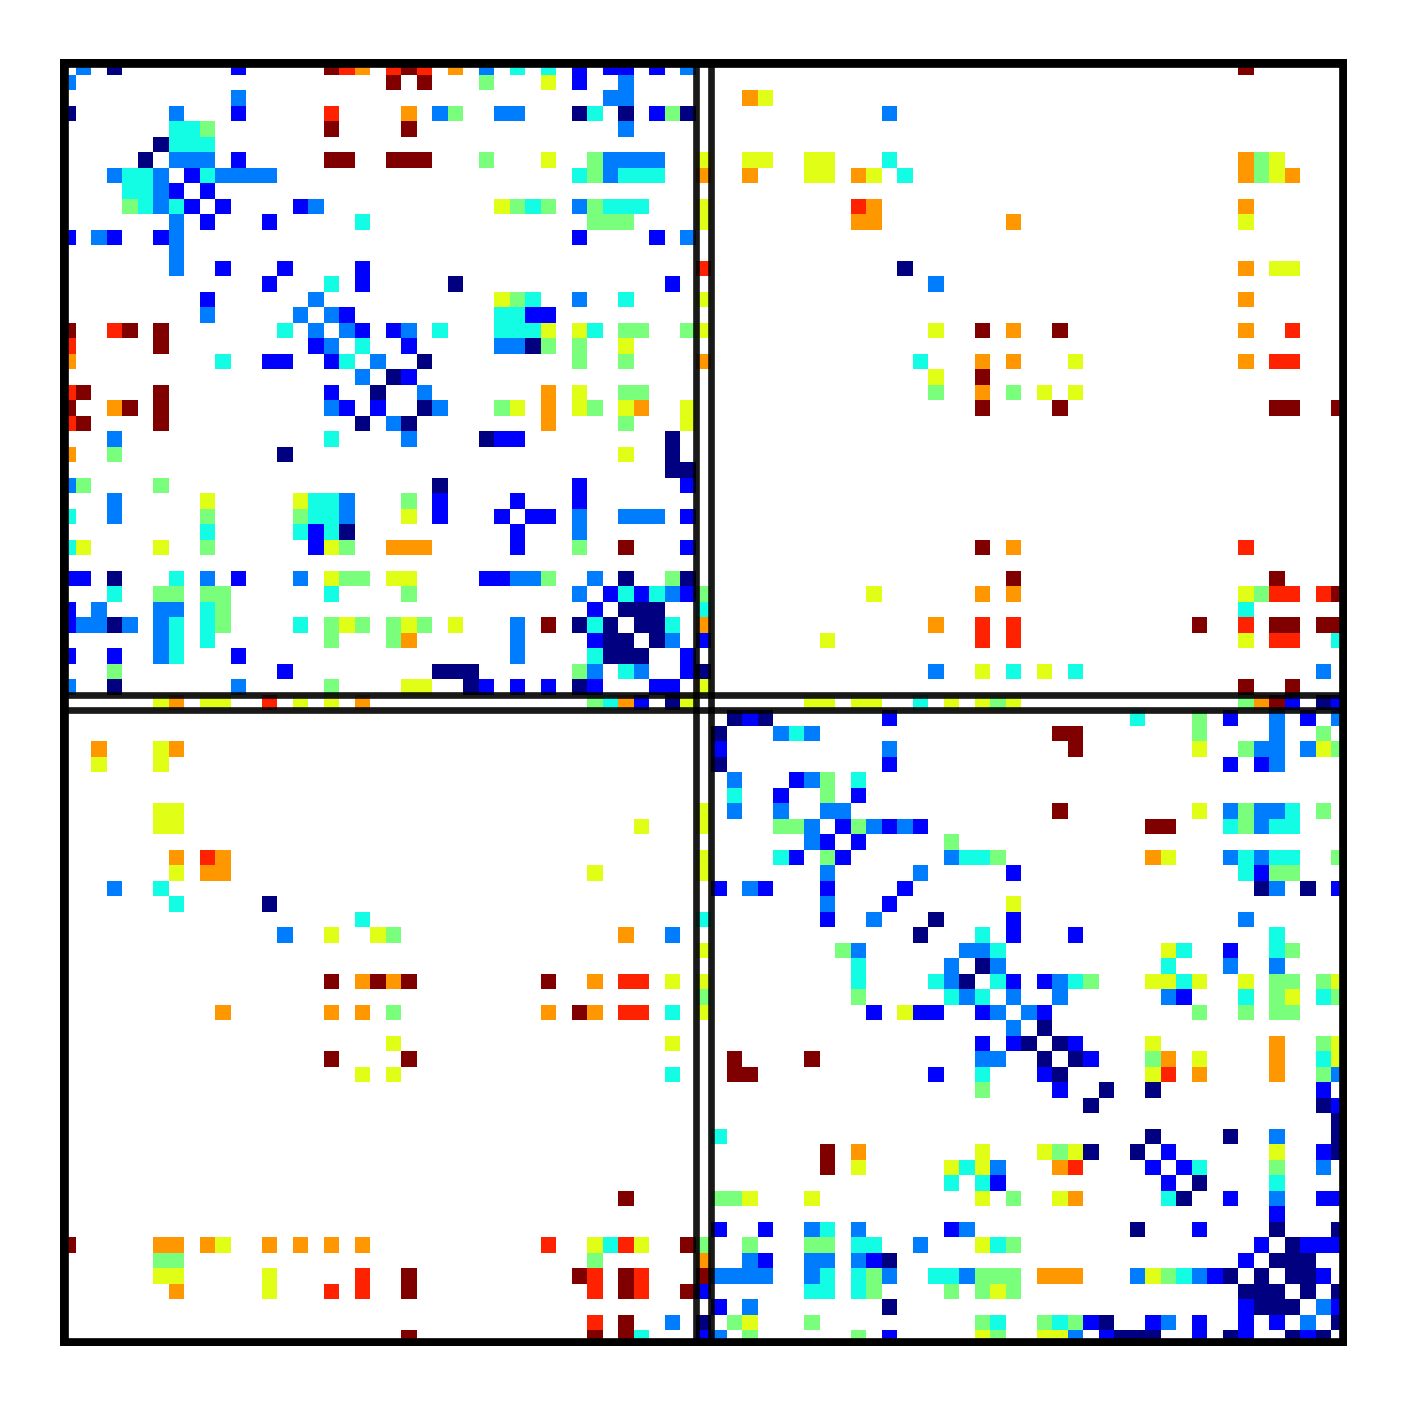

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Connectome utils: load raw fiber-count matrices from .rda, optionally clean,
and plot publication-ready adjacency heatmaps.

Requires:
  - numpy, matplotlib
  - rdata (pip install rdata) if loading from .rda

Files expected:
  - data/connectome_D_v2/index.csv   (with columns: cid,file)
  - data/connectomedata.rda          (with arrays fiblendata/nofibdata, subds, labels/roinames/node_names)

Outputs (example run at bottom):
  - figs/connectivity/heatmap_raw_group3_sub0037.png
  - figs/connectivity/connectome_upper_jet_zeroWhite.png
"""

import csv
import re
from pathlib import Path
from typing import Optional, Tuple, List

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LogNorm
import matplotlib.patches as patches

# Optional: R .rda loader
try:
    import rdata
except Exception:
    rdata = None


# ---------- 1) Load ROI names from CSV ----------
def load_node_names_csv(csv_path: str | Path, column: str = "Region names") -> List[str]:
    """
    Read a single-column CSV with header 'Region names' (one ROI per line).
    Returns a list of ROI names in file order.
    """
    names = []
    with Path(csv_path).open(newline="") as f:
        reader = csv.DictReader(f)
        if column not in reader.fieldnames:
            raise KeyError(f"Column '{column}' not found in {csv_path}. "
                           f"Found: {reader.fieldnames}")
        for row in reader:
            nm = (row[column] or "").strip()
            if nm:
                names.append(nm)
    if not names:
        raise ValueError(f"No ROI names read from {csv_path}")
    return names

# ---------- 2) Infer hemisphere from name ----------
def infer_hemisphere_from_name(name: str) -> str:
    """
    Return 'L', 'R', 'M' (midline), or 'U' (unknown) based on the ROI name.
    Designed for names like 'R amygdala', 'L precentral', 'Brainstem'.
    """
    s = name.strip().lower()
    if s.startswith("l "): return "L"
    if s.startswith("r "): return "R"
    # Midline keywords — customize as needed
    if s in {"brainstem", "brain stem", "ventricle", "3rd ventricle", "fourth ventricle", "vermis"}:
        return "M"
    return "U"

# ---------- 3) Reorder by hemisphere blocks ----------
def reorder_by_hemisphere_blocks(
    W: np.ndarray,
    node_names: List[str],
    *,
    left_first: bool = True,
    keep_unknown_last: bool = True
) -> Tuple[np.ndarray, List[str], List[int], List[int], dict]:
    """
    Permute W into L | M | R | (U) blocks.

    Returns:
      W_ord, names_ord, order_idx, split_positions, counts_dict
        - split_positions are cumulative indices for drawing grid lines.
    """
    n = len(node_names)
    if W.shape != (n, n):
        raise ValueError(f"W shape {W.shape} does not match #ROI names {n}")

    L_idx, R_idx, M_idx, U_idx = [], [], [], []
    for i, nm in enumerate(node_names):
        h = infer_hemisphere_from_name(nm)
        if h == "L": L_idx.append(i)
        elif h == "R": R_idx.append(i)
        elif h == "M": M_idx.append(i)
        else: U_idx.append(i)

    blocks = ([L_idx, M_idx, R_idx] if left_first else [R_idx, M_idx, L_idx])
    if keep_unknown_last and U_idx:
        blocks += [U_idx]
    order = [i for blk in blocks for i in blk]
    # Safety: append any leftovers (shouldn’t happen)
    if len(order) < n:
        order += [i for i in range(n) if i not in order]

    W_ord = W[np.ix_(order, order)]
    names_ord = [node_names[i] for i in order]

    # where to draw split lines (after each non-empty block)
    splits, cum = [], 0
    for blk in ([L_idx] if left_first else [R_idx]):
        if blk: cum += len(blk); splits.append(cum)
    if M_idx:
        cum += len(M_idx); splits.append(cum)
    for blk in ([R_idx] if left_first else [L_idx]):
        if blk: cum += len(blk); splits.append(cum)
    # No split after Unknown (kept last)

    counts = {"L": len(L_idx), "M": len(M_idx), "R": len(R_idx), "U": len(U_idx)}
    return W_ord, names_ord, order, splits, counts

# ---------- 4) (Optional) draw split lines on an existing heatmap axis ----------
def draw_block_splits(ax, splits: List[int], *, lw: float = 0.8, color: str = "black", alpha: float = 0.9):
    """Draw vertical/horizontal lines at block boundaries on a square heatmap."""
    for t in splits:
        ax.axvline(t, lw=lw, color=color, alpha=alpha)
        ax.axhline(t, lw=lw, color=color, alpha=alpha)

# =========================
# I/O: RDA extraction
# =========================
def _extract_arrays_from_rda(rda_path: str | Path) -> Tuple[np.ndarray, np.ndarray, Optional[List[str]]]:
    """
    Load arrays from an R .rda file.

    Returns
    -------
    subds : (S,) int array
        Group labels per subject.
    stack : (S, n, n) float array
        Subject-level adjacency (fiber-count) matrices.
    node_names : list[str] or None
        Optional ROI/node names if present in the .rda.
    """
    if rdata is None:
        raise ImportError("Please `pip install rdata` to load .rda files.")
    converted = rdata.conversion.convert(rdata.parser.parse_file(str(rda_path)))

    if "fiblendata" in converted:
        stack = np.asarray(converted["fiblendata"])
    elif "nofibdata" in converted:
        stack = np.asarray(converted["nofibdata"])
    else:
        raise KeyError("Missing 'fiblendata' or 'nofibdata' in .rda.")

    if "subds" not in converted:
        raise KeyError("Missing 'subds' in .rda.")

    subds = np.asarray(converted["subds"]).astype(int).ravel()

    node_names = None
    for k in ("labels", "roinames", "node_names"):
        if k in converted:
            node_names = list(np.asarray(converted[k]).ravel())
            break

    S, n1, n2 = stack.shape
    if n1 != n2:
        raise ValueError(f"Adjacency must be square; got {n1}x{n2}")
    if len(subds) != S:
        raise ValueError(f"'subds' length {len(subds)} != #subjects {S}")
    return subds, stack, node_names


# =========================
# Cleaning / thresholding
# =========================
def clean_weights(
    W: np.ndarray,
    *,
    sym: str = "avg",                 # 'avg' | 'max' | 'min'
    min_weight: float = 20.0,         # prune raw counts < 20 before transforms
    transform: str = "log1p",         # 'log1p' | None
    rescale: bool = True,
) -> np.ndarray:
    """
    Clean a raw count matrix with symmetrization, pruning, and optional transforms.

    Notes:
      - Pruning is applied to the *input* counts (before any transform).
      - transform='log1p' then optional max-rescaling to [0,1].
    """
    W = np.asarray(W, dtype=float)
    # Replace NaN/Inf, clip negatives, zero diagonal
    W = np.nan_to_num(W, nan=0.0, posinf=0.0, neginf=0.0)
    W[W < 0] = 0.0
    np.fill_diagonal(W, 0.0)

    # Symmetrize
    if sym == "avg":
        W = 0.5 * (W + W.T)
    elif sym == "max":
        W = np.maximum(W, W.T)
    elif sym == "min":
        W = np.minimum(W, W.T)
    else:
        raise ValueError("sym must be 'avg', 'max', or 'min'")

    # Prune weak tracts on raw counts
    if min_weight is not None and min_weight > 0:
        W[W < min_weight] = 0.0

    # Transform (stabilize)
    if transform == "log1p":
        W = np.log1p(W)
    elif transform is None:
        pass
    else:
        raise ValueError("transform must be 'log1p' or None")

    # Rescale to [0, 1]
    if rescale:
        m = W.max()
        if m > 0:
            W = W / m
    return W


# =========================
# Helpers: subject indexing
# =========================
def subject_index_from_indexcsv(base_dir: str | Path, cid: str, k: int) -> int:
    """
    Given the 'index.csv' produced earlier (with cols: cid,file),
    find the k-th subject file for the given class id (cid="Group1/2/3")
    and return the integer subject index parsed from filename 'sub_XXXX.npz'.
    """
    rows = []
    idx_path = Path(base_dir) / "index.csv"
    if not idx_path.exists():
        raise FileNotFoundError(f"Missing index.csv at {idx_path}")

    with idx_path.open() as f:
        r = csv.DictReader(f)
        for row in r:
            if row.get("cid") == cid:
                rows.append(row)

    if not rows:
        raise FileNotFoundError(f"No shards for class {cid} in {idx_path}")

    rows.sort(key=lambda r: r["file"])  # ensure deterministic order
    if k < 0 or k >= len(rows):
        raise IndexError(f"k={k} out of range for cid={cid} with {len(rows)} rows")

    fname = rows[k]["file"]          # e.g., sub_0037.npz
    stem = Path(fname).stem          # 'sub_0037'
    try:
        return int(stem.split("_")[1])
    except Exception as e:
        raise ValueError(f"Cannot parse subject index from filename '{fname}'") from e


def load_raw_W_from_rda_for_subject(rda_path: str | Path, subject_index: int) -> Tuple[np.ndarray, Optional[List[str]]]:
    """Return the raw (untransformed) adjacency matrix and optional node names."""
    _, stack, node_names = _extract_arrays_from_rda(rda_path)
    return np.asarray(stack[subject_index], dtype=float), node_names

import re

# ---------- L/R (±Midline) inference ----------
def infer_hemisphere(name: str) -> str:
    """
    Return 'L', 'R', 'M' (midline), or 'U' (unknown) from an ROI name.
    Heuristics cover common neuro naming styles: L_/R_, lh-/rh-, Left/Right, etc.
    """
    s = name.strip().lower()
    # normalize separators
    s = s.replace('.', ' ').replace('-', ' ').replace('/', ' ').replace('\\', ' ').replace('__', '_')

    # midline-ish (brainstem, vermis, 3rd ventricle, etc.) — tweak as needed
    mid_keywords = ("brainstem", "vermis", "mid", "3rd vent", "third vent", "4th vent", "fourth vent")
    if any(k in s for k in mid_keywords):
        return "M"

    # left
    left_patterns = [
        r'(^|\s)(l|lh|left)(\s|_|$)',   # "L ", "LH-", "Left_"
        r'(_l$)|(\(l\)$)|(\sleft$)',    # "_L", "(L)", " left"
    ]
    if any(re.search(p, s) for p in left_patterns):
        return "L"

    # right
    right_patterns = [
        r'(^|\s)(r|rh|right)(\s|_|$)',  # "R ", "RH-", "Right_"
        r'(_r$)|(\(r\)$)|(\sright$)',   # "_R", "(R)", " right"
    ]
    if any(re.search(p, s) for p in right_patterns):
        return "R"

    return "U"


def reorder_by_hemisphere(
    W: np.ndarray,
    node_names: list[str] | None,
    *,
    left_first: bool = True,
    keep_unknown_last: bool = True,
) -> tuple[np.ndarray, list[str] | None, list[int], list[int], dict]:
    """
    Reorder adjacency by hemisphere groups.
    Returns: W_ord, names_ord, order_idx, split_positions, counts
      - split_positions: [nL, nL+nM, nL+nM+nR] (only present for non-empty groups)
    """
    if node_names is None:
        raise ValueError("node_names is None; cannot infer L/R reordering.")

    n = len(node_names)
    if W.shape != (n, n):
        raise ValueError(f"W shape {W.shape} does not match len(node_names)={n}")

    L_idx, R_idx, M_idx, U_idx = [], [], [], []
    hemi = []
    for i, nm in enumerate(node_names):
        h = infer_hemisphere(nm)
        hemi.append(h)
        (L_idx if h == 'L' else R_idx if h == 'R' else M_idx if h == 'M' else U_idx).append(i)

    # compose order
    if left_first:
        blocks = [L_idx, M_idx, R_idx]
    else:
        blocks = [R_idx, M_idx, L_idx]
    if keep_unknown_last and U_idx:
        blocks = blocks + [U_idx]

    order = [i for block in blocks for i in block]
    if len(order) != n:
        # some ROIs might be duplicated or missing — fall back to appending leftovers
        leftovers = sorted(set(range(n)) - set(order))
        order = order + leftovers

    # apply permutation
    W_ord = W[np.ix_(order, order)]
    names_ord = [node_names[i] for i in order] if node_names is not None else None

    # split line positions
    splits = []
    cum = 0
    counts = {'L': len(L_idx), 'M': len(M_idx), 'R': len(R_idx), 'U': len(U_idx)}
    for block in ([L_idx] if left_first else [R_idx]):
        if block: 
            cum += len(block); splits.append(cum)
    if M_idx:
        cum += len(M_idx); splits.append(cum)
    for block in ([R_idx] if left_first else [L_idx]):
        if block:
            cum += len(block); splits.append(cum)
    # (U at end typically doesn't get a split line)

    return W_ord, names_ord, order, splits, counts



# =========================
# Plotting
# =========================
def plot_raw_connectivity_heatmap(
    W: np.ndarray,
    *,
    title: str | None = None,
    vmin: float | None = 0.0,
    vmax: float | None = None,
    clip_pct: float | None = None,   # e.g., 99.5 for visual cap only
    save_path: str | Path | None = None,
    figsize: Tuple[float, float] = (6.4, 6.0),
    dpi: int = 450,
):
    """
    Plot the *raw* adjacency (fiber counts) with no transforms and no preprocessing.
    Only visualization scaling (vmin/vmax or clip_pct) is applied to the colormap.
    """
    X = np.asarray(W, dtype=float)  # do NOT modify W
    good = np.isfinite(X)
    data_max = X[good].max() if good.any() else 1.0

    if vmax is None:
        if clip_pct is not None and good.any():
            vmax = np.percentile(X[good], clip_pct)
        else:
            vmax = data_max

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    im = ax.imshow(X, origin="lower", interpolation="nearest", vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Raw fiber count", rotation=90, va="center")
    ax.set_xlabel("Node")
    ax.set_ylabel("Node")
    if title:
        ax.set_title(title)
    plt.tight_layout()
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight", dpi=dpi)
    plt.show()
    return fig, ax


def plot_connectome_neuro(
    W: np.ndarray,
    *,
    triangle: str = "upper",        # 'upper' | 'full'
    include_diag: bool = False,     # if triangle='upper', whether to show diagonal
    cmap: str = "jet",              # 'jet', 'viridis', 'cividis', etc.
    quantize: int = 9,              # discrete color steps; 7–11 is common for print
    clip_pct: float | None = 99.5,  # visual-only vmax cap (None uses max)
    log_color: bool = False,        # True if counts span orders of magnitude
    keep_zero_white: bool = True,   # draw zeros as white in the visible region
    show_colorbar: bool = False,    # off for tiny panels
    show_ticks: bool = False,       # keep False for small 83×83 plots
    figsize: Tuple[float, float] = (2.2, 2.2),
    dpi: int = 600,
    border_lw: float = 2.0,
    save_path: str | Path | None = None,
):
    """
    Publication-style connectome heatmap.

    - Standard orientation: top-left → bottom-right diagonal (origin='upper').
    - 'upper' triangle hides the lower triangle (and optionally the diagonal).
    - If keep_zero_white=True, zero entries (that would be visible) render as white.
    """
    A = np.asarray(W, float)
    N = A.shape[0]
    assert A.shape == (N, N), "Adjacency must be square."

    # ----- mask geometry -----
    if triangle == "upper":
        k = -1 if include_diag else 0
        base_mask = np.tri(N, k=k, dtype=bool)  # lower (and maybe diag) hidden
    elif triangle == "full":
        base_mask = np.zeros((N, N), dtype=bool)
    else:
        raise ValueError("triangle must be 'upper' or 'full'")

    Z = np.ma.array(A, mask=base_mask)

    # ----- optionally hide zeros (so they render as 'bad' = white) -----
    if keep_zero_white:
        zero_mask = (~Z.mask) & np.isclose(Z.data, 0.0)
        Z = np.ma.array(Z.data, mask=Z.mask | zero_mask)

    # ----- visual scaling (based on actual values, not Z) -----
    good = np.isfinite(A)
    if not good.any():
        vmin, vmax = 0.0, 1.0
    else:
        vmin = 0.0
        vmax = (np.percentile(A[good], clip_pct)
                if clip_pct is not None else A[good].max())
        if vmax <= 0:
            vmax = 1.0

    if log_color:
        # log scale: choose a safe positive vmin
        pos = A[good & (A > 0)]
        vmin_eff = max(1e-12, pos.min() if pos.size else 1e-12)
        vmax_eff = max(vmax, vmin_eff * (1 + 1e-9))
        norm = LogNorm(vmin=vmin_eff, vmax=vmax_eff)
        levels = None
    else:
        levels = np.linspace(vmin, vmax, quantize + 1)
        norm = BoundaryNorm(levels, ncolors=256)

    # ----- colormap (white for masked/zero if requested) -----
    if isinstance(cmap, str):
        base_cmap = plt.get_cmap(cmap)
    else:
        base_cmap = cmap
    try:
        cmap_obj = base_cmap.copy()
    except AttributeError:
        from copy import copy as _copy
        cmap_obj = _copy(base_cmap)
    if keep_zero_white:
        cmap_obj.set_bad("white")

    # ----- plot -----
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    if levels is None:
        im = ax.imshow(Z, origin="upper", cmap=cmap_obj, norm=norm,
                       interpolation="nearest", aspect="equal")
    else:
        x = np.arange(N + 1)
        y = np.arange(N + 1)
        im = ax.pcolormesh(x, y, Z, cmap=cmap_obj, norm=norm,
                           edgecolors="face", linewidth=0.0, shading="flat")
        im.set_rasterized(True)
        ax.set_xlim(0, N)
        ax.set_ylim(N, 0)  # invert y to match origin='upper'

    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)

    # black border
    ax.add_patch(patches.Rectangle((0, 0), N, N, fill=False,
                                   lw=border_lw, edgecolor="black", zorder=4))

    if show_colorbar:
        cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cb.ax.tick_params(labelsize=6)

    plt.tight_layout(pad=0.2)
    if save_path:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    return fig, ax


# =========================
# Example usage
# =========================
if __name__ == "__main__":
    base_dir = "data/connectome_D_v2"
    rda_path = "data/connectomedata.rda"
    roi_csv = "data/node_labels.csv"
    node_names_csv = load_node_names_csv(roi_csv, column="Region names")

    # Example: pick the k-th subject from Group3 using index.csv
    try:
        sidx = subject_index_from_indexcsv(base_dir, cid="Group3", k=0)
    except Exception as e:
        raise SystemExit(f"Failed to read subject index: {e}")

    # Load raw W (exact counts)
    W_raw, node_names = load_raw_W_from_rda_for_subject(rda_path, subject_index=sidx)

    # -----------------------
    # Plot EXACT raw counts
    # -----------------------
    _ = plot_raw_connectivity_heatmap(
        W_raw,
        title=f"Raw fiber counts (Group3, sub_{sidx:04d})",
        clip_pct=None,  # None = use the true max (no visual capping)
        save_path=f"figs/connectivity/heatmap_raw_group3_sub{sidx:04d}.png",
        figsize=(6.4, 6.0),
        dpi=450,
    )

    # -----------------------
    # (Optional) Clean then plot (upper-triangle, zeros white)
    # -----------------------
    W_clean = clean_weights(
        W_raw,
        sym="avg",
        min_weight=0.0,
        transform=None,
        rescale=True,
    )

    if W_clean.shape[0] != len(node_names_csv):
        raise ValueError(f"#nodes in W ({W_clean.shape[0]}) != #ROI names in CSV ({len(node_names_csv)})")

    # 3) Reorder into L | M | R | U
    W_ord, names_ord, order_idx, split_pos, counts = reorder_by_hemisphere_blocks(
        W_clean, node_names_csv, left_first=True, keep_unknown_last=True
    )
    print("Hemisphere counts:", counts)  # e.g., {'L':40,'M':1,'R':40,'U':0}

    # Plot and draw L/R split lines
    fig, ax = plot_connectome_neuro(
        W_ord,
        triangle="full",
        include_diag=False,
        cmap="jet",
        quantize=9,
        clip_pct=99.5,
        log_color=False,
        keep_zero_white=True,
        show_colorbar=False,
        show_ticks=False,
        figsize=(2.2, 2.2),
        dpi=600,
        save_path="figs/connectivity/connectome_LMR_blocks.png",
    )
    draw_block_splits(ax, split_pos, lw=0.8, color="black", alpha=0.9)
    fig.savefig("figs/connectivity/connectome_LMR_blocks_splits.png", dpi=600, bbox_inches="tight")

    # 5) (optional) save the permutation for reproducibility
    np.savetxt("figs/connectivity/lr_order.csv",
            np.c_[np.arange(len(order_idx)), order_idx],
            fmt="%d", delimiter=",", header="orig_idx,new_idx", comments="")


## Figure 7 (b)

Found 104 subjects across 3 groups.
H0 bars per subject (min/med/max): 83 83.0 83
H1 bars per subject (min/med/max): 8 21.5 33


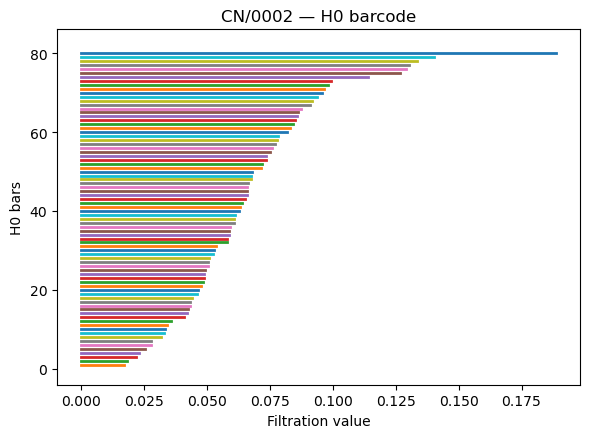

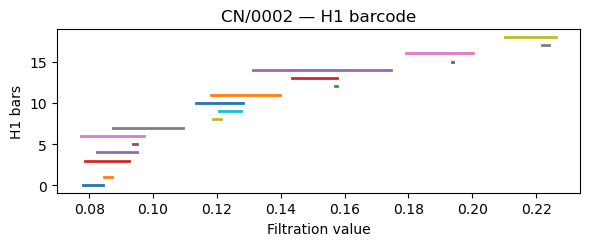

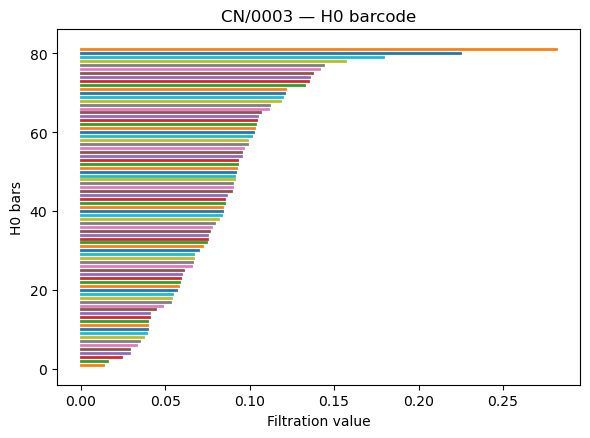

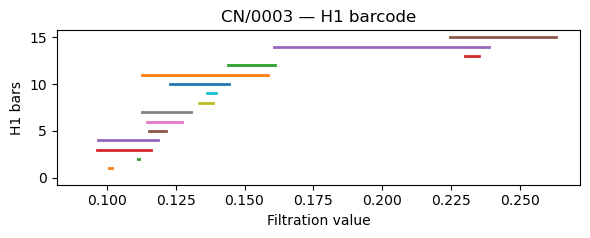

[bottleneck] backend = gudhi.hera
[bottleneck] backend = gudhi.hera


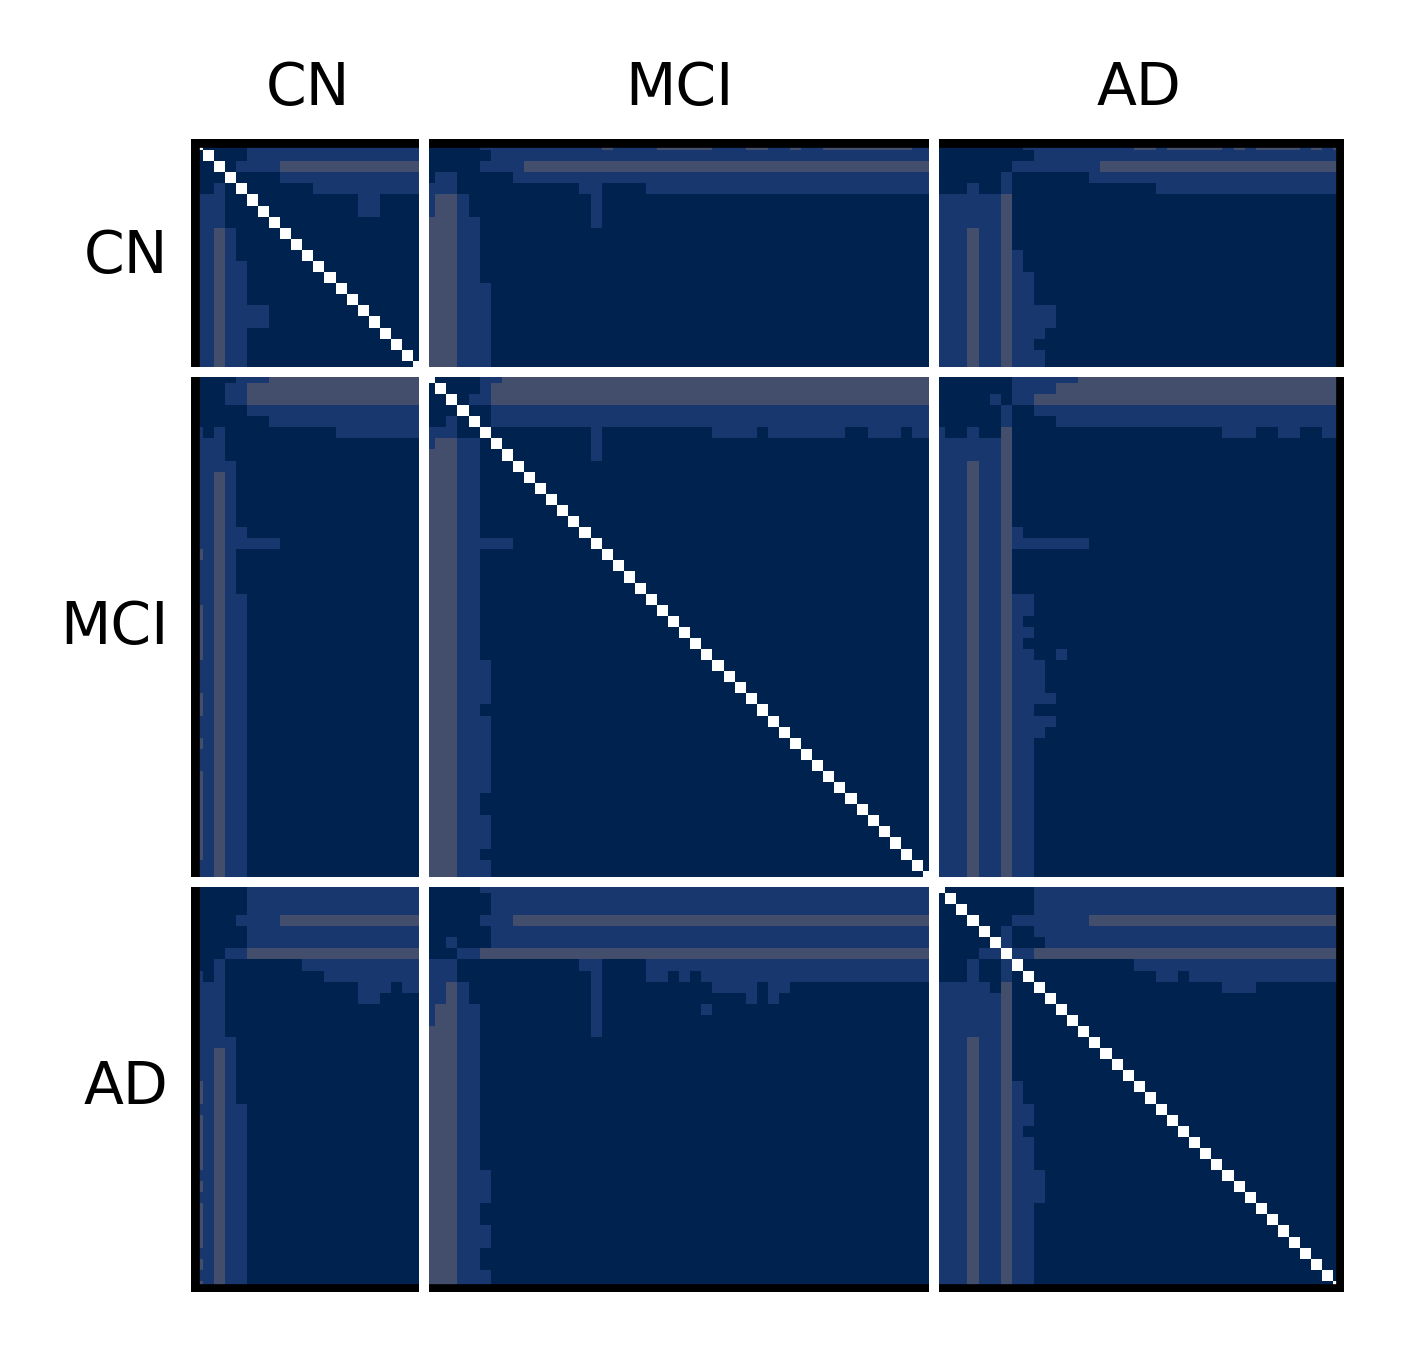

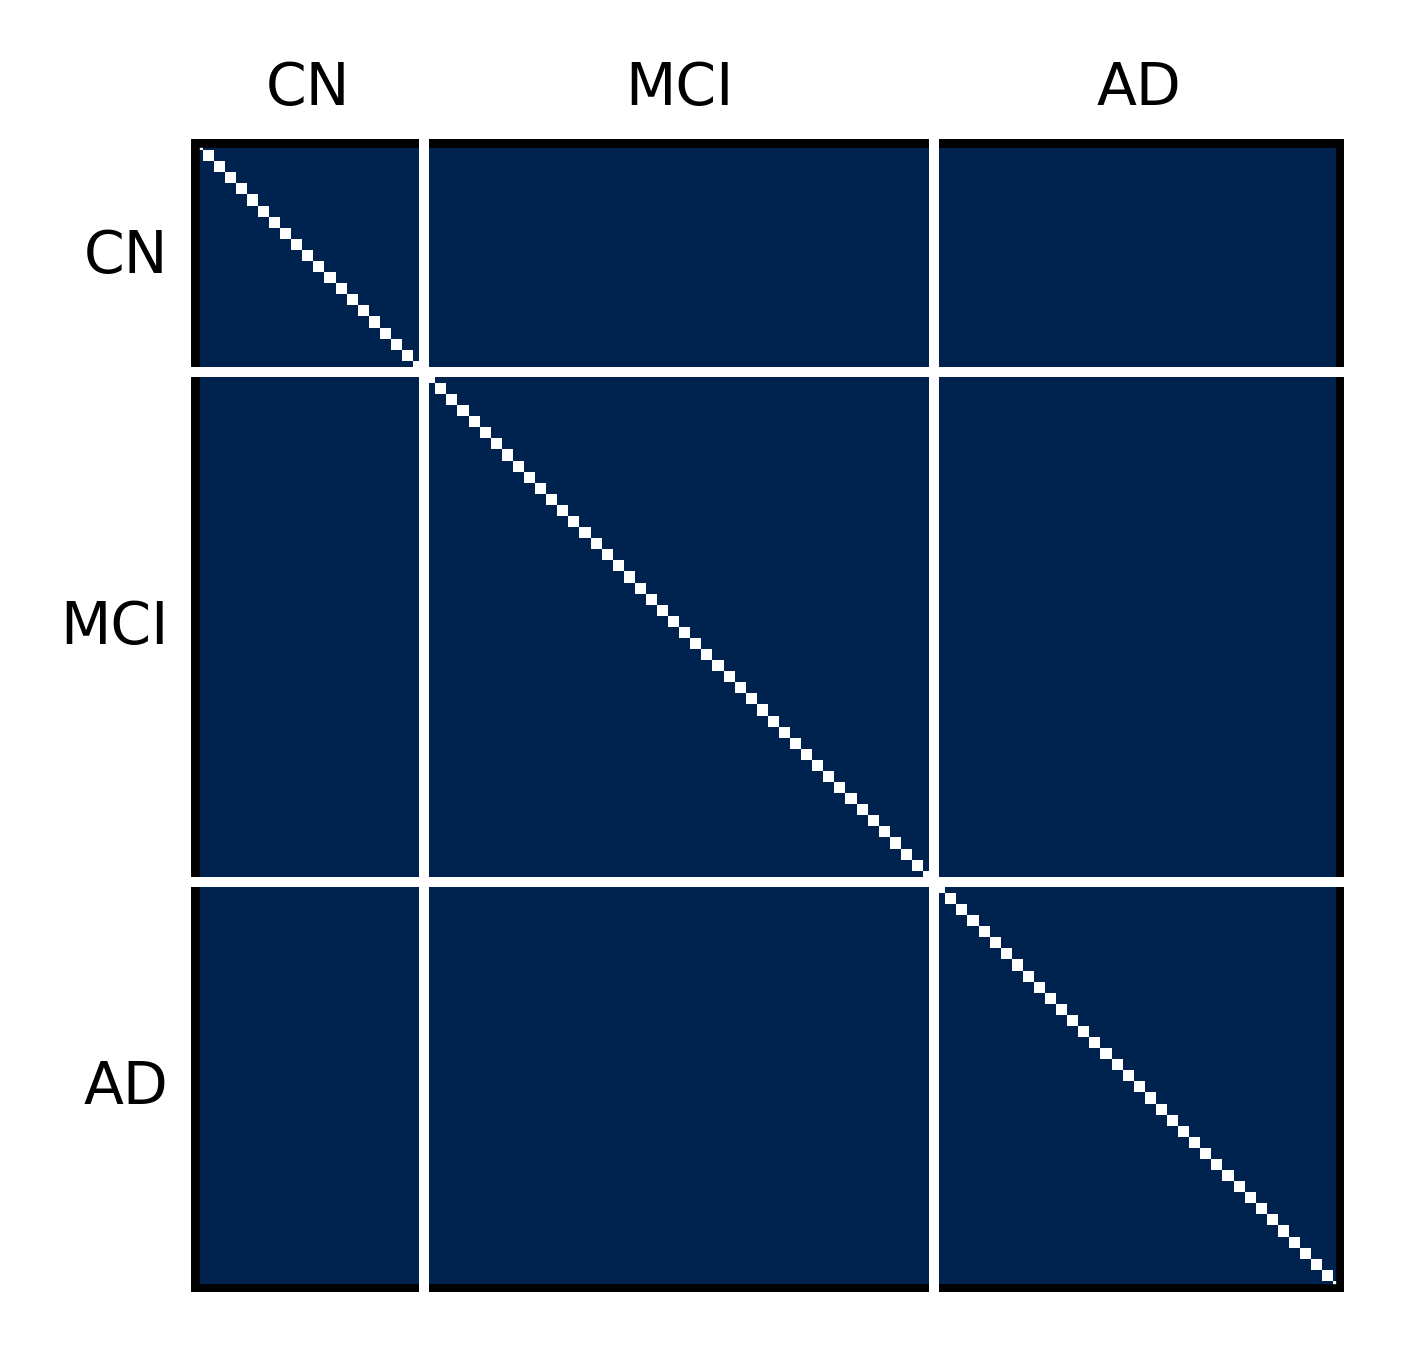

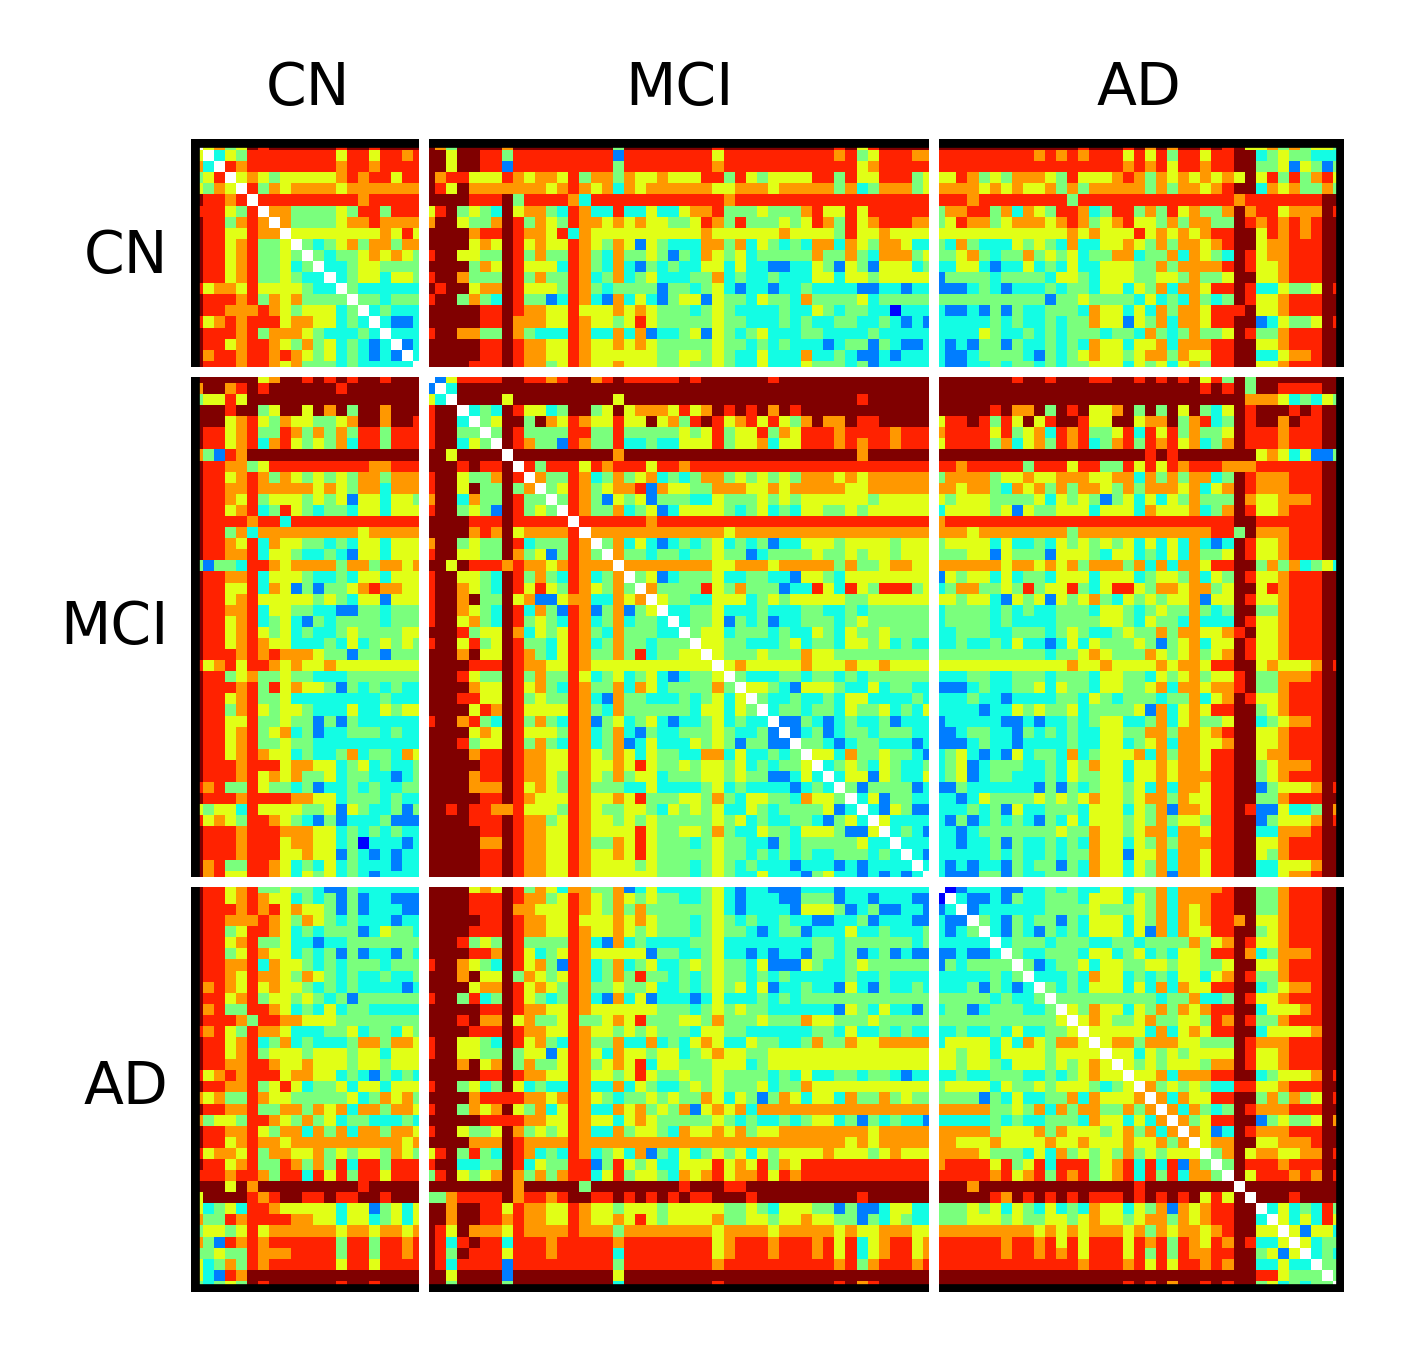

In [37]:
# ============================================================
# Simple VR (GUDHI) on RAW D matrices + H0/H1 barcodes
# + Pairwise bottleneck (H0, H1, H0⊕H1) + Group-guided heatmaps
#
# Expected folder layout:
#   RAW_DIR/
#     Group1/*.npz   (each has array 'D' with zeros on diag, may contain +inf)
#     Group2/*.npz
#     ...
# ============================================================

import os, re, json
from pathlib import Path
from typing import List, Tuple, Optional, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

from gudhi import RipsComplex  # VR complex

# -------------------
# CONFIG
# -------------------
RAW_DIR = "data/connectome_D_v2"
GROUPS: Optional[List[str]] = None     # e.g., ["Group1","Group2","Group3"]; None → auto-detect
MAX_EDGE_QUANTILE = 0.95               # raise (0.98–0.99) if H1 bars are sparse
OUT_DIR = Path("figs/bn")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ============================================================
# Helpers: scanning, ordering
# ============================================================
def _natkey(s: str):
    """Natural sort key: 'sub10' after 'sub2'."""
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r"(\d+)", s)]

def scan_raw_shards(root: str, groups: Optional[List[str]] = None):
    """
    Find all RAW distance .npz files that contain 'D'.

    Returns
    -------
    files : list[Path]
    keys  : list[(group_label, subject_label)]
    """
    root = Path(root)
    if groups is None:
        groups = sorted([d.name for d in root.iterdir() if d.is_dir()])
    files, keys = [], []
    for g in groups:
        gdir = root / g
        if not gdir.exists():
            continue
        for p in sorted(gdir.glob("*.npz"), key=lambda x: _natkey(x.name)):
            try:
                with np.load(p) as z:
                    if "D" in z.files:
                        files.append(p)
                        # subject id: last integer in stem or whole stem
                        m = re.findall(r"(\d+)", p.stem)
                        sid = m[-1] if m else p.stem
                        keys.append((g, sid))
            except Exception:
                continue
    return files, keys

# ============================================================
# Helpers: VR threshold + persistence diagrams
# ============================================================
def choose_threshold(D: np.ndarray, q: float = 0.95) -> float:
    """Choose VR max_edge_length from finite positive entries."""
    X = D[np.isfinite(D)]
    X = X[X > 0]
    if X.size == 0:
        return 0.0
    qv = float(np.quantile(X, q))
    mv = float(X.max())
    if qv <= 0:
        qv = mv
    return max(qv, 1e-12)

def vr_diagram_from_D(
    D_raw: np.ndarray,
    hom_dim: int,
    max_edge_length: Optional[float] = None,
    min_persistence: float = 0.0,
) -> np.ndarray:
    """
    Vietoris–Rips persistence diagram for homology dim `hom_dim` from distance matrix.

    - Non-finite entries are set >> max_edge_length → excluded.
    - max_dimension = hom_dim+1 for hom_dim>=1 (H1 needs triangles).
    """
    D = np.asarray(D_raw, dtype=float).copy()
    n = D.shape[0]
    assert D.shape == (n, n), "D must be square"
    np.fill_diagonal(D, 0.0)

    if max_edge_length is None:
        max_edge_length = choose_threshold(D, q=MAX_EDGE_QUANTILE)

    if not np.all(np.isfinite(D)):
        D[~np.isfinite(D)] = max_edge_length * 1e6

    max_dim = hom_dim + 1 if hom_dim >= 1 else 1
    rc = RipsComplex(distance_matrix=D, max_edge_length=max_edge_length)
    st = rc.create_simplex_tree(max_dimension=max_dim)
    st.persistence(min_persistence=min_persistence)
    arr = st.persistence_intervals_in_dimension(hom_dim)
    return np.asarray(arr, float) if arr is not None else np.empty((0, 2), float)

def plot_barcode(diag: np.ndarray, dim: int, title: str):
    """Simple barcode plot."""
    if diag.size == 0:
        fig, ax = plt.subplots(figsize=(6, 2))
        ax.text(0.5, 0.5, "No bars", ha="center", va="center")
        ax.set_axis_off()
        fig.suptitle(title)
        plt.tight_layout()
        return fig, ax

    diag = np.asarray(diag, float)
    n_bars = diag.shape[0]
    fig_height = 2.0 + 0.03 * n_bars
    fig, ax = plt.subplots(figsize=(6, fig_height))
    for i, (b, d) in enumerate(diag):
        ax.plot([b, d], [i, i], lw=2)
    ax.set_xlabel("Filtration value")
    ax.set_ylabel(f"H{dim} bars")
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax

# ============================================================
# Bottleneck distance backends + utilities
# ============================================================
def _get_bottleneck():
    """
    Prefer gudhi.hera > persim > gudhi.representations.metrics.
    """
    try:
        from gudhi.hera import bottleneck_distance as bn
        return bn, "gudhi.hera"
    except Exception:
        pass
    try:
        from persim import bottleneck as bn
        return bn, "persim"
    except Exception:
        pass
    try:
        from gudhi.representations.metrics import BottleneckDistance
        bd = BottleneckDistance()
        return (lambda a, b: float(bd(a, b))), "gudhi.representations.metrics"
    except Exception:
        pass
    raise ImportError(
        "No bottleneck backend available. Install one of:\n"
        "  pip install persim\n"
        "  or use a GUDHI build with hera/cgal."
    )

def pairwise_bottleneck(diagrams: List[np.ndarray]) -> np.ndarray:
    """Full pairwise bottleneck distance matrix."""
    bn, backend = _get_bottleneck()
    print(f"[bottleneck] backend = {backend}")
    N = len(diagrams)
    B = np.zeros((N, N), float)
    for i in range(N):
        for j in range(i + 1, N):
            d = float(bn(diagrams[i], diagrams[j]))
            B[i, j] = B[j, i] = d
    np.fill_diagonal(B, 0.0)
    return B

def make_finite_h0(diag: np.ndarray) -> np.ndarray:
    """
    Replace infinite deaths in an H0 diagram with a consistent finite cap.
    """
    if diag.size == 0:
        return diag
    d = np.asarray(diag, float).copy()
    finite_deaths = d[np.isfinite(d[:, 1]), 1]
    if finite_deaths.size:
        base = finite_deaths.max()
    else:
        base = d[:, 0].max() if d.size else 1.0
    cap = float(base * 1.01 + 1e-9)
    d[~np.isfinite(d[:, 1]), 1] = cap
    return d

# ============================================================
# Combine H0/H1 metrics (L∞-type fusion)
# ============================================================
def _offdiag(arr: np.ndarray) -> np.ndarray:
    n = arr.shape[0]
    mask = ~np.eye(n, dtype=bool)
    return arr[mask]

def _robust_scale(M: np.ndarray, how: str = "q95") -> float:
    """
    Robust scale for distance matrix using off-diagonals.
    how: "q95" | "median" | "mad"
    """
    x = _offdiag(M)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 1.0
    if how == "median":
        s = float(np.median(x))
    elif how == "mad":
        med = float(np.median(x))
        s = float(np.median(np.abs(x - med))) or 1.0
    else:  # "q95"
        s = float(np.percentile(x, 95))
    return max(s, 1e-12)

def combine_h0h1_max(
    B0: np.ndarray,
    B1: np.ndarray,
    *,
    weights: Tuple[float, float] = (1.0, 1.0),
    scale: Optional[str] = "q95",
) -> np.ndarray:
    """
    L∞ (max) combination of H0/H1 bottleneck distance matrices.

    - Optionally rescales each matrix by a robust statistic
      so they live on comparable ranges.
    """
    assert B0.shape == B1.shape, "B0 and B1 must have same shape"
    B0 = np.asarray(B0, float)
    B1 = np.asarray(B1, float)

    if scale:
        s0 = _robust_scale(B0, how=scale)
        s1 = _robust_scale(B1, how=scale)
        X0 = B0 / s0
        X1 = B1 / s1
    else:
        X0, X1 = B0, B1

    w0, w1 = weights
    B = np.maximum(w0 * X0, w1 * X1)
    np.fill_diagonal(B, 0.0)
    return B

# ============================================================
# Group-guided BN heatmap with zeros as white
# ============================================================
def _spectral_order_block(M: np.ndarray, idx: np.ndarray) -> np.ndarray:
    """
    Within-group ordering via Fiedler vector of normalized Laplacian
    on RBF kernel from distances M[idx, idx].
    """
    if idx.size <= 2:
        return idx
    A = np.asarray(M[np.ix_(idx, idx)], float)
    off = _offdiag(A)
    s = np.median(off[np.isfinite(off)]) if np.isfinite(off).any() else 1.0
    s = max(s, 1e-12)
    S = np.exp(-A / s)
    np.fill_diagonal(S, 0.0)
    d = S.sum(axis=1)
    with np.errstate(divide="ignore"):
        Dm12 = np.diag(1.0 / np.sqrt(np.maximum(d, 1e-12)))
    L = np.eye(S.shape[0]) - Dm12 @ S @ Dm12
    w, V = np.linalg.eigh(L)
    if w.size < 2:
        return idx
    fied = V[:, np.argsort(w)[1]]
    return idx[np.argsort(fied)]

def _robust_vrange(M: np.ndarray, pr=(5, 95)) -> Tuple[float, float]:
    """Robust value range for coloring from off-diagonals."""
    x = _offdiag(M)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0, 1.0
    lo, hi = np.percentile(x, pr)
    if not np.isfinite(lo):
        lo = float(np.nanmin(x))
    if not np.isfinite(hi):
        hi = float(np.nanmax(x))
    if lo == hi:
        hi = lo + 1e-12
    return float(lo), float(hi)

def plot_bn_heatmap_groupguides(
    B: np.ndarray,
    keys: List[Tuple[str, Union[int, str]]],
    *,
    group_order=None,                      # default: order of first appearance
    within_strategy: str = "seriation",    # 'seriation' | 'none'
    cmap: str = "cividis",                 # or 'jet', etc.
    quantize: int = 9,
    vpercentile=(5, 95),
    levels: np.ndarray | None = None,      # shared scale if provided
    mask_diag: bool = True,
    keep_zero_white: bool = True,          # zeros as white
    show_colorbar: bool = False,
    show_ticks: bool = False,
    show_group_labels: bool = True,
    guide_color: str = "white",
    guide_lw: float = 1.2,
    border_lw: float = 2.0,
    figsize=(2.2, 2.2),
    dpi: int = 600,
    title: str | None = None,
    save_path: str | None = None,
):
    """
    Group-blocked BN heatmap:
    - reorder by group with optional within-group seriation
    - full-length group guides
    - diagonal + zeros masked → plotted as white (if keep_zero_white)
    """
    B = np.asarray(B, float)
    N = B.shape[0]
    assert B.shape == (N, N)
    assert len(keys) == N, "keys length must match B size"

    labels = [cid for (cid, _) in keys]

    # group order: first-seen by default
    if group_order is None:
        group_order = []
        for g in labels:
            if not group_order or group_order[-1] != g:
                group_order.append(g)

    # indices per group
    per_group = {
        g: np.array([i for i, (cid, _) in enumerate(keys) if cid == g], dtype=int)
        for g in group_order
    }

    # concatenated ordering
    order_parts = []
    for g in group_order:
        idx = per_group[g]
        if within_strategy == "seriation" and idx.size > 2:
            idx = _spectral_order_block(B, idx)
        order_parts.append(idx)
    order = np.concatenate(order_parts) if order_parts else np.arange(N)

    # reorder B and keys
    BB = B[np.ix_(order, order)]
    kperm = [keys[i] for i in order]

    # group counts & cuts after permutation
    counts = []
    for g in group_order:
        c = sum(1 for (cid, _) in kperm if cid == g)
        if c > 0:
            counts.append(c)
    cuts = np.cumsum(counts)[:-1] if counts else []

    # masked matrix
    M = np.ma.array(BB, copy=True)
    if mask_diag:
        M[np.eye(N, dtype=bool)] = np.ma.masked

    # mask zeros (after diag mask)
    if keep_zero_white:
        zero_mask = (~M.mask) & np.isclose(M.data, 0.0)
        M = np.ma.array(M.data, mask=M.mask | zero_mask)

    # color levels
    if levels is None:
        vmin, vmax = _robust_vrange(BB, vpercentile)
        levels = np.linspace(vmin, vmax, quantize + 1)
    norm = mcolors.BoundaryNorm(levels, ncolors=256)

    # colormap with white for masked
    if isinstance(cmap, str):
        base_cmap = plt.get_cmap(cmap)
    else:
        base_cmap = cmap
    try:
        cmap_obj = base_cmap.copy()
    except AttributeError:
        from copy import copy as _copy
        cmap_obj = _copy(base_cmap)
    if keep_zero_white:
        cmap_obj.set_bad("white")

    # figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x = np.arange(N + 1)
    y = np.arange(N + 1)
    pc = ax.pcolormesh(
        x, y, M,
        cmap=cmap_obj,
        norm=norm,
        edgecolors="face",
        linewidth=0.0,
        shading="flat",
    )
    pc.set_rasterized(True)
    ax.set_xlim(0, N)
    ax.set_ylim(N, 0)
    ax.set_aspect("equal", adjustable="box")

    # clean axes
    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)

    # border
    ax.add_patch(patches.Rectangle(
        (0, 0), N, N,
        fill=False,
        lw=border_lw,
        edgecolor="black",
        zorder=4,
    ))

    # group guides
    for c in cuts:
        ax.hlines(c, 0, N, colors=guide_color, lw=guide_lw, zorder=5)
        ax.vlines(c, 0, N, colors=guide_color, lw=guide_lw, zorder=5)

    # group labels
    if show_group_labels and counts:
        starts = np.r_[0, np.cumsum(counts[:-1])]
        mids = starts + np.array(counts) / 2.0
        # only non-empty groups in order
        nonempty = [g for g, c in zip(group_order, counts) if c > 0]
        for g, mid in zip(nonempty, mids):
            ax.text(
                -0.02, mid, g,
                va="center", ha="right",
                transform=ax.get_yaxis_transform(),
                fontsize=7,
            )
            ax.text(
                mid, 1.02, g,
                va="bottom", ha="center",
                transform=ax.get_xaxis_transform(),
                fontsize=7,
            )

    if title:
        ax.set_title(title, fontsize=8)

    if show_colorbar:
        cb = fig.colorbar(pc, ax=ax, fraction=0.046, pad=0.04)
        cb.ax.tick_params(labelsize=6)

    plt.tight_layout(pad=0.25)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")

    return fig, ax, order, levels

def make_global_levels(
    mats: List[np.ndarray],
    quantize: int = 9,
    pr=(5, 95),
) -> np.ndarray:
    """
    Shared color levels across multiple BN matrices using robust ranges.
    """
    vmins, vmaxs = [], []
    for M in mats:
        lo, hi = _robust_vrange(M, pr)
        vmins.append(lo)
        vmaxs.append(hi)
    vmin = float(min(vmins))
    vmax = float(max(vmaxs))
    if vmin >= vmax:
        vmax = vmin + 1e-12
    return np.linspace(vmin, vmax, quantize + 1)

# ============================================================
# MAIN PIPELINE
# ============================================================
if __name__ == "__main__":
    # 1) Scan raw D shards
    files, keys = scan_raw_shards(RAW_DIR, GROUPS)
    assert files, f"No raw 'D' matrices found under {RAW_DIR}"
    print(f"Found {len(files)} subjects across {len(set([g for g,_ in keys]))} groups.")

    RENAME = {"Group1": "CN", "Group2": "MCI", "Group3": "AD"}
    keys = [(RENAME.get(g, g), sid) for (g, sid) in keys]

    # 2) Build H0/H1 diagrams
    diags0: List[np.ndarray] = []
    diags1: List[np.ndarray] = []
    for p in files:
        with np.load(p) as z:
            D = np.asarray(z["D"], dtype=float)
        mel = choose_threshold(D, q=MAX_EDGE_QUANTILE)
        d0 = vr_diagram_from_D(D, hom_dim=0, max_edge_length=mel, min_persistence=0.0)
        d1 = vr_diagram_from_D(D, hom_dim=1, max_edge_length=mel, min_persistence=0.0)
        # retry with higher threshold if H1 empty
        if d1.size == 0 and MAX_EDGE_QUANTILE < 0.99:
            mel2 = choose_threshold(D, q=0.99)
            d1 = vr_diagram_from_D(D, hom_dim=1, max_edge_length=mel2, min_persistence=0.0)
        diags0.append(d0)
        diags1.append(d1)

    # 3) Quick stats
    h0lens = [d.shape[0] for d in diags0]
    h1lens = [d.shape[0] for d in diags1]
    if h0lens:
        print("H0 bars per subject (min/med/max):",
              min(h0lens), float(np.median(h0lens)), max(h0lens))
    if h1lens:
        print("H1 bars per subject (min/med/max):",
              min(h1lens), float(np.median(h1lens)), max(h1lens))

    # 4) Example barcodes for first two subjects
    for i in range(min(2, len(files))):
        cid, sid = keys[i]
        plot_barcode(diags0[i], 0, f"{cid}/{sid} — H0 barcode")
        plot_barcode(diags1[i], 1, f"{cid}/{sid} — H1 barcode")
    plt.show()

    # 5) Pairwise bottleneck matrices
    B1 = pairwise_bottleneck(diags1)
    diags0_finite = [make_finite_h0(d) for d in diags0]
    B0 = pairwise_bottleneck(diags0_finite)

    # sanity
    assert B0.shape == B1.shape == (len(keys), len(keys))
    assert np.allclose(B0, B0.T), "B0 not symmetric"
    assert np.allclose(B1, B1.T), "B1 not symmetric"

    # 6) L∞ fusion of H0 & H1
    Bmax = combine_h0h1_max(B0, B1, weights=(1.0, 1.0), scale="q95")

    # 7) Shared color levels
    global_levels = make_global_levels([B0, B1, Bmax], quantize=9, pr=(5, 95))

    # 8) Group-guided heatmaps (zeros white)
    fig0, ax0, _, _ = plot_bn_heatmap_groupguides(
        B0, keys,
        group_order=["CN", "MCI", "AD"],
        within_strategy="seriation",
        cmap="cividis",
        quantize=9,
        levels=global_levels,
        mask_diag=True,
        keep_zero_white=True,
        show_colorbar=False,
        guide_color="white",
        guide_lw=1.2,
        figsize=(2.2, 2.2),
        dpi=600,
        title=None,
        save_path=OUT_DIR / "bn_H0_small.png",
    )

    fig1, ax1, _, _ = plot_bn_heatmap_groupguides(
        B1, keys,
        group_order=["CN", "MCI", "AD"],
        within_strategy="seriation",
        cmap="cividis",
        quantize=9,
        levels=global_levels,
        mask_diag=True,
        keep_zero_white=True,
        show_colorbar=False,
        guide_color="white",
        guide_lw=1.2,
        figsize=(2.2, 2.2),
        dpi=600,
        title=None,
        save_path=OUT_DIR / "bn_H1_small.png",
    )

    # combined: use jet; zeros still white
    figC, axC, _, _ = plot_bn_heatmap_groupguides(
        Bmax, keys,
        group_order=["CN", "MCI", "AD"],
        within_strategy="seriation",
        cmap="jet",
        quantize=9,
        levels=global_levels,
        mask_diag=True,
        keep_zero_white=True,
        show_colorbar=False,
        guide_color="white",
        guide_lw=1.2,
        figsize=(2.2, 2.2),
        dpi=600,
        title=None,
        save_path=OUT_DIR / "bn_H0H1max_small.png",
    )

    plt.show()


## Figure 7(c)

In [42]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def knn_loocv_precomputed(B: np.ndarray, y: np.ndarray, k: int = 5, weights: str = "uniform"):
    """
    LOOCV for KNN with a precomputed distance matrix B (N x N).
    """
    B = np.asarray(B, float)
    y = np.asarray(y)
    N = B.shape[0]
    assert B.shape == (N, N), "B must be square"
    yhat = np.empty(N, dtype=y.dtype)

    loo = LeaveOneOut()
    for train_idx, test_idx in loo.split(B):
        B_train = B[np.ix_(train_idx, train_idx)]
        B_test  = B[np.ix_(test_idx, train_idx)]   # shape (1, N-1)
        k_eff = min(k, len(train_idx))
        clf = KNeighborsClassifier(n_neighbors=k_eff, metric="precomputed", weights=weights, n_jobs=-1)
        clf.fit(B_train, y[train_idx])
        yhat[test_idx[0]] = clf.predict(B_test)[0]

    classes = np.unique(y)
    C = confusion_matrix(y, yhat, labels=classes)
    acc = accuracy_score(y, yhat)
    report = classification_report(y, yhat, labels=classes, digits=3)
    return yhat, acc, C, classes, report

# ---- labels from your keys ----
y = np.array([cid for cid, _ in keys])


In [43]:
cands = range(1,20)
best = (None, -1.0)
for kk in cands:
    _, acc_k, _, _, _ = knn_loocv_precomputed(Bmax, y, k=kk, weights="uniform")
    if acc_k > best[1]:
        best = (kk, acc_k)
print(f"Best k (grid {cands}): k={best[0]}, LOOCV acc={best[1]:.3f}")


Best k (grid range(1, 20)): k=4, LOOCV acc=0.481


In [45]:
# ---- run ----
k = 4
yhat, acc, C, classes, report = knn_loocv_precomputed(Bmax, y, k=k, weights="uniform")
print(f"LOOCV accuracy (k={k}): {acc:.3f}")
print("Classes:", classes.tolist())
print("Confusion matrix (rows=true, cols=pred):\n", C)
print("\nClassification report:\n", report)

LOOCV accuracy (k=4): 0.481
Classes: ['Group1', 'Group2', 'Group3']
Confusion matrix (rows=true, cols=pred):
 [[ 6 14  1]
 [ 5 34  7]
 [ 8 19 10]]

Classification report:
               precision    recall  f1-score   support

      Group1      0.316     0.286     0.300        21
      Group2      0.507     0.739     0.602        46
      Group3      0.556     0.270     0.364        37

    accuracy                          0.481       104
   macro avg      0.460     0.432     0.422       104
weighted avg      0.486     0.481     0.456       104



### Save confusion

In [46]:
import csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def save_confusion_from_predictions(
    y: np.ndarray,
    yhat: np.ndarray,
    out_png: Path,
    out_csv: Path,
    classes: list[str] | None = None,   # if None, use sorted unique from y
):
    """
    Save confusion (rows=true, cols=pred) as CSV + heatmap PNG.
    Returns (C, classes, acc), mirroring your previous helper.
    """
    y = np.asarray(y)
    yhat = np.asarray(yhat)
    if classes is None:
        classes = sorted(list(np.unique(y)))
    class_to_idx = {c:i for i,c in enumerate(classes)}
    K = len(classes)

    # build counts
    C = np.zeros((K, K), dtype=int)
    for t, p in zip(y, yhat):
        ti = class_to_idx[str(t)]
        pi = class_to_idx[str(p)]
        C[ti, pi] += 1

    # save CSV (same header style as before)
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    with out_csv.open("w", newline="") as f:
        w = csv.writer(f); w.writerow([""] + classes)
        for i,c in enumerate(classes):
            w.writerow([c] + list(map(int, C[i])))

    # plot heatmap (same look/labels)
    fig, ax = plt.subplots(figsize=(6.5, 5.5))
    im = ax.imshow(C, aspect='auto', interpolation='nearest')
    ax.set_xticks(range(K)); ax.set_yticks(range(K))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    for i in range(K):
        for j in range(K):
            ax.text(j, i, str(C[i, j]), ha='center', va='center')
    ax.set_xlabel(r"$\mathrm{Predicted}$")
    ax.set_ylabel(r"$\mathrm{True}$")
    fig.tight_layout()

    out_png.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_png, dpi=450, bbox_inches="tight")
    plt.close(fig)

    acc = (np.trace(C) / np.sum(C)) if np.sum(C) > 0 else float("nan")
    return C, classes, acc


In [47]:
C, classes, acc_final = save_confusion_from_predictions(
    y, yhat,
    out_png=Path("figs/knn/loocv_confusion.png"),
    out_csv=Path("figs/knn/loocv_confusion.csv"),
)
print("Final LOOCV accuracy:", acc_final)

Final LOOCV accuracy: 0.4807692307692308


In [42]:
import csv
import numpy as np
from pathlib import Path

# ---- Load confusion CSV saved by your helper ----
def load_confusion_csv(csv_path: Path):
    with csv_path.open(newline="") as f:
        rows = list(csv.reader(f))
    classes = [c.strip() for c in rows[0][1:]]           # header (col labels)
    row_labels, data = [], []
    for r in rows[1:]:
        if not r: 
            continue
        row_labels.append(r[0].strip())                  # row label (true class)
        data.append([int(x) for x in r[1:1+len(classes)]])
    C = np.asarray(data, dtype=int)

    # If row label order doesn't match header order, align the rows
    if row_labels != classes:
        idx = {lbl:i for i, lbl in enumerate(row_labels)}
        C = C[[idx[c] for c in classes], :]
    return C, classes

# ---- Accuracies from confusion ----
def overall_accuracy(C: np.ndarray) -> float:
    total = C.sum()
    return float(np.trace(C) / total) if total > 0 else float("nan")

def collapse_binary_accuracy(C: np.ndarray, classes, normal_labels=("Group1",)):
    """Collapse K×K to 2×2 (Normal vs Diseased) and return accuracy."""
    classes = [str(c) for c in classes]
    normal = set(map(str, normal_labels))
    idx_norm = [i for i, c in enumerate(classes) if c in normal]
    idx_dis  = [i for i, c in enumerate(classes) if c not in normal]
    if not idx_norm or not idx_dis:
        raise ValueError("normal_labels not found in classes, or they cover all classes.")

    # rows=true, cols=pred
    Cnn = C[np.ix_(idx_norm, idx_norm)].sum()
    Cnd = C[np.ix_(idx_norm, idx_dis)].sum()
    Cdn = C[np.ix_(idx_dis,  idx_norm)].sum()
    Cdd = C[np.ix_(idx_dis,  idx_dis)].sum()
    Cbin = np.array([[Cnn, Cnd], [Cdn, Cdd]], dtype=int)
    acc2 = (Cnn + Cdd) / Cbin.sum() if Cbin.sum() > 0 else float("nan")
    return Cbin, ["Normal", "Diseased"], float(acc2)

# ---- Use it on your saved confusion ----
csv_path = Path("figs/knn/loocv_confusion.csv")   # your saved file
C, classes = load_confusion_csv(csv_path)

acc3 = overall_accuracy(C)
_, _, acc2 = collapse_binary_accuracy(C, classes, normal_labels=("Group1",))  # Group1=Normal

print(f"3-class accuracy: {acc3*100:.1f}%")
print(f"Normal vs Diseased accuracy: {acc2*100:.1f}%")


3-class accuracy: 48.1%
Normal vs Diseased accuracy: 73.1%


## Plot the confusion matrix

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib.patches as patches

def plot_confusion_matrix_crisp(
    C: np.ndarray,
    classes,
    *,
    normalize: str | None = "row",   # None | 'row' | 'col' | 'all'
    annotate: str = "counts",        # 'counts' | 'percent' | 'both' | 'none'
    cmap: str = "Blues",             # good: 'Blues', 'cividis', 'viridis'
    quantize: int | None = 7,        # discrete steps; None = smooth
    figsize=(2.2, 2.0),              # good for ~0.33\textwidth
    dpi: int = 600,
    fontsize: int = 8,               # axis labels
    tick_fontsize: int = 7,
    value_fontsize: int = 7,
    rotation: int = 0,
    show_colorbar: bool = False,
    save_path: str | None = None,
):
    C = np.asarray(C)
    K = C.shape[0]
    assert C.shape == (K, K) and len(classes) == K

    X = C.astype(float)
    fmt_percent = False
    if normalize is None:
        M = X
        vmin, vmax = 0, np.nanmax(M) if M.size else 1.0
    elif normalize == "row":
        s = X.sum(axis=1, keepdims=True)
        M = np.divide(X, np.maximum(s, 1), where=s > 0)
        fmt_percent, vmin, vmax = True, 0.0, 1.0
    elif normalize == "col":
        s = X.sum(axis=0, keepdims=True)
        M = np.divide(X, np.maximum(s, 1), where=s > 0)
        fmt_percent, vmin, vmax = True, 0.0, 1.0
    elif normalize == "all":
        tot = X.sum()
        M = X / tot if tot > 0 else X
        fmt_percent, vmin, vmax = True, 0.0, 1.0
    else:
        raise ValueError

    # Values to color
    Z = M if normalize else X

    # Coordinates for pcolormesh cell boundaries (0..K)
    x = np.arange(K + 1)
    y = np.arange(K + 1)

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    # Discrete palette (clearer in print)
    if quantize and quantize > 1:
        levels = np.linspace(vmin, vmax, quantize + 1)
        norm = BoundaryNorm(levels, ncolors=256)
        im = ax.pcolormesh(x, y, Z, cmap=cmap, norm=norm,
                           edgecolors="white", linewidth=1.0, shading="flat")
    else:
        im = ax.pcolormesh(x, y, Z, cmap=cmap, vmin=vmin, vmax=vmax,
                           edgecolors="white", linewidth=1.0, shading="flat")

    # Rasterize color layer (keeps text/vector crisp in PDFs)
    im.set_rasterized(True)

    # Ticks at cell centers
    ax.set_xticks(np.arange(K) + 0.5)
    ax.set_xticklabels(classes, fontsize=tick_fontsize, rotation=rotation, ha="center")
    ax.set_yticks(np.arange(K) + 0.5)
    ax.set_yticklabels(classes, fontsize=tick_fontsize)
    ax.set_xlabel("Predicted label", fontsize=fontsize)
    ax.set_ylabel("True label", fontsize=fontsize)

    # Invert y so row 0 is at the top (like imshow)
    ax.set_xlim(0, K); ax.set_ylim(K, 0)
    ax.set_aspect("equal")

    # Remove axis spines (prevents double borders)
    for s in ax.spines.values():
        s.set_visible(False)

    # Add ONE clean outer border
    ax.add_patch(patches.Rectangle((0, 0), K, K, fill=False, lw=2.0,
                                   edgecolor="black", zorder=4))
    for i in range(len(classes)):
        ax.add_patch(patches.Rectangle((i, i), 1, 1, fill=False, lw=1.4,
                                       edgecolor="black", zorder=5))
    # Annotations (counts/percent/both)
    if annotate.lower() != "none":
        # use normalized values for contrast threshold if available
        contrast_bg = M if normalize else (X / X.max() if X.max() > 0 else X)
        t = 0.6 * (np.nanmax(contrast_bg) if contrast_bg.size else 1.0)
        for i in range(K):
            for j in range(K):
                parts = []
                if annotate in ("counts", "both"):
                    parts.append(f"{int(C[i, j])}")
                if annotate in ("percent", "both") and fmt_percent:
                    parts.append(f"{M[i, j]*100:.0f}")
                if parts:
                    val = contrast_bg[i, j]
                    color = "white" if val >= t else "black"
                    ax.text(j + 0.5, i + 0.5, "\n".join(parts),
                            ha="center", va="center", fontsize=value_fontsize, color=color)

    # Optional colorbar (off by default for small width)
    if show_colorbar:
        cb = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cb.ax.tick_params(labelsize=max(6, tick_fontsize - 1))

    plt.tight_layout(pad=0.5)
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
    return fig, ax


In [47]:
csv_path = Path("figs/knn/loocv_confusion.csv")   # your saved file
C, classes = load_confusion_csv(csv_path)

acc3 = overall_accuracy(C)
_, _, acc2 = collapse_binary_accuracy(C, classes, normal_labels=("Group1",))  # Group1=Normal

print(f"3-class accuracy: {acc3*100:.1f}%")
print(f"Normal vs Diseased accuracy: {acc2*100:.1f}%")

3-class accuracy: 48.1%
Normal vs Diseased accuracy: 73.1%


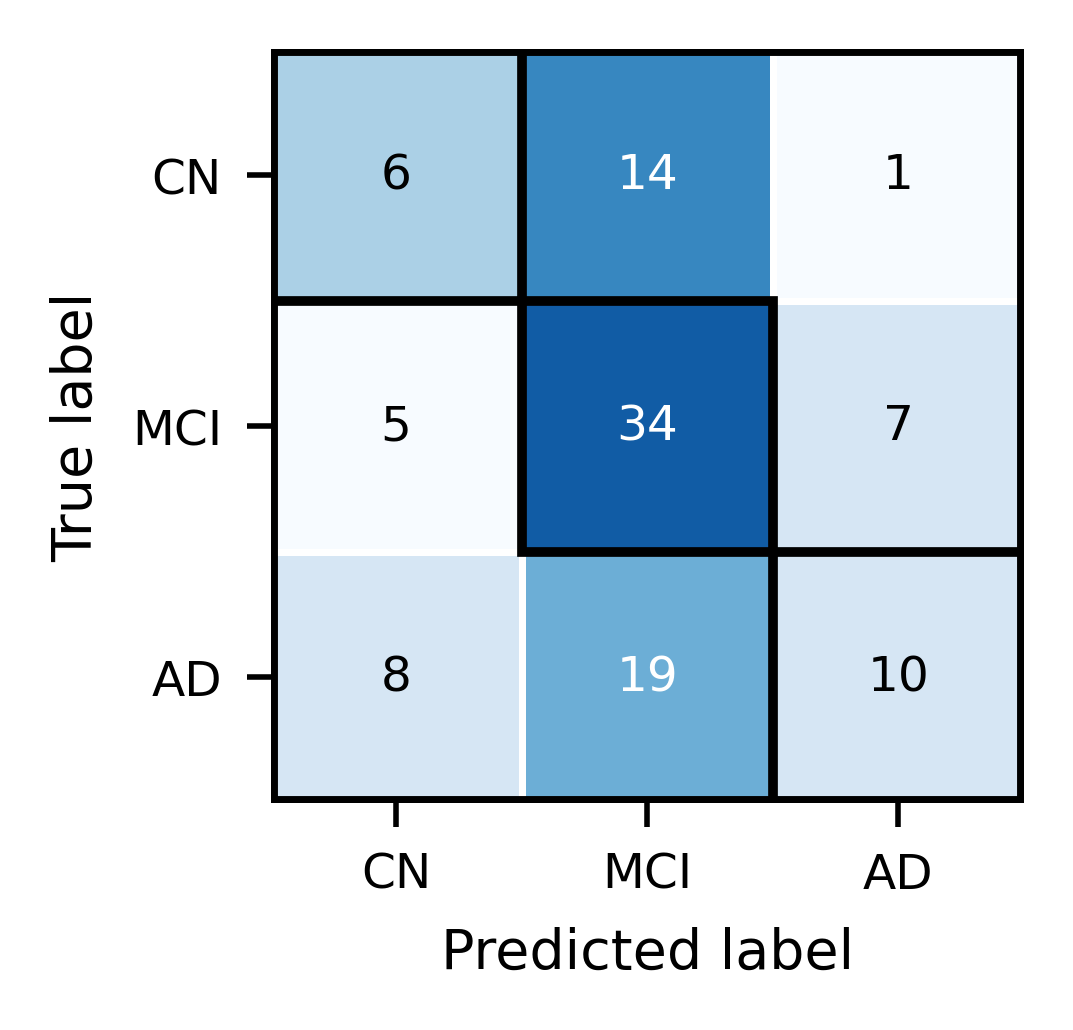

In [48]:
RENAME = {"Group1":"CN", "Group2":"MCI", "Group3":"AD"}
classes_disp = [RENAME.get(c, c) for c in classes]

fig, ax = plot_confusion_matrix_crisp(
    C, classes_disp,
    normalize="row",
    annotate="counts",          # counts only (omit %)
    cmap="Blues", quantize=7,
    figsize=(2.2, 2.0), dpi=500,
    fontsize=8, tick_fontsize=7, value_fontsize=7,
    rotation=0,
    show_colorbar=False,
    save_path="figs/knn/loocv_confusion.png",   # vector text; or .png
)


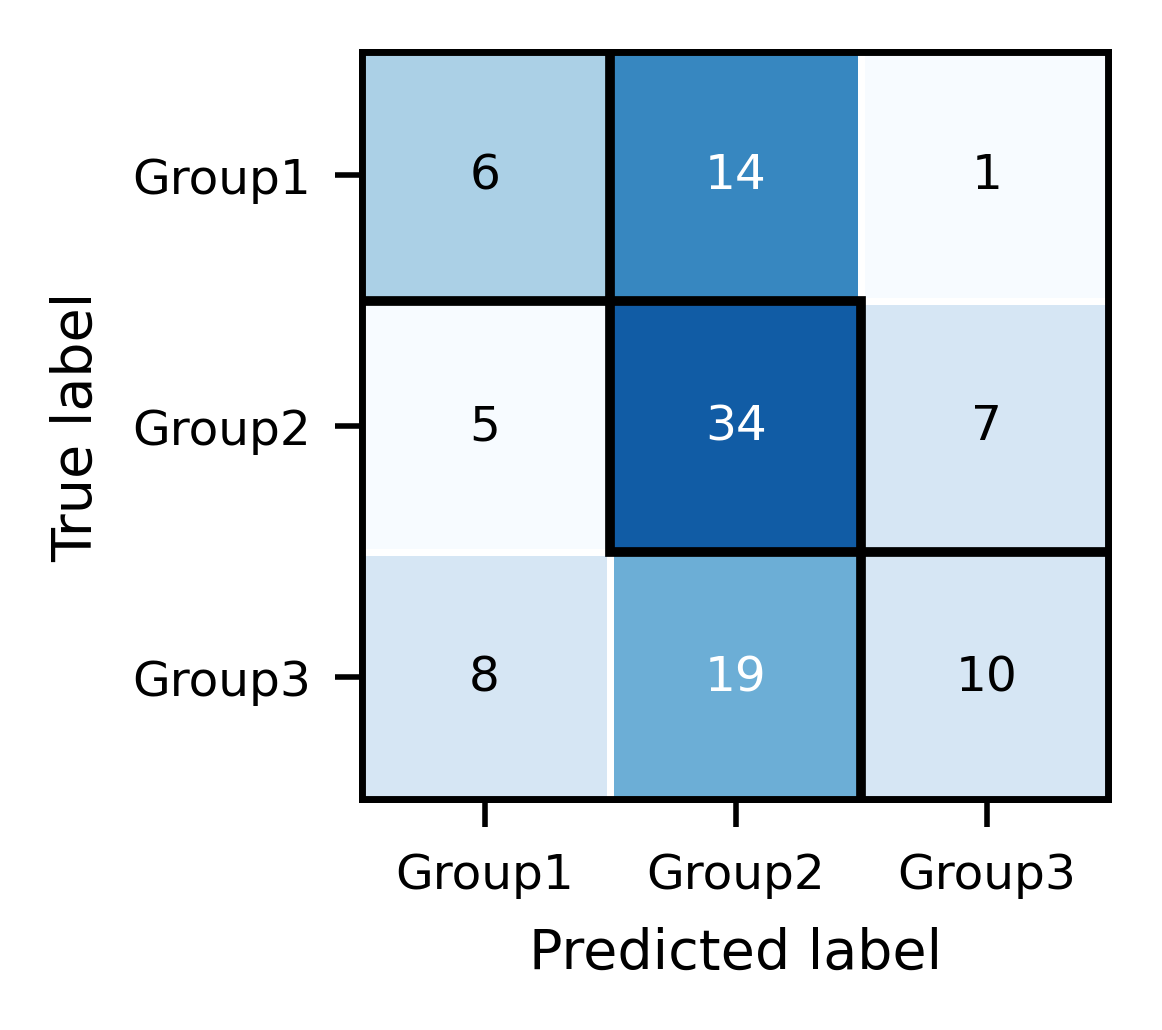

In [105]:
fig, ax = plot_confusion_matrix_crisp(
    C, classes,
    normalize="row",
    annotate="counts",          # counts only (omit %)
    cmap="Blues", quantize=7,
    figsize=(2.2, 2.0), dpi=500,
    fontsize=8, tick_fontsize=7, value_fontsize=7,
    rotation=0,
    show_colorbar=False,
    save_path="figs/knn/loocv_confusion.png",   # vector text; or .png
)


# Figure 8

In [49]:
csv_path = Path("runs_connectome/h01_fit_hmc_v2p2/confusion.csv")   # your saved file
C, classes = load_confusion_csv(csv_path)

acc3 = overall_accuracy(C)
_, _, acc2 = collapse_binary_accuracy(C, classes, normal_labels=("Group1",))  # Group1=Normal

print(f"3-class accuracy: {acc3*100:.1f}%")
print(f"Normal vs Diseased accuracy: {acc2*100:.1f}%")

3-class accuracy: 76.9%
Normal vs Diseased accuracy: 86.5%


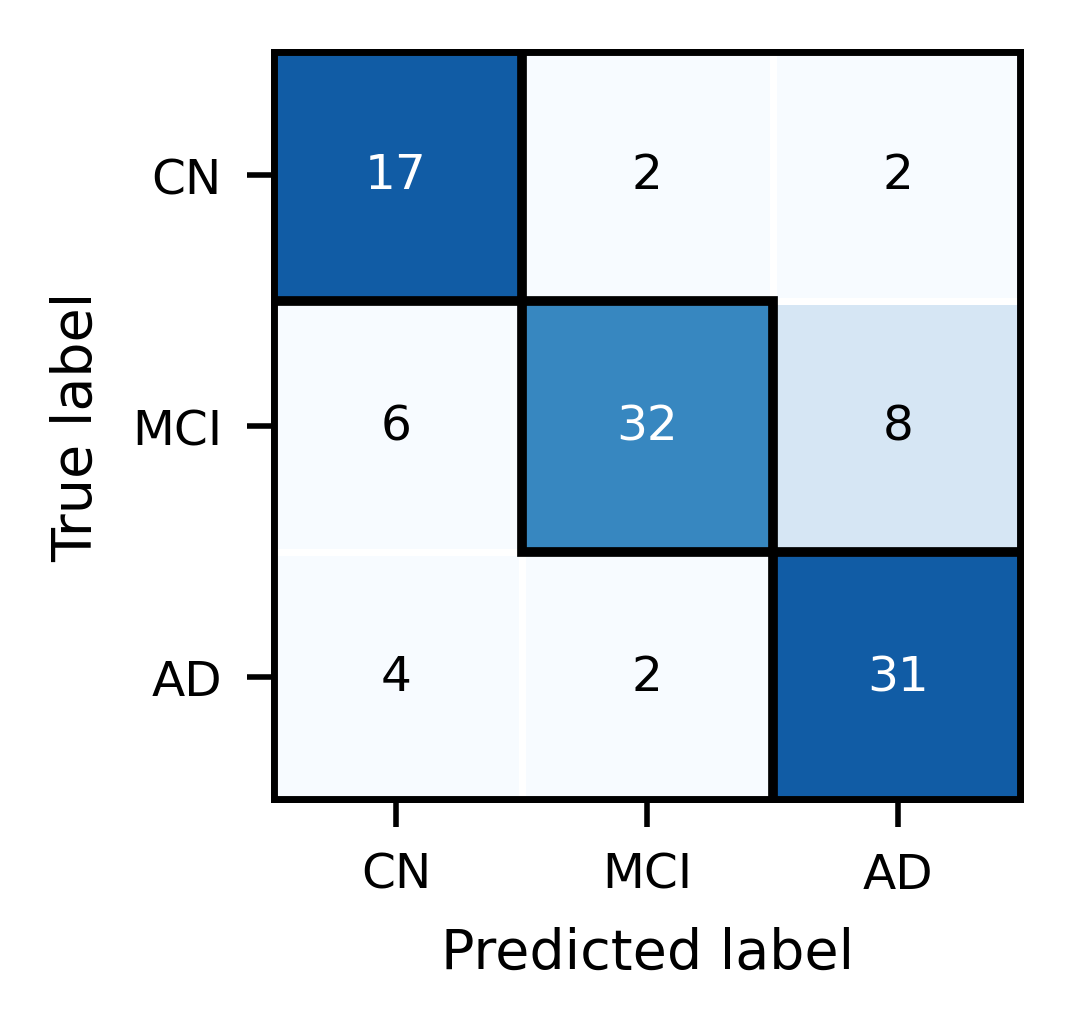

In [50]:
RENAME = {"Group1":"CN", "Group2":"MCI", "Group3":"AD"}
classes_disp = [RENAME.get(c, c) for c in classes]

fig, ax = plot_confusion_matrix_crisp(
    C, classes_disp,
    normalize="row",
    annotate="counts",          # counts only (omit %)
    cmap="Blues", quantize=7,
    figsize=(2.2, 2.0), dpi=500,
    fontsize=8, tick_fontsize=7, value_fontsize=7,
    rotation=0,
    show_colorbar=False,
    save_path="runs_connectome/h01_fit_hmc_v2p2/latest_confusion.png",   # vector text; or .png
)


## Figure 8(b,c,d)

In [25]:
# ==========================================
# Latent coords panels (blue points, looser limits)
# - Square panels with axis ticks/labels
# - Optional shared limits across groups
# - EXPAND controls how much bigger x/y ranges are
# ==========================================

from pathlib import Path
from typing import Dict, Optional, Tuple, List
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
RUN_DIR           = Path("runs_connectome/h01_fit_hmc_v2p2")   # your run folder
GROUPS            = ["Group1", "Group2", "Group3"]             # which subfolders to plot
ALIGN_TO: Optional[str] = "Group2"                             # None to skip alignment
OUT_DIR           = Path("figs/latent_coords")                 # output root
PANEL_SIZE_IN     = 2.4                                        # inches (square)
DPI               = 600
POINT_SIZE        = 8
POINT_COLOR       = "tab:blue"                                 # <-- blue points
USE_SHARED_LIMITS = True                                       # same axes for all panels
EXPAND            = 1.15                                       # <-- make xlim/ylim bigger (1.25 = +25%)

# ---------- helpers ----------
def svd_rank2_coords(L: np.ndarray) -> np.ndarray:
    """Symmetrize, SVD, take top-2, clamp negatives, return Z in R^{n x 2}."""
    Ls = 0.5 * (L + L.T)
    U, S, _ = np.linalg.svd(Ls, full_matrices=False)
    s2 = np.maximum(S[:2], 0.0)
    Z2 = U[:, :2] * np.sqrt(s2)
    if Z2.shape[1] == 1:  # edge case: only one positive direction
        Z2 = np.hstack([Z2, np.zeros_like(Z2)])
    return Z2

def frac_energy_rank2(L: np.ndarray) -> float:
    w = np.linalg.eigvalsh(0.5*(L+L.T))
    w = np.clip(w, 0, None)
    tot = float(w.sum())
    if tot <= 0: return 0.0
    idx = np.argsort(w)[::-1]
    return float(w[idx[:2]].sum() / (tot + 1e-12))

def procrustes_rotate(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """Orientation alignment: argmin_R || X R - Y ||_F (R orthogonal)."""
    U, _, Vt = np.linalg.svd(X.T @ Y, full_matrices=False)
    R = U @ Vt
    return X @ R

def expand_limits(xmin: float, xmax: float, factor: float) -> Tuple[float, float]:
    """
    Expand [xmin, xmax] by 'factor' around its center (factor >= 1).
    If xmin==xmax, create a small symmetric window and expand.
    """
    if factor <= 1.0:
        return xmin, xmax
    if not np.isfinite(xmin) or not np.isfinite(xmax):
        return xmin, xmax
    if xmin == xmax:
        # degenerate range; create a small window before expanding
        eps = 1.0
        xmin, xmax = xmin - eps, xmax + eps
    c = 0.5 * (xmin + xmax)
    r = 0.5 * (xmax - xmin)
    r2 = r * factor
    return (c - r2, c + r2)

def save_coords_panel_relaxed(
    Z2: np.ndarray,
    out_path: Path,
    *,
    xlim: Optional[Tuple[float,float]] = None,
    ylim: Optional[Tuple[float,float]] = None,
    figsize=(2.4, 2.4),
    dpi=600,
    s=12,
    color="tab:blue",
    show_ticks: bool = True,
    show_labels: bool = True,
    xlabel: str = r"$z_1$",
    ylabel: str = r"$z_2$",
):
    """Small, square panel with default mpl spacing (no tight bbox)."""
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

    ax.scatter(Z2[:,0], Z2[:,1], s=s, c=color)

    if xlim is not None and ylim is not None:
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        # small margin so points don't touch the frame
        ax.margins(x=0.02, y=0.02)
    else:
        ax.autoscale()
        ax.margins(x=0.08, y=0.08)

    ax.set_aspect("equal", adjustable="box")

    if not show_ticks:
        ax.set_xticks([]); ax.set_yticks([])
    if show_labels:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    # Save with defaults (no tight bbox)
    fig.savefig(out_path, dpi=dpi)
    plt.close(fig)

# ---------- pipeline ----------
# 1) load Λ, embed
Lambda_by: Dict[str, np.ndarray] = {}
Z2_by: Dict[str, np.ndarray] = {}
E2_by: Dict[str, float] = {}

for cid in GROUPS:
    npz = RUN_DIR / cid / "Lambda_hat.npz"
    if not npz.exists():
        raise FileNotFoundError(f"Missing {npz}")
    with np.load(npz) as z:
        L = z["Lambda_hat"].astype(float)
    Lambda_by[cid] = L
    Z2_by[cid] = svd_rank2_coords(L)
    E2_by[cid] = frac_energy_rank2(L)

# 2) optional alignment (orientation only)
if ALIGN_TO in Z2_by:
    Zref = Z2_by[ALIGN_TO]
    for cid in GROUPS:
        if cid == ALIGN_TO: continue
        Z2_by[cid] = procrustes_rotate(Z2_by[cid], Zref)

# 3) shared or per-panel limits, then expand by EXPAND
if USE_SHARED_LIMITS:
    all_pts = np.vstack([Z2_by[cid] for cid in GROUPS])
    xmin, xmax = float(all_pts[:,0].min()), float(all_pts[:,0].max())
    ymin, ymax = float(all_pts[:,1].min()), float(all_pts[:,1].max())
    XLIM = expand_limits(xmin, xmax, EXPAND)
    YLIM = expand_limits(ymin, ymax, EXPAND)
else:
    XLIM = YLIM = None  # each panel will autoscale separately and you'll expand below per panel

# 4) save panels
for cid in GROUPS:
    out_png = OUT_DIR / cid / "latent_coords.png"
    if not USE_SHARED_LIMITS:
        # compute per-panel and expand
        x0, x1 = float(Z2_by[cid][:,0].min()), float(Z2_by[cid][:,0].max())
        y0, y1 = float(Z2_by[cid][:,1].min()), float(Z2_by[cid][:,1].max())
        xlim = expand_limits(x0, x1, EXPAND)
        ylim = expand_limits(y0, y1, EXPAND)
    else:
        xlim, ylim = XLIM, YLIM

    save_coords_panel_relaxed(
        Z2_by[cid],
        out_png,
        xlim=xlim, ylim=ylim,
        figsize=(PANEL_SIZE_IN, PANEL_SIZE_IN),
        dpi=DPI,
        s=POINT_SIZE,
        color=POINT_COLOR,     # <-- blue
        show_ticks=True,
        show_labels=True,
    )
    print(f"Saved {out_png} | rank-2 energy={E2_by[cid]:.3f}")

# 5) optional “bar” average if present
bar_npz = RUN_DIR / "_bar" / "Lambda_hat.npz"
if bar_npz.exists():
    with np.load(bar_npz) as z:
        Lbar = z["Lambda_hat"].astype(float)
    Zbar = svd_rank2_coords(Lbar)
    if ALIGN_TO in Z2_by:
        Zbar = procrustes_rotate(Zbar, Z2_by[ALIGN_TO])

    if not USE_SHARED_LIMITS:
        x0, x1 = float(Zbar[:,0].min()), float(Zbar[:,0].max())
        y0, y1 = float(Zbar[:,1].min()), float(Zbar[:,1].max())
        xlim = expand_limits(x0, x1, EXPAND)
        ylim = expand_limits(y0, y1, EXPAND)
    else:
        xlim, ylim = XLIM, YLIM

    out_png = OUT_DIR / "_bar" / "latent_coords.png"
    save_coords_panel_relaxed(
        Zbar, out_png,
        xlim=xlim, ylim=ylim,
        figsize=(PANEL_SIZE_IN, PANEL_SIZE_IN),
        dpi=DPI,
        s=POINT_SIZE,
        color=POINT_COLOR,     # <-- blue
        show_ticks=True,
        show_labels=True,
    )
    e2b = frac_energy_rank2(Lbar)
    print(f"Saved {out_png} | rank-2 energy={e2b:.3f}")


Saved figs/latent_coords/Group1/latent_coords.png | rank-2 energy=0.670
Saved figs/latent_coords/Group2/latent_coords.png | rank-2 energy=0.670
Saved figs/latent_coords/Group3/latent_coords.png | rank-2 energy=0.661
Saved figs/latent_coords/_bar/latent_coords.png | rank-2 energy=0.677


In [26]:
# ==========================================
# Latent coords panels (blue points)
# X_STRETCH controls *visual* x-axis length
# ==========================================

from pathlib import Path
from typing import Dict, Optional, Tuple, List
import numpy as np
import matplotlib.pyplot as plt

# ---------- CONFIG ----------
RUN_DIR           = Path("runs_connectome/h01_fit_hmc_v2p2")   # your run folder
GROUPS            = ["Group1", "Group2", "Group3"]             # which subfolders to plot
ALIGN_TO: Optional[str] = "Group2"                             # None to skip alignment
OUT_DIR           = Path("figs/latent_coords")                 # output root

PANEL_SIZE_IN     = 2.4        # base height (in); width will be PANEL_SIZE_IN * X_STRETCH
X_STRETCH         = 1.01        # <-- make x-axis this many times longer (geometry only)
DPI               = 600

POINT_SIZE        = 8
POINT_COLOR       = "tab:blue"
USE_SHARED_LIMITS = True       # same limits for all panels
EXPAND            = 1.15       # expand limits around data (applies to values, not stretch)

# ---------- helpers ----------
def svd_rank2_coords(L: np.ndarray) -> np.ndarray:
    """Symmetrize, SVD, take top-2, clamp negatives, return Z in R^{n x 2}."""
    Ls = 0.5 * (L + L.T)
    U, S, _ = np.linalg.svd(Ls, full_matrices=False)
    s2 = np.maximum(S[:2], 0.0)
    Z2 = U[:, :2] * np.sqrt(s2)
    if Z2.shape[1] == 1:  # edge case: only one positive direction
        Z2 = np.hstack([Z2, np.zeros_like(Z2)])
    return Z2

def frac_energy_rank2(L: np.ndarray) -> float:
    w = np.linalg.eigvalsh(0.5*(L+L.T))
    w = np.clip(w, 0, None)
    tot = float(w.sum())
    if tot <= 0:
        return 0.0
    idx = np.argsort(w)[::-1]
    return float(w[idx[:2]].sum() / (tot + 1e-12))

def procrustes_rotate(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """Orientation alignment: argmin_R || X R - Y ||_F (R orthogonal)."""
    U, _, Vt = np.linalg.svd(X.T @ Y, full_matrices=False)
    R = U @ Vt
    return X @ R

def expand_limits(xmin: float, xmax: float, factor: float) -> Tuple[float, float]:
    """
    Expand [xmin, xmax] by 'factor' around its center (factor >= 1).
    Values unchanged; just a looser window.
    """
    if factor <= 1.0:
        return xmin, xmax
    if not np.isfinite(xmin) or not np.isfinite(xmax):
        return xmin, xmax
    if xmin == xmax:
        eps = 1.0
        xmin, xmax = xmin - eps, xmax + eps
    c = 0.5 * (xmin + xmax)
    r = 0.5 * (xmax - xmin)
    r2 = r * factor
    return (c - r2, c + r2)

def save_coords_panel_relaxed(
    Z2: np.ndarray,
    out_path: Path,
    *,
    xlim: Optional[Tuple[float,float]] = None,
    ylim: Optional[Tuple[float,float]] = None,
    base_figsize=(PANEL_SIZE_IN, PANEL_SIZE_IN),
    x_stretch: float = 1.0,
    dpi: int = 600,
    s: float = 12,
    color: str = "tab:blue",
    show_ticks: bool = True,
    show_labels: bool = True,
    xlabel: str = r"$z_1$",
    ylabel: str = r"$z_2$",
):
    """
    Panel with stretched x-axis:
    - x_stretch > 1 enlarges the x axis length (geometry only).
    - Data values, limits and ticks are untouched.
    """
    out_path.parent.mkdir(parents=True, exist_ok=True)

    # scale only the *figure width*
    base_w, base_h = base_figsize
    fig_w = base_w * x_stretch
    fig_h = base_h

    fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)
    ax.set_aspect("equal", adjustable="box")

    ax.scatter(Z2[:, 0], Z2[:, 1], s=s, c=color)

    if xlim is not None and ylim is not None:
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.margins(x=0.02, y=0.02)
    else:
        ax.autoscale()
        ax.margins(x=0.08, y=0.08)

    # If we stretch x, let aspect be automatic so the axis truly gets longer
    if x_stretch > 1.0:
        ax.set_aspect("auto")

    if not show_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
    if show_labels:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

    fig.savefig(out_path, dpi=dpi)
    plt.close(fig)

# ---------- pipeline ----------
# 1) load Λ and embed
Lambda_by: Dict[str, np.ndarray] = {}
Z2_by: Dict[str, np.ndarray] = {}
E2_by: Dict[str, float] = {}

for cid in GROUPS:
    npz = RUN_DIR / cid / "Lambda_hat.npz"
    if not npz.exists():
        raise FileNotFoundError(f"Missing {npz}")
    with np.load(npz) as z:
        L = z["Lambda_hat"].astype(float)
    Lambda_by[cid] = L
    Z2_by[cid] = svd_rank2_coords(L)
    E2_by[cid] = frac_energy_rank2(L)

# 2) optional Procrustes alignment
if ALIGN_TO in Z2_by:
    Zref = Z2_by[ALIGN_TO]
    for cid in GROUPS:
        if cid == ALIGN_TO:
            continue
        Z2_by[cid] = procrustes_rotate(Z2_by[cid], Zref)

# 3) shared or per-panel limits, then expand numerically by EXPAND
if USE_SHARED_LIMITS:
    all_pts = np.vstack([Z2_by[cid] for cid in GROUPS])
    xmin, xmax = float(all_pts[:, 0].min()), float(all_pts[:, 0].max())
    ymin, ymax = float(all_pts[:, 1].min()), float(all_pts[:, 1].max())
    XLIM = expand_limits(xmin, xmax, EXPAND)
    YLIM = expand_limits(ymin, ymax, EXPAND)
else:
    XLIM = YLIM = None

# 4) save per-group panels (x stretched)
for cid in GROUPS:
    out_png = OUT_DIR / cid / "latent_coords.png"

    if not USE_SHARED_LIMITS:
        x0, x1 = float(Z2_by[cid][:, 0].min()), float(Z2_by[cid][:, 0].max())
        y0, y1 = float(Z2_by[cid][:, 1].min()), float(Z2_by[cid][:, 1].max())
        xlim = expand_limits(x0, x1, EXPAND)
        ylim = expand_limits(y0, y1, EXPAND)
    else:
        xlim, ylim = XLIM, YLIM

    save_coords_panel_relaxed(
        Z2_by[cid],
        out_png,
        xlim=xlim,
        ylim=ylim,
        base_figsize=(PANEL_SIZE_IN, PANEL_SIZE_IN),
        x_stretch=X_STRETCH,
        dpi=DPI,
        s=POINT_SIZE,
        color=POINT_COLOR,
        show_ticks=True,
        show_labels=True,
    )
    print(f"Saved {out_png} | rank-2 energy={E2_by[cid]:.3f}")

# 5) optional pooled "_bar" panel
bar_npz = RUN_DIR / "_bar" / "Lambda_hat.npz"
if bar_npz.exists():
    with np.load(bar_npz) as z:
        Lbar = z["Lambda_hat"].astype(float)
    Zbar = svd_rank2_coords(Lbar)
    if ALIGN_TO in Z2_by:
        Zbar = procrustes_rotate(Zbar, Z2_by[ALIGN_TO])

    if not USE_SHARED_LIMITS:
        x0, x1 = float(Zbar[:, 0].min()), float(Zbar[:, 0].max())
        y0, y1 = float(Zbar[:, 1].min()), float(Zbar[:, 1].max())
        xlim = expand_limits(x0, x1, EXPAND)
        ylim = expand_limits(y0, y1, EXPAND)
    else:
        xlim, ylim = XLIM, YLIM

    out_png = OUT_DIR / "_bar" / "latent_coords.png"
    save_coords_panel_relaxed(
        Zbar,
        out_png,
        xlim=xlim,
        ylim=ylim,
        base_figsize=(PANEL_SIZE_IN, PANEL_SIZE_IN),
        x_stretch=X_STRETCH,
        dpi=DPI,
        s=POINT_SIZE,
        color=POINT_COLOR,
        show_ticks=True,
        show_labels=True,
    )
    e2b = frac_energy_rank2(Lbar)
    print(f"Saved {out_png} | rank-2 energy={e2b:.3f}")


Saved figs/latent_coords/Group1/latent_coords.png | rank-2 energy=0.670
Saved figs/latent_coords/Group2/latent_coords.png | rank-2 energy=0.670
Saved figs/latent_coords/Group3/latent_coords.png | rank-2 energy=0.661
Saved figs/latent_coords/_bar/latent_coords.png | rank-2 energy=0.677


## Figrue 8(e)

In [28]:
# --- Make FreeSurfer CLI + fsaverage visible to THIS kernel (HPG-friendly) ---
import os, glob, shutil
from pathlib import Path

# 1) locate a FreeSurfer install with fsaverage
fsaverage_candidates = sorted(glob.glob("/apps/freesurfer/*/subjects/fsaverage"))
if not fsaverage_candidates:
    raise RuntimeError(
        "No system fsaverage found under /apps/freesurfer/*/subjects/fsaverage.\n"
        "Run these on a login/interactive shell, then rerun this cell:\n"
        "  module load freesurfer\n"
        "  mkdir -p ~/fs_subjects\n"
        "  # try to copy from an installed version if present (example 7.3.2):\n"
        "  cp -r /apps/freesurfer/7.3.2/subjects/fsaverage ~/fs_subjects/\n"
        "  # back here set:  os.environ['SUBJECTS_DIR'] = str(Path.home()/'fs_subjects')"
    )

fsavg = Path(fsaverage_candidates[0])                        # pick the first hit
subjects_dir = fsavg.parent                                  # .../subjects
fs_home = subjects_dir.parent                                 # .../freesurfer/<ver>

# 2) wire env vars into THIS process
os.environ["FREESURFER_HOME"] = str(fs_home)
os.environ["SUBJECTS_DIR"]    = str(subjects_dir)
os.environ["PATH"] = f"{fs_home}/bin:" + os.environ["PATH"]

# 3) basic sanity
assert shutil.which("mri_annotation2label"), "FreeSurfer CLI still not on PATH"
assert fsavg.exists(), "fsaverage not found after wiring SUBJECTS_DIR"
print("FREESURFER_HOME:", os.environ["FREESURFER_HOME"])
print("SUBJECTS_DIR   :", os.environ["SUBJECTS_DIR"])
print("fsaverage      :", fsavg)


FREESURFER_HOME: /apps/freesurfer/6.0.0
SUBJECTS_DIR   : /apps/freesurfer/6.0.0/subjects
fsaverage      : /apps/freesurfer/6.0.0/subjects/fsaverage


In [29]:
# --- Export Desikan centroids + alpha for ParaView (Group1–Group2 and Group2–Group3) ---
from pathlib import Path
import os, re, subprocess, tempfile, shutil, csv
import numpy as np

# If your dict is named Z2_by_cid, just alias it:
try:
    Z2_by
except NameError:
    Z2_by = Z2_by_cid  # comment out if not needed

NODE_CSV = "data/node_labels.csv"
OUT_DIR  = Path("figs/diff_paraview"); OUT_DIR.mkdir(parents=True, exist_ok=True)

assert shutil.which("mri_annotation2label"), "FreeSurfer CLI not on PATH (load module in this kernel)."
FSAVG = Path(os.environ["SUBJECTS_DIR"]) / "fsaverage"
assert FSAVG.exists(), f"fsaverage not found at {FSAVG}"

def _norm(s): return re.sub(r"[^a-z]", "", s.lower())

def load_node_csv(path):
    names, hemis = [], []
    with open(path, "r", encoding="utf-8") as f:
        for raw in f:
            s = raw.strip().lstrip("\ufeff")
            if not s or s.lower().startswith("region"):  # skip header
                continue
            parts = s.split(None, 1)
            if len(parts)==2 and parts[0].upper() in ("L","R"):
                H, nm = parts[0].upper(), _norm(parts[1])
            else:
                H, nm = "M", _norm(s)  # midline (e.g., brainstem) -> NaN here
            if nm == "hyppocampus": nm = "hippocampus"  # fix typo in your file
            names.append(nm); hemis.append(H)
    return np.array(names, object), np.array(hemis, object)

def run(cmd, env=None):
    r = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True, env=env)
    if r.returncode != 0:
        raise RuntimeError(f"Command failed: {' '.join(cmd)}\n{r.stderr}")
    return r.stdout

def aparc_centroids(fsavg: Path):
    """centroids per Desikan parcel via mri_annotation2label"""
    env = os.environ.copy(); env["SUBJECTS_DIR"] = str(fsavg.parent)
    tmp = Path(tempfile.mkdtemp(prefix="aparc_lbl_"))
    C = {}
    try:
        for hemi, H in (("lh","L"), ("rh","R")):
            outdir = tmp / f"{hemi}_lbl"; outdir.mkdir(exist_ok=True)
            run(["mri_annotation2label","--subject","fsaverage","--hemi",hemi,"--outdir",str(outdir)], env)
            for f in outdir.glob("*.label"):
                roi = _norm(f.stem.split(".",1)[1])
                xs=ys=zs=n=0.0
                with open(f) as g:
                    for i,line in enumerate(g):
                        if i < 2: continue
                        p=line.split()
                        if len(p) >= 5:
                            xs += float(p[1]); ys += float(p[2]); zs += float(p[3]); n += 1
                if n > 0:
                    C[(H,roi)] = np.array([xs/n, ys/n, zs/n], float)
    finally:
        shutil.rmtree(tmp, ignore_errors=True)
    return C

def coords_for_list(names, hemis, C):
    coords, missing = [], []
    for H, nm in zip(hemis, names):
        xyz = C.get((H,nm)) if H in ("L","R") else None
        if xyz is None:
            missing.append(f"{H} {nm}")
            coords.append([np.nan, np.nan, np.nan])
        else:
            coords.append(xyz)
    return np.asarray(coords, float), missing

def alphas(Z2_by, A, B, clip_pct=95.0, min_alpha=0.05):
    d = np.linalg.norm(Z2_by[A] - Z2_by[B], axis=1)
    ref = np.percentile(d[np.isfinite(d)], clip_pct) if np.any(np.isfinite(d)) else 1.0
    a = np.clip(d / max(ref,1e-12), 0, 1)
    return min_alpha + (1 - min_alpha) * a

def save_points_csv(path, coords, hemi, names, alpha):
    with open(path, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["name","hemi","hemi_num","x","y","z","alpha"])
        for nm,H,(x,y,z),a in zip(names, hemi, coords, alpha):
            hemi_num = -1 if H=="L" else (1 if H=="R" else 0)
            w.writerow([nm,H,hemi_num,f"{x:.6f}",f"{y:.6f}",f"{z:.6f}",f"{float(a):.6f}"])

# --- build & save ---
names, hemis = load_node_csv(NODE_CSV)
for k in ("Group1","Group2","Group3"):
    assert Z2_by[k].shape[0] == len(names), f"{k} latent rows != number of ROIs"

C = aparc_centroids(FSAVG)
coords, missing = coords_for_list(names, hemis, C)
if missing: print("Not in Desikan (left NaN):", ", ".join(missing))

alpha_e = alphas(Z2_by, "Group1", "Group2")   # (e) Healthy vs LMCI
alpha_f = alphas(Z2_by, "Group2", "Group3")   # (f) LMCI vs AD
save_points_csv(OUT_DIR/"points_e.csv", coords, hemis, names, alpha_e)
save_points_csv(OUT_DIR/"points_f.csv", coords, hemis, names, alpha_f)
print("Wrote:", OUT_DIR/"points_e.csv", "and", OUT_DIR/"points_f.csv")


Not in Desikan (left NaN): R thalamusproper, R caudate, R putamen, R pallidum, R accumbensarea, R hippocampus, R amygdala, L thalamusproper, L caudate, L putamen, L pallidum, L accumbensarea, L hippocampus, L amygdala, M brainstem
Wrote: figs/diff_paraview/points_e.csv and figs/diff_paraview/points_f.csv


In [30]:
from pathlib import Path
import os, numpy as np
import nibabel as nib

FSAVG = Path(os.environ["SUBJECTS_DIR"]) / "fsaverage"
aseg_path = FSAVG / "mri" / "aseg.mgz"

# aseg label IDs (FreeSurfer standard)
ASEG = {
    ('L','thalamusproper'):10,  ('R','thalamusproper'):49,
    ('L','caudate'):11,         ('R','caudate'):50,
    ('L','putamen'):12,         ('R','putamen'):51,
    ('L','pallidum'):13,        ('R','pallidum'):52,
    ('L','hippocampus'):17,     ('R','hippocampus'):53,
    ('L','amygdala'):18,        ('R','amygdala'):54,
    ('L','accumbensarea'):26,   ('R','accumbensarea'):58,
    ('M','brainstem'):16
}

def subcortical_centroids_from_aseg(aseg_path):
    img = nib.load(str(aseg_path))
    data, aff = img.get_fdata(), img.affine
    C = {}
    for key, lab in ASEG.items():
        vox = np.argwhere(data == lab)
        if vox.size:
            xyz = nib.affines.apply_affine(aff, vox.mean(axis=0)).astype(float)
            C[key] = xyz
    return C

def fill_subcorticals(coords, names, hemis, C_sub):
    coords2 = coords.copy()
    fixed, missing = [], []
    for i, (H, nm) in enumerate(zip(hemis, names)):
        if np.isnan(coords2[i]).any():
            xyz = C_sub.get((H, nm))
            if xyz is not None:
                coords2[i] = xyz
                fixed.append(f"{H} {nm}")
            else:
                missing.append(f"{H} {nm}")
    return coords2, fixed, missing

# Build subcortical centroids and fill NaNs
C_sub = subcortical_centroids_from_aseg(aseg_path)
coords_full, fixed, still_missing = fill_subcorticals(coords, names, hemis, C_sub)
print("Filled subcorticals:", fixed)
print("Still missing (should be empty now):", still_missing)

# Overwrite the ParaView CSVs with full coordinates
OUT_DIR = Path("figs/diff_paraview")
save_points_csv(OUT_DIR/"points_e.csv", coords_full, hemis, names, alpha_e)
save_points_csv(OUT_DIR/"points_f.csv", coords_full, hemis, names, alpha_f)
print("Updated:", OUT_DIR/"points_e.csv", "and", OUT_DIR/"points_f.csv")


Filled subcorticals: ['R thalamusproper', 'R caudate', 'R putamen', 'R pallidum', 'R accumbensarea', 'R hippocampus', 'R amygdala', 'L thalamusproper', 'L caudate', 'L putamen', 'L pallidum', 'L accumbensarea', 'L hippocampus', 'L amygdala', 'M brainstem']
Still missing (should be empty now): []
Updated: figs/diff_paraview/points_e.csv and figs/diff_paraview/points_f.csv


In [31]:
# ============================================================
# Superior (dorsal) view of Desikan centroids with jet colors
# ============================================================
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

OUT_SUP = Path("figs/diff_paraview"); OUT_SUP.mkdir(parents=True, exist_ok=True)

# --- 1) define a difference metric for coloring ---
# Here: Euclidean distance between latent coords of two groups per ROI.
# You can swap this for alpha_e/alpha_f if you prefer.
def latent_diff(Z2_by, A: str, B: str) -> np.ndarray:
    ZA = np.asarray(Z2_by[A], float)
    ZB = np.asarray(Z2_by[B], float)
    assert ZA.shape == ZB.shape, f"{A} vs {B}: latent shapes differ"
    return np.linalg.norm(ZA - ZB, axis=1)

vals_e = latent_diff(Z2_by, "Group1", "Group2")
vals_f = latent_diff(Z2_by, "Group2", "Group3")

# Optional: shared color scale across both panels
all_vals = np.concatenate([vals_e[np.isfinite(vals_e)],
                           vals_f[np.isfinite(vals_f)]])
vmin_shared = float(all_vals.min()) if all_vals.size else 0.0
vmax_shared = float(all_vals.max()) if all_vals.size else 1.0
if vmax_shared <= vmin_shared:
    vmax_shared = vmin_shared + 1e-6

# --- 2) plotting helper: superior (dorsal) 2D view with jet ---
def plot_superior_view(
    coords: np.ndarray,
    vals: np.ndarray,
    out_path: Path,
    *,
    title: str = "",
    cmap: str = "jet",
    vmin: float | None = None,
    vmax: float | None = None,
    s: float = 60.0,
    edgecolor: str = "k",
    bg: str = "white",
):
    """
    Superior (dorsal) view:
      - uses FreeSurfer RAS coords: x=L/R, y=P/A, z=I/S
      - plot x (L/R) vs y (P/A); looking from +z downward
      - colored by `vals` with given colormap.
    """
    coords = np.asarray(coords, float)
    vals = np.asarray(vals, float)

    # mask invalid
    mask = np.isfinite(coords).all(axis=1) & np.isfinite(vals)
    x = coords[mask, 0]
    y = coords[mask, 1]
    v = vals[mask]

    if v.size == 0:
        raise ValueError("No finite values to plot for superior view.")

    if vmin is None:
        vmin = float(v.min())
    if vmax is None:
        vmax = float(v.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=600)
    ax.set_facecolor(bg)

    sc = ax.scatter(
        x, y,
        c=v,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        s=s,
        edgecolors=edgecolor,
        linewidths=0.3,
    )

    # brain layout: equal scale, no axes
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=6)
    cb.set_label(r"$\|Z_A - Z_B\|$", fontsize=7)

    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

# --- 3) make the panels (superior view, jet colormap) ---
plot_superior_view(
    coords_full, vals_e,
    OUT_SUP / "sup_diff_Group1_vs_Group2_jet.png",
    title="Group1 vs Group2 (superior view)",
    cmap="jet",
    vmin=vmin_shared,
    vmax=vmax_shared,
)

plot_superior_view(
    coords_full, vals_f,
    OUT_SUP / "sup_diff_Group2_vs_Group3_jet.png",
    title="Group2 vs Group3 (superior view)",
    cmap="jet",
    vmin=vmin_shared,
    vmax=vmax_shared,
)


Saved figs/diff_paraview/sup_diff_Group1_vs_Group2_jet.png
Saved figs/diff_paraview/sup_diff_Group2_vs_Group3_jet.png


In [32]:
# ============================================================
# Rank-5 latent differences on Desikan centroids (superior view, jet)
# ============================================================
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --- config ---
RUN_DIR   = Path("runs_connectome/h01_fit_hmc_v2p2")
GROUPS    = ["Group1", "Group2", "Group3"]
RANK      = 5
OUT_SUP   = Path("figs/diff_paraview_rank5"); OUT_SUP.mkdir(parents=True, exist_ok=True)

# You should already have:
#   coords_full : (N,3) array of Desikan+subcortical centroids in fsaverage space
#   names, hemis: length N
# If not, run your previous centroid-building code first.

# ---------- helpers ----------
def svd_rankK_coords(L: np.ndarray, k: int) -> np.ndarray:
    """
    Eigen-embed PSD matrix L into R^{n x k}:
      L ≈ Z Z^T with Z = V_k diag(sqrt(λ_k)).
    Uses symmetrized L and top-k nonnegative eigenvalues.
    """
    Ls = 0.5 * (L + L.T)
    w, V = np.linalg.eigh(Ls)
    idx = np.argsort(w)[::-1]          # descending
    w = w[idx]; V = V[:, idx]
    w = np.clip(w, 0.0, None)

    k_eff = min(k, np.sum(w > 0))
    if k_eff == 0:
        # degenerate: fall back to tiny noise in 1D
        return np.zeros((L.shape[0], k))

    w_k = w[:k_eff]
    V_k = V[:, :k_eff]
    Z_k = V_k * np.sqrt(w_k)

    # pad with zeros if k_eff < k
    if k_eff < k:
        Z_pad = np.zeros((L.shape[0], k))
        Z_pad[:, :k_eff] = Z_k
        Z_k = Z_pad

    return Z_k

def load_rankK_latents(run_dir: Path, groups, k: int):
    Z_by = {}
    for cid in groups:
        npz = run_dir / cid / "Lambda_hat.npz"
        if not npz.exists():
            raise FileNotFoundError(f"Missing {npz}")
        with np.load(npz) as z:
            L = z["Lambda_hat"].astype(float)
        Z_by[cid] = svd_rankK_coords(L, k)
    return Z_by

def latent_diff_rankK(Z_by, A: str, B: str) -> np.ndarray:
    ZA = np.asarray(Z_by[A], float)
    ZB = np.asarray(Z_by[B], float)
    assert ZA.shape == ZB.shape, f"{A} vs {B}: shapes differ {ZA.shape} vs {ZB.shape}"
    return np.linalg.norm(ZA - ZB, axis=1)

def plot_superior_view(
    coords: np.ndarray,
    vals: np.ndarray,
    out_path: Path,
    *,
    title: str = "",
    cmap: str = "jet",
    vmin: float | None = None,
    vmax: float | None = None,
    s: float = 60.0,
    edgecolor: str = "k",
    bg: str = "white",
    cbar_label: str = r"$\|Z_A - Z_B\|_{\mathbb{R}^5}$"
):
    """
    Superior (dorsal) view:
      - x vs y from fsaverage RAS coords
      - color from vals using `cmap`
    """
    coords = np.asarray(coords, float)
    vals = np.asarray(vals, float)

    mask = np.isfinite(coords).all(axis=1) & np.isfinite(vals)
    x = coords[mask, 0]
    y = coords[mask, 1]
    v = vals[mask]

    if v.size == 0:
        raise ValueError("No finite values to plot.")

    if vmin is None:
        vmin = float(v.min())
    if vmax is None:
        vmax = float(v.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=600)
    ax.set_facecolor(bg)

    sc = ax.scatter(
        x, y,
        c=v,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        s=s,
        edgecolors=edgecolor,
        linewidths=0.3,
    )

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=6)
    cb.set_label(cbar_label, fontsize=7)

    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

# ---------- build rank-5 latents ----------
Z5_by = load_rankK_latents(RUN_DIR, GROUPS, RANK)

# sanity: coords_full length should match latent dimension
assert coords_full.shape[0] == next(iter(Z5_by.values())).shape[0], \
    "coords_full rows != number of ROIs in Z5_by"

# ---------- 3 pairwise comparisons with full rank-5 ----------
pairs = [
    ("Group1", "Group2"),
    ("Group1", "Group3"),
    ("Group2", "Group3"),
]

vals = {pair: latent_diff_rankK(Z5_by, *pair) for pair in pairs}

# shared color scale across all three
all_vals = np.concatenate([v[np.isfinite(v)] for v in vals.values()])
vmin = float(all_vals.min()) if all_vals.size else 0.0
vmax = float(all_vals.max()) if all_vals.size else 1.0
if vmax <= vmin:
    vmax = vmin + 1e-6

# ---------- plot (superior view, jet) ----------
plot_superior_view(
    coords_full,
    vals[("Group1", "Group2")],
    OUT_SUP / "sup_rank5_Group1_vs_Group2_jet.png",
    title="Group1 vs Group2 (rank-5 latent, superior view)",
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)

plot_superior_view(
    coords_full,
    vals[("Group1", "Group3")],
    OUT_SUP / "sup_rank5_Group1_vs_Group3_jet.png",
    title="Group1 vs Group3 (rank-5 latent, superior view)",
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)

plot_superior_view(
    coords_full,
    vals[("Group2", "Group3")],
    OUT_SUP / "sup_rank5_Group2_vs_Group3_jet.png",
    title="Group2 vs Group3 (rank-5 latent, superior view)",
    cmap="jet",
    vmin=vmin,
    vmax=vmax,
)


Saved figs/diff_paraview_rank5/sup_rank5_Group1_vs_Group2_jet.png
Saved figs/diff_paraview_rank5/sup_rank5_Group1_vs_Group3_jet.png
Saved figs/diff_paraview_rank5/sup_rank5_Group2_vs_Group3_jet.png


In [33]:
# ============================================================
# Posterior mean Λ̂: group differences and where they are
# Labels: CN, MCI, AD  (loads from Group1, Group2, Group3)
# - Loads Lambda_hat per group
# - Plots Λ̂ heatmaps (jet, zeros white)
# - Plots Λ̂ differences (CN–MCI, CN–AD, MCI–AD)
# - Projects per-ROI difference magnitude to Desikan centroids
#   in superior (dorsal) view with jet colors
# ============================================================

from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# ---------- CONFIG ----------
RUN_DIR = Path("runs_connectome/h01_fit_hmc_v2p2")

# Map display labels → folder names on disk
GROUP_MAP = {
    "CN":  "Group1",
    "MCI": "Group2",
    "AD":  "Group3",
}
GROUPS = list(GROUP_MAP.keys())

OUT_DIR = Path("figs/lambda_posterior_diffs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# coords_full/names/hemis should come from your Desikan/subcortical centroid code
try:
    coords_full, names, hemis
except NameError:
    raise RuntimeError(
        "coords_full, names, hemis not defined. "
        "Run your Desikan centroid/coords code first."
    )

# ============================================================
# Load posterior means Λ̂
# ============================================================
def load_lambda_means(run_dir: Path, group_map: Dict[str, str]) -> Dict[str, np.ndarray]:
    """
    Returns:
        Lambda_by[label] = Λ̂ (np.ndarray), where label ∈ {CN, MCI, AD}
    """
    out = {}
    for label, folder in group_map.items():
        p = run_dir / folder / "Lambda_hat.npz"
        if not p.exists():
            raise FileNotFoundError(f"Missing {p}")
        with np.load(p) as z:
            if "Lambda_hat" not in z:
                raise KeyError(f"'Lambda_hat' not found in {p}")
            L = np.asarray(z["Lambda_hat"], float)
        if L.shape[0] != L.shape[1]:
            raise ValueError(f"Lambda_hat for {label} not square: {L.shape}")
        # symmetrize for safety
        L = 0.5 * (L + L.T)
        out[label] = L

    # sanity: all same shape & match ROI count
    shapes = {L.shape for L in out.values()}
    assert len(shapes) == 1, f"Inconsistent Lambda shapes: {shapes}"
    N = next(iter(shapes))[0]
    assert coords_full.shape[0] == N, \
        f"coords_full has {coords_full.shape[0]} rows, Lambda is {N}x{N}"
    return out

Lambda_by = load_lambda_means(RUN_DIR, GROUP_MAP)

# ============================================================
# Helpers: ranges & plotting
# ============================================================
def _offdiag(a: np.ndarray) -> np.ndarray:
    n = a.shape[0]
    m = ~np.eye(n, dtype=bool)
    return a[m]

def _robust_vrange(M: np.ndarray, pr=(5, 95)) -> Tuple[float, float]:
    x = _offdiag(M)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0, 1.0
    lo, hi = np.percentile(x, pr)
    if not np.isfinite(lo):
        lo = float(np.nanmin(x))
    if not np.isfinite(hi):
        hi = float(np.nanmax(x))
    if lo == hi:
        hi = lo + 1e-12
    return float(lo), float(hi)

def plot_lambda_heatmap(
    L: np.ndarray,
    title: str,
    out_path: Path,
    *,
    cmap: str = "jet",
    keep_zero_white: bool = True,
    quantize: int = 9,
    border_lw: float = 1.5,
    figsize=(2.2, 2.2),
    dpi: int = 600,
):
    """
    Simple Λ̂ heatmap:
      - jet colormap
      - zeros as white (masked)
      - no ticks, square panel
    """
    L = np.asarray(L, float)
    N = L.shape[0]
    M = np.ma.array(L, copy=True)

    # mask diagonal zeros if they are exactly 0
    diag_zero = np.isclose(np.diag(M), 0.0)
    if diag_zero.all():
        M[np.eye(N, dtype=bool)] = np.ma.masked

    # mask other exact zeros (optional)
    if keep_zero_white:
        zero_mask = (~M.mask) & np.isclose(M.data, 0.0)
        M = np.ma.array(M.data, mask=M.mask | zero_mask)

    vmin, vmax = _robust_vrange(L, pr=(5, 95))
    levels = np.linspace(vmin, vmax, quantize + 1)
    norm = mcolors.BoundaryNorm(levels, ncolors=256)

    if isinstance(cmap, str):
        base_cmap = plt.get_cmap(cmap)
    else:
        base_cmap = cmap
    try:
        cmap_obj = base_cmap.copy()
    except AttributeError:
        from copy import copy as _copy
        cmap_obj = _copy(base_cmap)

    if keep_zero_white:
        cmap_obj.set_bad("white")

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x = np.arange(N + 1)
    y = np.arange(N + 1)
    pc = ax.pcolormesh(
        x, y, M,
        cmap=cmap_obj,
        norm=norm,
        edgecolors="face",
        linewidth=0.0,
        shading="flat",
    )
    pc.set_rasterized(True)

    ax.set_xlim(0, N)
    ax.set_ylim(N, 0)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)

    ax.add_patch(patches.Rectangle(
        (0, 0), N, N,
        fill=False,
        lw=border_lw,
        edgecolor="black",
        zorder=4,
    ))

    if title:
        ax.set_title(title, fontsize=8)

    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

def plot_lambda_diff_heatmap(
    D: np.ndarray,
    labelA: str,
    labelB: str,
    out_path: Path,
    *,
    cmap: str = "bwr",
    border_lw: float = 1.5,
    figsize=(2.2, 2.2),
    dpi: int = 600,
):
    """
    Heatmap of Λ̂_A - Λ̂_B:
      - diverging colormap, symmetric around 0
      - A> B red, B> A blue
    """
    D = np.asarray(D, float)
    N = D.shape[0]
    vmax = float(np.max(np.abs(D[np.isfinite(D)]))) if np.isfinite(D).any() else 1.0
    if vmax == 0:
        vmax = 1e-6

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    im = ax.imshow(
        D,
        origin="upper",
        cmap=cmap,
        vmin=-vmax,
        vmax=vmax,
        interpolation="nearest",
        aspect="equal",
    )

    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)

    ax.add_patch(patches.Rectangle(
        (-0.5, -0.5),
        N, N,
        fill=False,
        lw=border_lw,
        edgecolor="black",
        zorder=4,
    ))

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label(r"$\Lambda^{(" + labelA + r")}-\Lambda^{(" + labelB + r")}$", fontsize=7)

    ax.set_title(f"{labelA} − {labelB}", fontsize=8)

    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

# ============================================================
# Per-ROI difference: "where are the changes?"
# ============================================================
def roi_diff_magnitude(D: np.ndarray, mode: str = "abs_sum") -> np.ndarray:
    """
    Collapse edge-wise Λ̂ difference into a node-wise metric.

    mode:
      - 'abs_sum': sum_j |D_ij|
      - 'l2': sqrt(sum_j D_ij^2)
    """
    D = np.asarray(D, float)
    if mode == "l2":
        return np.sqrt(np.sum(D**2, axis=1))
    return np.sum(np.abs(D), axis=1)

def plot_superior_roi_metric(
    coords: np.ndarray,
    vals: np.ndarray,
    out_path: Path,
    *,
    title: str = "",
    cmap: str = "jet",
    vmin: float | None = None,
    vmax: float | None = None,
    s: float = 60.0,
    edgecolor: str = "k",
    bg: str = "white",
    cbar_label: str = r"ROI-wise |ΔΛ|",
):
    """
    Superior (dorsal) view:
      - x vs y from fsaverage RAS coords
      - color from vals
    """
    coords = np.asarray(coords, float)
    vals = np.asarray(vals, float)

    mask = np.isfinite(coords).all(axis=1) & np.isfinite(vals)
    x = coords[mask, 0]
    y = coords[mask, 1]
    v = vals[mask]

    if v.size == 0:
        raise ValueError("No finite values to plot.")

    if vmin is None:
        vmin = float(v.min())
    if vmax is None:
        vmax = float(v.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=600)
    ax.set_facecolor(bg)

    sc = ax.scatter(
        x, y,
        c=v,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        s=s,
        edgecolors=edgecolor,
        linewidths=0.3,
    )

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=6)
    cb.set_label(cbar_label, fontsize=7)

    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

# ============================================================
# Run: group-wise Λ̂, differences, and spatial maps
# ============================================================

# 1) Λ̂ heatmaps per group (jet, zeros white) with CN/MCI/AD labels
for label in GROUPS:
    plot_lambda_heatmap(
        Lambda_by[label],
        title=f"Λ̂ — {label}",
        out_path=OUT_DIR / f"lambda_{label}_jet.png",
        cmap="jet",
        keep_zero_white=True,
    )

# 2) pairwise differences using CN/MCI/AD labels
pairs = [
    ("CN", "MCI"),
    ("CN", "AD"),
    ("MCI", "AD"),
]

diff_mats = {}
for A, B in pairs:
    D = Lambda_by[A] - Lambda_by[B]
    diff_mats[(A, B)] = D
    plot_lambda_diff_heatmap(
        D, A, B,
        out_path=OUT_DIR / f"lambda_diff_{A}_minus_{B}.png",
        cmap="bwr",
    )

# 3) per-ROI |ΔΛ| maps (where are the changes?)
roi_vals = {
    pair: roi_diff_magnitude(D, mode="abs_sum")
    for pair, D in diff_mats.items()
}

all_roi = np.concatenate([v[np.isfinite(v)] for v in roi_vals.values()])
vmin_roi = float(all_roi.min()) if all_roi.size else 0.0
vmax_roi = float(all_roi.max()) if all_roi.size else 1.0
if vmax_roi <= vmin_roi:
    vmax_roi = vmin_roi + 1e-6

for (A, B), v in roi_vals.items():
    plot_superior_roi_metric(
        coords_full,
        v,
        out_path=OUT_DIR / f"sup_roi_absDeltaLambda_{A}_vs_{B}_jet.png",
        title=f"|ΔΛ̂| per ROI: {A} vs {B}",
        cmap="jet",
        vmin=vmin_roi,
        vmax=vmax_roi,
        cbar_label=(
            r"$\sum_j |\Lambda^{(" + A + r")}_{ij}"
            r" - \Lambda^{(" + B + r")}_{ij}|$"
        ),
    )


Saved figs/lambda_posterior_diffs/lambda_CN_jet.png
Saved figs/lambda_posterior_diffs/lambda_MCI_jet.png
Saved figs/lambda_posterior_diffs/lambda_AD_jet.png
Saved figs/lambda_posterior_diffs/lambda_diff_CN_minus_MCI.png
Saved figs/lambda_posterior_diffs/lambda_diff_CN_minus_AD.png
Saved figs/lambda_posterior_diffs/lambda_diff_MCI_minus_AD.png
Saved figs/lambda_posterior_diffs/sup_roi_absDeltaLambda_CN_vs_MCI_jet.png
Saved figs/lambda_posterior_diffs/sup_roi_absDeltaLambda_CN_vs_AD_jet.png
Saved figs/lambda_posterior_diffs/sup_roi_absDeltaLambda_MCI_vs_AD_jet.png


In [34]:
# ============================================================
# Posterior mean Λ̂: group differences and where they are
# Labels: CN, MCI, AD  (loads from Group1, Group2, Group3)
#
# This script:
# - Loads Lambda_hat per group
# - Plots Λ̂ heatmaps (jet, zeros white)
# - Plots Λ̂ differences (CN–MCI, CN–AD, MCI–AD)
# - Projects per-ROI |ΔΛ̂| (raw matrix differences) to Desikan centroids
# - Builds rank-K latent embeddings from Λ̂
# - Aligns latent spaces across CN/MCI/AD (Procrustes)
# - Projects per-ROI latent differences to Desikan centroids
# ============================================================

from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# ---------- CONFIG ----------
RUN_DIR = Path("runs_connectome/h01_fit_hmc_v2p2")

# Map display labels → folder names on disk
GROUP_MAP = {
    "CN":  "Group1",
    "MCI": "Group2",
    "AD":  "Group3",
}
GROUPS = list(GROUP_MAP.keys())

OUT_DIR = Path("figs/lambda_posterior_diffs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# latent embedding config
LATENT_RANK   = 5         # use top-K dimensions from Λ̂
LATENT_REF    = "MCI"      # align all latent spaces to CN

# coords_full/names/hemis should come from your Desikan/subcortical centroid code
try:
    coords_full, names, hemis
except NameError:
    raise RuntimeError(
        "coords_full, names, hemis not defined. "
        "Run your Desikan centroid/coords code first."
    )

# ============================================================
# Load posterior means Λ̂
# ============================================================
def load_lambda_means(run_dir: Path, group_map: Dict[str, str]) -> Dict[str, np.ndarray]:
    """
    Returns:
        Lambda_by[label] = Λ̂ (np.ndarray), where label ∈ {CN, MCI, AD}
    """
    out = {}
    for label, folder in group_map.items():
        p = run_dir / folder / "Lambda_hat.npz"
        if not p.exists():
            raise FileNotFoundError(f"Missing {p}")
        with np.load(p) as z:
            if "Lambda_hat" not in z:
                raise KeyError(f"'Lambda_hat' not found in {p}")
            L = np.asarray(z["Lambda_hat"], float)
        if L.shape[0] != L.shape[1]:
            raise ValueError(f"Lambda_hat for {label} not square: {L.shape}")
        # symmetrize for safety
        L = 0.5 * (L + L.T)
        out[label] = L

    # sanity: all same shape & match ROI count
    shapes = {L.shape for L in out.values()}
    assert len(shapes) == 1, f"Inconsistent Lambda shapes: {shapes}"
    N = next(iter(shapes))[0]
    assert coords_full.shape[0] == N, \
        f"coords_full has {coords_full.shape[0]} rows, Lambda is {N}x{N}"
    return out

Lambda_by = load_lambda_means(RUN_DIR, GROUP_MAP)

# ============================================================
# Helpers: ranges & plotting
# ============================================================
def _offdiag(a: np.ndarray) -> np.ndarray:
    n = a.shape[0]
    m = ~np.eye(n, dtype=bool)
    return a[m]

def _robust_vrange(M: np.ndarray, pr=(5, 95)) -> Tuple[float, float]:
    x = _offdiag(M)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return 0.0, 1.0
    lo, hi = np.percentile(x, pr)
    if not np.isfinite(lo):
        lo = float(np.nanmin(x))
    if not np.isfinite(hi):
        hi = float(np.nanmax(x))
    if lo == hi:
        hi = lo + 1e-12
    return float(lo), float(hi)

def plot_lambda_heatmap(
    L: np.ndarray,
    title: str,
    out_path: Path,
    *,
    cmap: str = "jet",
    keep_zero_white: bool = True,
    quantize: int = 9,
    border_lw: float = 1.5,
    figsize=(2.2, 2.2),
    dpi: int = 600,
):
    """
    Simple Λ̂ heatmap:
      - jet colormap
      - zeros as white (masked)
      - no ticks, square panel
    """
    L = np.asarray(L, float)
    N = L.shape[0]
    M = np.ma.array(L, copy=True)

    # mask diagonal zeros if they are exactly 0
    diag_zero = np.isclose(np.diag(M), 0.0)
    if diag_zero.all():
        M[np.eye(N, dtype=bool)] = np.ma.masked

    # mask other exact zeros (optional)
    if keep_zero_white:
        zero_mask = (~M.mask) & np.isclose(M.data, 0.0)
        M = np.ma.array(M.data, mask=M.mask | zero_mask)

    vmin, vmax = _robust_vrange(L, pr=(5, 95))
    levels = np.linspace(vmin, vmax, quantize + 1)
    norm = mcolors.BoundaryNorm(levels, ncolors=256)

    if isinstance(cmap, str):
        base_cmap = plt.get_cmap(cmap)
    else:
        base_cmap = cmap
    try:
        cmap_obj = base_cmap.copy()
    except AttributeError:
        from copy import copy as _copy
        cmap_obj = _copy(base_cmap)

    if keep_zero_white:
        cmap_obj.set_bad("white")

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    x = np.arange(N + 1)
    y = np.arange(N + 1)
    pc = ax.pcolormesh(
        x, y, M,
        cmap=cmap_obj,
        norm=norm,
        edgecolors="face",
        linewidth=0.0,
        shading="flat",
    )
    pc.set_rasterized(True)

    ax.set_xlim(0, N)
    ax.set_ylim(N, 0)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)

    ax.add_patch(patches.Rectangle(
        (0, 0), N, N,
        fill=False,
        lw=border_lw,
        edgecolor="black",
        zorder=4,
    ))

    if title:
        ax.set_title(title, fontsize=8)

    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

def plot_lambda_diff_heatmap(
    D: np.ndarray,
    labelA: str,
    labelB: str,
    out_path: Path,
    *,
    cmap: str = "bwr",
    border_lw: float = 1.5,
    figsize=(2.2, 2.2),
    dpi: int = 600,
):
    """
    Heatmap of Λ̂_A - Λ̂_B:
      - diverging colormap, symmetric around 0
      - A > B red, B > A blue
    """
    D = np.asarray(D, float)
    N = D.shape[0]
    vmax = float(np.max(np.abs(D[np.isfinite(D)]))) if np.isfinite(D).any() else 1.0
    if vmax == 0:
        vmax = 1e-6

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    im = ax.imshow(
        D,
        origin="upper",
        cmap=cmap,
        vmin=-vmax,
        vmax=vmax,
        interpolation="nearest",
        aspect="equal",
    )

    ax.set_xticks([])
    ax.set_yticks([])
    for s in ax.spines.values():
        s.set_visible(False)

    ax.add_patch(patches.Rectangle(
        (-0.5, -0.5),
        N, N,
        fill=False,
        lw=border_lw,
        edgecolor="black",
        zorder=4,
    ))

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label(r"$\Lambda^{(" + labelA + r")}-\Lambda^{(" + labelB + r")}$", fontsize=7)

    ax.set_title(f"{labelA} − {labelB}", fontsize=8)

    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

# ============================================================
# Per-ROI difference: "where are the changes?" (raw Λ-space)
# ============================================================
def roi_diff_magnitude(D: np.ndarray, mode: str = "abs_sum") -> np.ndarray:
    """
    Collapse edge-wise Λ̂ difference into a node-wise metric.

    mode:
      - 'abs_sum': sum_j |D_ij|
      - 'l2': sqrt(sum_j D_ij^2)
    """
    D = np.asarray(D, float)
    if mode == "l2":
        return np.sqrt(np.sum(D**2, axis=1))
    return np.sum(np.abs(D), axis=1)

def plot_superior_roi_metric(
    coords: np.ndarray,
    vals: np.ndarray,
    out_path: Path,
    *,
    title: str = "",
    cmap: str = "jet",
    vmin: float | None = None,
    vmax: float | None = None,
    s: float = 60.0,
    edgecolor: str = "k",
    bg: str = "white",
    cbar_label: str = r"ROI-wise |ΔΛ|",
):
    """
    Superior (dorsal) view:
      - x vs y from fsaverage RAS coords
      - color from vals
    """
    coords = np.asarray(coords, float)
    vals = np.asarray(vals, float)

    mask = np.isfinite(coords).all(axis=1) & np.isfinite(vals)
    x = coords[mask, 0]
    y = coords[mask, 1]
    v = vals[mask]

    if v.size == 0:
        raise ValueError("No finite values to plot.")

    if vmin is None:
        vmin = float(v.min())
    if vmax is None:
        vmax = float(v.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=600)
    ax.set_facecolor(bg)

    sc = ax.scatter(
        x, y,
        c=v,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        s=s,
        edgecolors=edgecolor,
        linewidths=0.3,
    )

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=6)
    cb.set_label(cbar_label, fontsize=7)

    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

# ============================================================
# Latent embedding & alignment from Λ̂
# ============================================================
def svd_rankK_coords(L: np.ndarray, k: int) -> np.ndarray:
    """
    Construct rank-k embedding Z from symmetric Λ:
        Λ ≈ Z Z^T
    using top-k nonnegative eigenvalues.
    """
    Ls = 0.5 * (L + L.T)
    w, V = np.linalg.eigh(Ls)
    idx = np.argsort(w)[::-1]
    w = w[idx]
    V = V[:, idx]
    w = np.clip(w, 0.0, None)

    # effective rank
    k_eff = min(k, int(np.sum(w > 0)))
    if k_eff == 0:
        return np.zeros((L.shape[0], k))

    Zk = V[:, :k_eff] * np.sqrt(w[:k_eff])

    # pad if fewer than k positive directions
    if k_eff < k:
        Z = np.zeros((L.shape[0], k))
        Z[:, :k_eff] = Zk
        Zk = Z

    return Zk

def build_and_align_latents(
    Lambda_by: Dict[str, np.ndarray],
    rank: int,
    ref_label: str,
) -> Dict[str, np.ndarray]:
    """
    Build rank-k embeddings Z^{(g)} from Λ̂^{(g)} and
    align all groups to ref_label via orthogonal Procrustes:

        min_R || Z^{(g)} R - Z^{(ref)} ||_F  s.t. R^T R = I
    """
    # build
    Z_by = {label: svd_rankK_coords(Lambda_by[label], rank)
            for label in Lambda_by.keys()}

    # align to reference
    Z_ref = Z_by[ref_label]
    for label, Z in Z_by.items():
        if label == ref_label:
            continue
        # Procrustes: align Z (this group) to Z_ref
        C = Z.T @ Z_ref
        U, _, Vt = np.linalg.svd(C, full_matrices=False)
        R = U @ Vt
        Z_by[label] = Z @ R

    return Z_by

def latent_roi_diff(Z_by: Dict[str, np.ndarray], A: str, B: str) -> np.ndarray:
    """
    Per-ROI latent difference: ||z_i^{(A)} - z_i^{(B)}||_2
    (assumes Z_by already aligned across groups)
    """
    ZA = np.asarray(Z_by[A], float)
    ZB = np.asarray(Z_by[B], float)
    assert ZA.shape == ZB.shape, f"Latent shapes differ for {A},{B}: {ZA.shape} vs {ZB.shape}"
    return np.linalg.norm(ZA - ZB, axis=1)

# ============================================================
# Run: group-wise Λ̂, differences, and spatial maps
# ============================================================

# 1) Λ̂ heatmaps per group (jet, zeros white) with CN/MCI/AD labels
for label in GROUPS:
    plot_lambda_heatmap(
        Lambda_by[label],
        title=f"Λ̂ — {label}",
        out_path=OUT_DIR / f"lambda_{label}_jet.png",
        cmap="jet",
        keep_zero_white=True,
    )

# 2) pairwise differences in Λ̂
pairs = [
    ("CN", "MCI"),
    ("CN", "AD"),
    ("MCI", "AD"),
]

diff_mats = {}
for A, B in pairs:
    D = Lambda_by[A] - Lambda_by[B]
    diff_mats[(A, B)] = D
    plot_lambda_diff_heatmap(
        D, A, B,
        out_path=OUT_DIR / f"lambda_diff_{A}_minus_{B}.png",
        cmap="bwr",
    )

# 3) per-ROI |ΔΛ̂| maps (raw matrix space): "where did edge weights change a lot?"
roi_vals_raw = {
    pair: roi_diff_magnitude(D, mode="abs_sum")
    for pair, D in diff_mats.items()
}

all_roi_raw = np.concatenate([v[np.isfinite(v)] for v in roi_vals_raw.values()])
vmin_roi_raw = float(all_roi_raw.min()) if all_roi_raw.size else 0.0
vmax_roi_raw = float(all_roi_raw.max()) if all_roi_raw.size else 1.0
if vmax_roi_raw <= vmin_roi_raw:
    vmax_roi_raw = vmin_roi_raw + 1e-6

for (A, B), v in roi_vals_raw.items():
    plot_superior_roi_metric(
        coords_full,
        v,
        out_path=OUT_DIR / f"sup_roi_absDeltaLambda_{A}_vs_{B}_jet.png",
        title=f"|ΔΛ̂| per ROI: {A} vs {B}",
        cmap="jet",
        vmin=vmin_roi_raw,
        vmax=vmax_roi_raw,
        cbar_label=(
            r"$\sum_j |\Lambda^{(" + A + r")}_{ij}"
            r" - \Lambda^{(" + B + r")}_{ij}|$"
        ),
    )

# 4) latent-space alignment + per-ROI latent differences
Z_by = build_and_align_latents(Lambda_by, LATENT_RANK, LATENT_REF)

# per-ROI latent differences: ||z_i^(A) - z_i^(B)||_2 in aligned rank-K space
latent_roi_vals = {
    (A, B): latent_roi_diff(Z_by, A, B)
    for (A, B) in pairs
}

all_latent = np.concatenate([v[np.isfinite(v)] for v in latent_roi_vals.values()])
vmin_lat = float(all_latent.min()) if all_latent.size else 0.0
vmax_lat = float(all_latent.max()) if all_latent.size else 1.0
if vmax_lat <= vmin_lat:
    vmax_lat = vmin_lat + 1e-6

for (A, B), v in latent_roi_vals.items():
    plot_superior_roi_metric(
        coords_full,
        v,
        out_path=OUT_DIR / f"sup_roi_latentDiff_rank{LATENT_RANK}_{A}_vs_{B}_jet.png",
        title=None,
        cmap="jet",
        vmin=vmin_lat,
        vmax=vmax_lat,
        cbar_label=(
            rf"$\|z_i^{{({A})}} - z_i^{{({B})}}\|_2$"
            f" in rank-{LATENT_RANK} latent space"
        ),
    )

Saved figs/lambda_posterior_diffs/lambda_CN_jet.png
Saved figs/lambda_posterior_diffs/lambda_MCI_jet.png
Saved figs/lambda_posterior_diffs/lambda_AD_jet.png
Saved figs/lambda_posterior_diffs/lambda_diff_CN_minus_MCI.png
Saved figs/lambda_posterior_diffs/lambda_diff_CN_minus_AD.png
Saved figs/lambda_posterior_diffs/lambda_diff_MCI_minus_AD.png
Saved figs/lambda_posterior_diffs/sup_roi_absDeltaLambda_CN_vs_MCI_jet.png
Saved figs/lambda_posterior_diffs/sup_roi_absDeltaLambda_CN_vs_AD_jet.png
Saved figs/lambda_posterior_diffs/sup_roi_absDeltaLambda_MCI_vs_AD_jet.png
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_CN_vs_MCI_jet.png
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_CN_vs_AD_jet.png
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_MCI_vs_AD_jet.png


In [35]:
def plot_lateral_roi_metric(
    coords: np.ndarray,
    hemis: List[str] | np.ndarray,
    vals: np.ndarray,
    out_path: Path,
    *,
    hemi: str = "R",                 # "L", "R", or "both" (typically "L" and "R" separately)
    title: str = "",
    cmap: str = "jet",
    vmin: float | None = None,
    vmax: float | None = None,
    s: float = 60.0,
    edgecolor: str = "k",
    bg: str = "white",
    cbar_label: str = r"ROI-wise |ΔΛ|",
    dpi: int = 600,
):
    """
    Lateral (side) view from Desikan centroids.
    Uses y (anterior–posterior) vs z (superior–inferior):
      - x is 'depth' from the viewer and is dropped for this projection.
      - Plot left and right hemispheres separately for clear lateral views.

    hemi: "L", "R", or "both". Recommended: make two panels (L and R).
    """
    coords = np.asarray(coords, float)
    vals = np.asarray(vals, float)

    if coords.ndim != 2 or coords.shape[1] < 3:
        raise ValueError("coords must be N×3 (x,y,z) to make a lateral view.")
    if len(hemis) != coords.shape[0]:
        raise ValueError("len(hemis) must match coords.shape[0].")

    hemis_arr = np.asarray(hemis)
    if hemi in ("L", "R"):
        mask_hemi = (hemis_arr == hemi)
    elif hemi == "both":
        mask_hemi = np.ones(coords.shape[0], dtype=bool)
    else:
        raise ValueError("hemi must be 'L', 'R', or 'both'.")

    mask = mask_hemi & np.isfinite(coords).all(axis=1) & np.isfinite(vals)
    if not np.any(mask):
        raise ValueError(f"No finite values to plot for hemi='{hemi}'.")

    # y = anterior–posterior (horizontal), z = superior–inferior (vertical)
    y_ap = coords[mask, 1]
    z_si = coords[mask, 2]
    v    = vals[mask]

    if vmin is None:
        vmin = float(np.min(v))
    if vmax is None:
        vmax = float(np.max(v))
    if vmax <= vmin:
        vmax = vmin + 1e-6

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=dpi)
    ax.set_facecolor(bg)

    sc = ax.scatter(
        y_ap, z_si,
        c=v,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        s=s,
        edgecolors=edgecolor,
        linewidths=0.3,
    )

    # Anatomical convention: superior up; anterior to the right.
    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")

    cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=6)
    cb.set_label(cbar_label, fontsize=7)

    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

# Lateral views for raw |ΔΛ̂|
for (A, B), v in roi_vals_raw.items():
    for hemi in ("L", "R"):  # save both sides
        plot_lateral_roi_metric(
            coords_full,
            hemis,
            v,
            out_path=OUT_DIR / f"lat_roi_absDeltaLambda_{A}_vs_{B}_{hemi}_jet.png",
            hemi=hemi,
            title=f"|ΔΛ̂| per ROI ({hemi}-lateral): {A} vs {B}",
            cmap="jet",
            vmin=vmin_roi_raw,
            vmax=vmax_roi_raw,
            cbar_label=(
                r"$\sum_j |\Lambda^{(" + A + r")}_{ij}"
                r" - \Lambda^{(" + B + r")}_{ij}|$"
            ),
            dpi=600,
        )


Saved figs/lambda_posterior_diffs/lat_roi_absDeltaLambda_CN_vs_MCI_L_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_absDeltaLambda_CN_vs_MCI_R_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_absDeltaLambda_CN_vs_AD_L_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_absDeltaLambda_CN_vs_AD_R_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_absDeltaLambda_MCI_vs_AD_L_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_absDeltaLambda_MCI_vs_AD_R_jet.png


In [36]:
# Lateral views for latent ||Δz|| (aligned rank-K space)
for (A, B), v in latent_roi_vals.items():
    for hemi in ("L", "R"):
        plot_lateral_roi_metric(
            coords_full,
            hemis,
            v,
            out_path=OUT_DIR / f"lat_roi_latentDiff_rank{LATENT_RANK}_{A}_vs_{B}_{hemi}_jet.png",
            hemi=hemi,
            title=None,
            cmap="jet",
            vmin=vmin_lat,
            vmax=vmax_lat,
            cbar_label=(
                rf"$\|z_i^{{({A})}} - z_i^{{({B})}}\|_2$"
                f" in rank-{LATENT_RANK} latent space"
            ),
            dpi=600,
        )


Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_MCI_L_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_MCI_R_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_AD_L_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_AD_R_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_MCI_vs_AD_L_jet.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_MCI_vs_AD_R_jet.png


# Violin plot for latent position difference

In [ ]:
# ============================================================
# ROI-wise violin plots of latent-position differences from HMC samples
#   - reads: out_root/{theta_samples.npz, blocks.json}
#   - reconstructs per-draw Λ via Phi -> Z=softplus(Phi) -> Λ=ZZᵀ
#   - rank-K eigen-embedding per draw; Procrustes-align to ref group
#   - per-ROI ||z_i^(A) - z_i^(B)||_2 across draws -> violin per ROI
# ============================================================
import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

def _load_blocks(run_dir: Path):
    meta = json.loads((run_dir/"blocks.json").read_text())
    n, m = int(meta["n"]), int(meta["m"])
    classes = list(meta["classes"])
    order = meta["order"]                # ["_bar", <class1>, ...]
    blk = int(meta["block_size"])        # n*m
    return n, m, classes, order, blk

def _split_theta(theta: np.ndarray, blk: int, order: list[str]) -> dict[str,np.ndarray]:
    out = {}
    off = 0
    for key in order:
        out[key] = theta[:, off:off+blk]; off += blk
    return out

def _phi_to_Z(phi_flat: np.ndarray, n: int, m: int) -> np.ndarray:
    # Z = softplus(Phi) : shape (n, m)
    Phi = phi_flat.reshape(n, m)
    return 1.4426950408889634 * np.log1p(np.exp(Phi))

def _svd_rankK_coords(L: np.ndarray, k: int) -> np.ndarray:
    Ls = 0.5*(L+L.T)
    w, V = np.linalg.eigh(Ls)
    idx = np.argsort(w)[::-1]
    w, V = w[idx], V[:, idx]
    w = np.clip(w, 0.0, None)
    k_eff = min(k, int(np.sum(w > 0)))
    if k_eff == 0:
        return np.zeros((L.shape[0], k))
    Zk = V[:, :k_eff] * np.sqrt(w[:k_eff])
    if k_eff < k:
        Z = np.zeros((L.shape[0], k))
        Z[:, :k_eff] = Zk
        Zk = Z
    return Zk

def _procrustes_to_ref(Z_ref: np.ndarray, Z: np.ndarray) -> np.ndarray:
    C = Z.T @ Z_ref
    U, _, Vt = np.linalg.svd(C, full_matrices=False)
    R = U @ Vt
    return Z @ R

def _latent_diff_draw(ZA: np.ndarray, ZB: np.ndarray) -> np.ndarray:
    return np.linalg.norm(ZA - ZB, axis=1)

def latent_violin_from_samples(
    out_root: str | Path,
    pair: tuple[str,str] = ("Group1","Group3"),
    rank: int = 5,
    ref_label: str | None = None,
    node_csv: str | None = "data/node_labels.csv",
    top_k: int | None = 20,
    png_path: str | Path | None = None,
    csv_path: str | Path | None = None,
    color: str = "C0",
    label_map: dict[str,str] | None = None,   # {"Group1":"CN","Group2":"MCI","Group3":"AD"}
    sort: bool = False,
    save_draw_diffs_dir: str | Path | None = None,  # <--- NEW
):
    out_root = Path(out_root)
    n, m, classes, order, blk = _load_blocks(out_root)

    # ---- label mapping helpers ----
    label_map = label_map or {}
    inv_map = {v: k for k, v in label_map.items()}  # CN->Group1, etc.

    def to_internal(k: str) -> str:
        # accept either Group* or display label (CN/MCI/AD)
        if k in classes:                   # already internal
            return k
        if k in inv_map and inv_map[k] in classes:
            return inv_map[k]
        raise ValueError(f"Unknown class '{k}'. Known: {classes} or {list(inv_map)}")

    def to_display(k: str) -> str:
        return label_map.get(k, k)

    # normalize inputs
    A_int, B_int = to_internal(pair[0]), to_internal(pair[1])
    A_disp, B_disp = to_display(A_int), to_display(B_int)

    if ref_label is None:
        ref_label = A_int
    else:
        ref_label = to_internal(ref_label)
    ref_disp = to_display(ref_label)

    # ---- load samples and split blocks ----
    theta = np.load(out_root/"theta_samples.npz")["theta"]
    parts = _split_theta(theta, blk=blk, order=order)

    phiA, phiB, phiR = parts[A_int], parts[B_int], parts[ref_label]
    T = phiA.shape[0]
    diffs = np.empty((T, n), float)   # <-- full diffs for ALL ROIs

    for t in range(T):
        ZA = _phi_to_Z(phiA[t], n, m); LA = ZA @ ZA.T
        ZB = _phi_to_Z(phiB[t], n, m); LB = ZB @ ZB.T
        ZR = _phi_to_Z(phiR[t], n, m); LR = ZR @ ZR.T

        ZAk = _svd_rankK_coords(LA, rank)
        ZBk = _svd_rankK_coords(LB, rank)
        ZRk = _svd_rankK_coords(LR, rank)

        ZAk = _procrustes_to_ref(ZRk, ZAk)
        ZBk = _procrustes_to_ref(ZRk, ZBk)

        diffs[t] = _latent_diff_draw(ZAk, ZBk)

    # ---- ROI names for all ROIs (match diffs columns) ----
    if node_csv is not None and Path(node_csv).exists():
        roi_names = []
        with open(node_csv, "r", encoding="utf-8") as f:
            for line in f:
                s = line.strip().lstrip("\ufeff")
                if not s or s.lower().startswith("region"):
                    continue
                roi_names.append(s)
        if len(roi_names) != n:
            roi_names = [f"ROI {i+1}" for i in range(n)]
    else:
        roi_names = [f"ROI {i+1}" for i in range(n)]

    # ---- NEW: save full diffs for FDR analysis ----
    if save_draw_diffs_dir is not None:
        save_dir = Path(save_draw_diffs_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        base_npz = f"latentdiff_draws_rank{rank}_{A_disp}_vs_{B_disp}.npz"
        npz_path = save_dir / base_npz
        np.savez_compressed(
            npz_path,
            diffs=diffs,                  # shape (T, n)
            roi_names=np.array(roi_names),
            A_disp=A_disp,
            B_disp=B_disp,
            ref_disp=ref_disp,
            rank=rank,
        )
        print(f"[FDR] saved per-draw diffs → {npz_path}")

    # ---- selection for violin plot ----
    if top_k is None:                 # all ROIs, original order
        idx = np.arange(n)
    else:
        if sort:
            med_all = np.median(diffs, axis=0)
            idx = np.argsort(med_all)[::-1][:min(top_k, n)]
        else:
            idx = np.arange(min(top_k, n))  # first K in original order

    sel_names = [roi_names[i] for i in idx]
    sel_diffs = diffs[:, idx]  # (T, K)
    K = len(idx)

    # ---- output names for violin + CSV summary ----
    base = f"violin_latentdiff_rank{rank}_{A_disp}_vs_{B_disp}_" + ("all" if K == n else f"top{K}")
    if png_path is None:
        png_path = out_root / f"{base}.png"
    if csv_path is None:
        csv_path = out_root / f"{base}.csv"

    # ---- CSV summary: medians/IQR for selected ROIs ----
    med_sel = np.median(sel_diffs, axis=0)
    q1  = np.percentile(sel_diffs, 25, axis=0)
    q3  = np.percentile(sel_diffs, 75, axis=0)
    with open(csv_path, "w", encoding="utf-8") as f:
        f.write("roi,median,q1,q3\n")
        for nm, m_, a, b in zip(sel_names, med_sel, q1, q3):
            f.write(f"{nm},{m_:.6g},{a:.6g},{b:.6g}\n")

    # ---- violin plot ----
    width = max(12.0, 0.18 * K)
    fig, ax = plt.subplots(figsize=(width, 4.8), dpi=450)
    parts = ax.violinplot(
        [sel_diffs[:, j] for j in range(len(idx))],
        positions=np.arange(1, len(idx)+1),
        showmeans=False, showmedians=False, showextrema=False
    )
    for body in parts['bodies']:
        body.set_facecolor(color)
        body.set_edgecolor(color)
        body.set_alpha(0.25)
        body.set_linewidth(1.0)

    ax.scatter(np.arange(1, len(idx)+1), np.median(sel_diffs, axis=0),
               s=18, c="black", zorder=3)

    ax.set_xlim(0.5, len(idx)+0.5)
    label_tail = "all ROIs" if K == n else (f"top-{K} ROIs" + (" (sorted)" if sort else " (original order)"))
    ax.set_xlabel(f"{A_disp} vs {B_disp} — {label_tail}")
    ax.set_ylabel(r"$\|z_i^{(" + A_disp + r")}-z_i^{(" + B_disp + r")}\|_2$")
    ax.grid(True, axis="y", linestyle="--", alpha=0.3)
    ax.set_xticks(np.arange(1, len(idx)+1))
    ax.set_xticklabels(sel_names, rotation=60, ha="right")

    pos = np.arange(1, sel_diffs.shape[1] + 1)
    isL = np.array([nm.startswith("L ") for nm in sel_names])
    isR = np.array([nm.startswith("R ") for nm in sel_names])

    def _add_hemi_mean_line(mask: np.ndarray, label: str, ls: str):
        if mask.sum() == 0:
            return
        xlocs = pos[mask]
        y = float(sel_diffs[:, mask].mean())
        ax.hlines(
            y, xlocs.min() - 0.4, xlocs.max() + 0.4,
            colors="k", linestyles=ls, linewidth=1.6, zorder=5
        )
        ax.text(
            xlocs.max() + 0.45, y,
            f"{label} mean",
            va="center", ha="left", fontsize=9, color="k"
        )

    _add_hemi_mean_line(isL, "L", "--")
    _add_hemi_mean_line(isR, "R", "-.")

    fig.tight_layout()
    fig.savefig(png_path, bbox_inches="tight")
    plt.close(fig)

    print(f"[violin] saved figure → {png_path}")
    print(f"[violin] saved summary → {csv_path}")
    return dict(
        png=str(png_path),
        csv=str(csv_path),
        top_roi=sel_names,
        npz=str(save_draw_diffs_dir) if save_draw_diffs_dir is not None else None,
    )


In [2]:
OUT_ROOT = "runs_connectome/h01_fit_hmc_v2p2"

latent_violin_from_samples(
    OUT_ROOT,
    pair=("CN","AD"),
    rank=5,
    ref_label="MCI",
    node_csv="data/node_labels.csv",
    top_k=None,     # still plot all ROIs
    sort=False,
    color="C0",
    label_map={"Group1":"CN","Group2":"MCI","Group3":"AD"},
    save_draw_diffs_dir="tabs/fdr_latent_diffs"   # <--- new folder
)


[FDR] saved per-draw diffs → tabs/fdr_latent_diffs/latentdiff_draws_rank5_CN_vs_AD.npz
[violin] saved figure → runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_CN_vs_AD_all.png
[violin] saved summary → runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_CN_vs_AD_all.csv


{'png': 'runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_CN_vs_AD_all.png',
 'csv': 'runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_CN_vs_AD_all.csv',
 'top_roi': ['R lateralorbitofrontal',
  'R parsorbitalis',
  'R frontalpole',
  'R medialorbitofrontal',
  'R parstriangularis',
  'R parsopercularis',
  'R rostralmiddlefrontal',
  'R superiorfrontal',
  'R caudalmiddlefrontal',
  'R precentral',
  'R paracentral',
  'R rostralanteriorcingulate',
  'R caudalanteriorcingulate',
  'R posteriorcingulate',
  'R isthmuscingulate',
  'R postcentral',
  'R supramarginal',
  'R superiorparietal',
  'R inferiorparietal',
  'R precuneus',
  'R cuneus',
  'R pericalcarine',
  'R lateraloccipital',
  'R lingual',
  'R fusiform',
  'R parahippocampal',
  'R entorhinal',
  'R temporalpole',
  'R inferiortemporal',
  'R middletemporal',
  'R bankssts',
  'R superiortemporal',
  'R transversetemporal',
  'R insula',
  'R thalamusproper',
  'R caudate',
  'R putamen',
  'R pallidum',

In [10]:
from pathlib import Path

OUT_ROOT = Path("runs_connectome/h01_fit_hmc_v2p2")
SAVE_DIR = Path("tabs/fdr_latent_diffs")

pairs = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]

for A, B in pairs:
    latent_violin_from_samples(
        OUT_ROOT,
        pair=(A, B),
        rank=5,
        ref_label="MCI",  # <-- same reference for all pairs
        node_csv="data/node_labels.csv",
        top_k=None,
        sort=False,
        color="C0",
        label_map={"Group1": "CN", "Group2": "MCI", "Group3": "AD"},
        save_draw_diffs_dir=SAVE_DIR,
    )


[FDR] saved per-draw diffs → tabs/fdr_latent_diffs/latentdiff_draws_rank5_CN_vs_MCI.npz
[violin] saved figure → runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_CN_vs_MCI_all.png
[violin] saved summary → runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_CN_vs_MCI_all.csv
[FDR] saved per-draw diffs → tabs/fdr_latent_diffs/latentdiff_draws_rank5_CN_vs_AD.npz
[violin] saved figure → runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_CN_vs_AD_all.png
[violin] saved summary → runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_CN_vs_AD_all.csv
[FDR] saved per-draw diffs → tabs/fdr_latent_diffs/latentdiff_draws_rank5_MCI_vs_AD.npz
[violin] saved figure → runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_MCI_vs_AD_all.png
[violin] saved summary → runs_connectome/h01_fit_hmc_v2p2/violin_latentdiff_rank5_MCI_vs_AD_all.csv


## Replot the Violin

In [21]:
def _norm_roi_name(s: str) -> str:
    return (
        s.strip()
         .lower()
         .replace(" ", "")
         .replace("_", "")
    )

def _norm_roi_full(roi: str, hemi: str | None = None) -> str:
    """
    Normalize ROI name, optionally combining hemi + base region
    so that 'L rostralmiddlefrontal' in node_labels and
    ('rostralmiddlefrontal','L') in CSV map to the same key.
    """
    roi = str(roi).strip()
    if hemi is not None and hemi != "" and not roi.lower().startswith(("l ", "r ")):
        roi = f"{hemi.upper()} {roi}"
    return _norm_roi_name(roi)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import matplotlib as mpl   # <--- add this

# ---- global font sizes for manuscript ----
mpl.rcParams.update({
    "font.size": 16,        # base font size
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

def replot_latent_violin_from_npz(
    npz_path: str | Path,
    top_k: int | None = None,          # None = all ROIs
    sort: bool = False,                # sort by median diff (desc)
    fig_width: float | None = None,    # in inches
    fig_height: float | None = None,   # in inches
    color: str = "C0",
    png_path: str | Path | None = None,
    csv_path: str | Path | None = None,
    fdr_csv: str | Path | None = None,
    label_only_fdr: bool = False,      # only show xtick labels for FDR ROIs
    annotate_fdr_points: bool = False, # put ROI labels near median points for FDR ROIs
):
    npz_path = Path(npz_path)
    data = np.load(npz_path, allow_pickle=True)

    # ----- load contents from .npz -----
    diffs = data["diffs"]              # shape (T, n)
    roi_names_arr = data["roi_names"]
    roi_names = [str(x) for x in roi_names_arr.tolist()]

    A_disp = str(data["A_disp"].item())
    B_disp = str(data["B_disp"].item())
    rank   = int(data["rank"].item())

    T, n = diffs.shape

    # ----- select ROIs: all / top_k / sorted -----
    if top_k is None:
        idx = np.arange(n)
    else:
        top_k = min(top_k, n)
        if sort:
            med_all = np.median(diffs, axis=0)
            idx = np.argsort(med_all)[::-1][:top_k]
        else:
            idx = np.arange(top_k)

    sel_names = [roi_names[i] for i in idx]
    sel_diffs = diffs[:, idx]   # shape (T, K)
    K = len(idx)

    # ----- figure size: manuscript-friendly defaults -----
    if fig_width is None:
        fig_width = min(max(0.16 * K, 4.0), 6.5)   # cap at ~full text width
    if fig_height is None:
        fig_height = 2.4                           # low-profile panel

    # ----- output filenames -----
    base = f"violin_replot_rank{rank}_{A_disp}_vs_{B_disp}_" + ("all" if K == n else f"top{K}")
    out_dir = npz_path.parent

    if png_path is None:
        png_path = out_dir / f"{base}.png"
    else:
        png_path = Path(png_path)

    if csv_path is None:
        csv_path = out_dir / f"{base}.csv"
    else:
        csv_path = Path(csv_path)

    # ----- CSV summary for the selected ROIs -----
    med_sel = np.median(sel_diffs, axis=0)
    q1  = np.percentile(sel_diffs, 25, axis=0)
    q3  = np.percentile(sel_diffs, 75, axis=0)
    with open(csv_path, "w", encoding="utf-8") as f:
        f.write("roi,median,q1,q3\n")
        for nm, m_, a, b in zip(sel_names, med_sel, q1, q3):
            f.write(f"{nm},{m_:.6g},{a:.6g},{b:.6g}\n")

    # ----- FDR ROIs: use pair + hemi correctly -----
    fdr_sig_rois: set[str] = set()
    if (label_only_fdr or annotate_fdr_points) and fdr_csv is not None and Path(fdr_csv).exists():
        try:
            df_fdr = pd.read_csv(fdr_csv)

            if "roi" not in df_fdr.columns:
                print("[FDR] 'roi' column not found in CSV; skipping FDR-based labels.")
            else:
                # restrict to this comparison using 'pair'
                pair_label = f"{A_disp}_vs_{B_disp}"      # matches CN_vs_AD style
                if "pair" in df_fdr.columns:
                    df_fdr = df_fdr[df_fdr["pair"].astype(str).str.strip() == pair_label]

                if df_fdr.empty:
                    print(f"[FDR] No FDR rows for pair {pair_label}; labels will be full.")
                else:
                    # if this CSV already only has selected ROIs, we don't need 'selected';
                    # if 'selected' exists, keep only =1 rows.
                    if "selected" in df_fdr.columns:
                        df_fdr = df_fdr[df_fdr["selected"] == 1]

                    # build normalized mapping of currently plotted ROIs
                    norm_sel = {_norm_roi_full(nm): nm for nm in sel_names}

                    hems = df_fdr["hemi"].astype(str) if "hemi" in df_fdr.columns else [None] * len(df_fdr)
                    for r, h in zip(df_fdr["roi"].astype(str), hems):
                        key = _norm_roi_full(r, hemi=h)
                        if key in norm_sel:
                            fdr_sig_rois.add(norm_sel[key])

                    if not fdr_sig_rois:
                        print("[FDR] No overlapping FDR ROIs found for this comparison; labels will be full.")
        except Exception as e:
            print(f"[FDR] error reading FDR CSV: {e}")

    # ----- make the violin plot -----
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=450)

    parts = ax.violinplot(
        [sel_diffs[:, j] for j in range(K)],
        positions=np.arange(1, K + 1),
        showmeans=False, showmedians=False, showextrema=False,
    )
    for body in parts["bodies"]:
        body.set_facecolor(color)
        body.set_edgecolor(color)
        body.set_alpha(0.25)
        body.set_linewidth(1.0)

    # medians as black dots
    medians = np.median(sel_diffs, axis=0)
    ax.scatter(
        np.arange(1, K + 1),
        medians,
        s=18, c="black", zorder=3,
    )

    ax.set_xlim(0.5, K + 0.5)
    label_tail = "all ROIs" if K == n else (f"top-{K} ROIs" + (" (sorted)" if sort else " (original order)"))
    ax.set_xlabel(f"{A_disp} vs {B_disp} — {label_tail}")
    ax.set_ylabel(r"$\|z_i^{(" + A_disp + r")}-z_i^{(" + B_disp + r")}\|_2$")
    ax.grid(True, axis="y", linestyle="--", alpha=0.3)

    # # ----- xticks + labels (optionally FDR-only) -----
    # ax.set_xticks(np.arange(1, K + 1))

    # if label_only_fdr and fdr_sig_rois:
    #     xtick_labels = [nm if nm in fdr_sig_rois else "" for nm in sel_names]
    # elif label_only_fdr:
    #     xtick_labels = ["" for _ in sel_names]
    # else:
    #     xtick_labels = sel_names

    # ax.set_xticklabels(xtick_labels, rotation=60, ha="right")

    # ----- xticks: hide all ROI names on x-axis -----
    ax.set_xticks(np.arange(1, K + 1))
    ax.set_xticklabels([""] * K)
    ax.tick_params(axis="x", length=0)   # no tick marks either


    # ----- hemisphere mean lines -----
    # pos = np.arange(1, K + 1)
    # isL = np.array([nm.startswith("L ") for nm in sel_names])
    # isR = np.array([nm.startswith("R ") for nm in sel_names])

    # def _add_hemi_mean_line(mask: np.ndarray, label: str, ls: str):
    #     if mask.sum() == 0:
    #         return
    #     xlocs = pos[mask]
    #     y = float(sel_diffs[:, mask].mean())
    #     ax.hlines(
    #         y, xlocs.min() - 0.4, xlocs.max() + 0.4,
    #         colors="k", linestyles=ls, linewidth=1.6, zorder=5
    #     )
    #     ax.text(
    #         xlocs.max() + 0.45, y,
    #         f"{label} mean",
    #         va="center", ha="left", fontsize=9, color="k"
    #     )

    # _add_hemi_mean_line(isL, "L", "--")
    # _add_hemi_mean_line(isR, "R", "-.")

    # ----- OPTIONAL: label FDR points above the dots, with overlap reduction -----
    if annotate_fdr_points and fdr_sig_rois:
        texts = []
        xs = []
        ys = []

        # base vertical offset to start labels above the points
        value_range = medians.max() - medians.min()
        if value_range <= 0:
            value_range = max(abs(medians.max()), 1.0)

        base_dy = 0.04 * value_range   # bigger offset than before

        for j, nm in enumerate(sel_names):
            if nm in fdr_sig_rois:
                x = j + 1
                y = medians[j]
                xs.append(x)
                ys.append(y)
                # initial position: directly above the point
                txt = ax.text(
                    x,
                    y + base_dy,
                    nm,
                    fontsize=11,      # slightly smaller to help spacing
                    ha="center",
                    va="bottom",
                )
                texts.append(txt)

        try:
            # Best case: use adjustText to untangle everything vertically
            from adjustText import adjust_text  # pip install adjustText

            adjust_text(
                texts,
                x=xs,
                y=[y + base_dy for y in ys],
                ax=ax,
                arrowprops=None,  # no arrows, just text
                only_move={"points": "y", "texts": "y"},  # move labels vertically
                expand_points=(1.1, 1.3),
                expand_text=(1.2, 1.4),
                force_text=0.9,
                lim=1000,
            )
        except ImportError:
            # Fallback: simple manual vertical spreading so labels don't overlap
            min_gap = 0.04 * value_range   # minimal vertical distance between labels
            used_y = []

            for t in texts:
                x, y = t.get_position()
                # push the label up until it's not too close to previous ones
                while any(abs(y - yy) < min_gap for yy in used_y):
                    y += min_gap
                    t.set_position((x, y))
                used_y.append(y)
            print(
                "[FDR] adjustText not installed; used simple vertical spreading instead. "
                "For better adjustment, run: pip install adjustText"
            )



    fig.tight_layout()
    fig.savefig(png_path, bbox_inches="tight", dpi=500)
    plt.close(fig)

    print(f"[replot] saved figure → {png_path}")
    print(f"[replot] saved summary → {csv_path}")

    return dict(
        png=str(png_path),
        csv=str(csv_path),
        top_roi=sel_names,
        A_disp=A_disp,
        B_disp=B_disp,
        rank=rank,
    )



In [22]:
from pathlib import Path

# where your .npz live
ROOT = Path("tabs/fdr_latent_diffs")
FIG_OUT_DIR = Path("figs/roi_violin")
FDR_CSV = ROOT / "fdr_selected_rois_with_values_rank5.csv"

pairs = [
    ("CN",  "AD"),
]

for A, B in pairs:
    npz_path  = ROOT / f"latentdiff_draws_rank5_{A}_vs_{B}.npz"
    png_out   = FIG_OUT_DIR / f"violin_rank5_{A}_vs_{B}_manuscript.png"
    csv_out   = ROOT / f"violin_rank5_{A}_vs_{B}_summary.csv"

    print(f"=== {A} vs {B} ===")
    out = replot_latent_violin_from_npz(
        npz_path=npz_path,
        top_k=None,                   # all ROIs in that npz
        sort=False,                   # keep original order (or True if you want sorted)
        fig_width=6.0,
        fig_height=3.4,
        fdr_csv=FDR_CSV,
        # x-axis names are already removed inside the function now
        label_only_fdr=False,         # x-axis labels are blank regardless
        annotate_fdr_points=True,     # labels above FDR ROIs
        png_path=png_out,
        csv_path=csv_out,
    )


=== CN vs AD ===
[FDR] adjustText not installed; used simple vertical spreading instead. For better adjustment, run: pip install adjustText
[replot] saved figure → figs/roi_violin/violin_rank5_CN_vs_AD_manuscript.png
[replot] saved summary → tabs/fdr_latent_diffs/violin_rank5_CN_vs_AD_summary.csv


In [17]:
def _norm_roi_name(s: str) -> str:
    return (
        s.strip()
         .lower()
         .replace(" ", "")
         .replace("_", "")
    )

def _norm_roi_full(roi: str, hemi: str | None = None) -> str:
    """
    Normalize ROI name, optionally combining hemi + base region
    so that 'L rostralmiddlefrontal' in node_labels and
    ('rostralmiddlefrontal','L') in CSV map to the same key.
    """
    roi = str(roi).strip()
    if hemi is not None and hemi != "" and not roi.lower().startswith(("l ", "r ")):
        roi = f"{hemi.upper()} {roi}"
    return _norm_roi_name(roi)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import matplotlib as mpl   # <--- add this

# ---- global font sizes for manuscript ----
mpl.rcParams.update({
    "font.size": 16,        # base font size
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
})

def replot_latent_violin_from_npz(
    npz_path: str | Path,
    top_k: int | None = None,          # None = all ROIs
    sort: bool = False,                # sort by median diff (desc)
    fig_width: float | None = None,    # in inches
    fig_height: float | None = None,   # in inches
    color: str = "C0",
    png_path: str | Path | None = None,
    csv_path: str | Path | None = None,
    fdr_csv: str | Path | None = None,
    label_only_fdr: bool = False,      # only show xtick labels for FDR ROIs
    annotate_fdr_points: bool = False, # put ROI labels near median points for FDR ROIs
):
    npz_path = Path(npz_path)
    data = np.load(npz_path, allow_pickle=True)

    # ----- load contents from .npz -----
    diffs = data["diffs"]              # shape (T, n)
    roi_names_arr = data["roi_names"]
    roi_names = [str(x) for x in roi_names_arr.tolist()]

    A_disp = str(data["A_disp"].item())
    B_disp = str(data["B_disp"].item())
    rank   = int(data["rank"].item())

    T, n = diffs.shape

    # ----- select ROIs: all / top_k / sorted -----
    if top_k is None:
        idx = np.arange(n)
    else:
        top_k = min(top_k, n)
        if sort:
            med_all = np.median(diffs, axis=0)
            idx = np.argsort(med_all)[::-1][:top_k]
        else:
            idx = np.arange(top_k)

    sel_names = [roi_names[i] for i in idx]
    sel_diffs = diffs[:, idx]   # shape (T, K)
    K = len(idx)

    # ----- figure size: manuscript-friendly defaults -----
    if fig_width is None:
        fig_width = min(max(0.16 * K, 4.0), 6.5)   # cap at ~full text width
    if fig_height is None:
        fig_height = 2.4                           # low-profile panel

    # ----- output filenames -----
    base = f"violin_replot_rank{rank}_{A_disp}_vs_{B_disp}_" + ("all" if K == n else f"top{K}")
    out_dir = npz_path.parent

    if png_path is None:
        png_path = out_dir / f"{base}.png"
    else:
        png_path = Path(png_path)

    if csv_path is None:
        csv_path = out_dir / f"{base}.csv"
    else:
        csv_path = Path(csv_path)

    # ----- CSV summary for the selected ROIs -----
    med_sel = np.median(sel_diffs, axis=0)
    q1  = np.percentile(sel_diffs, 25, axis=0)
    q3  = np.percentile(sel_diffs, 75, axis=0)
    with open(csv_path, "w", encoding="utf-8") as f:
        f.write("roi,median,q1,q3\n")
        for nm, m_, a, b in zip(sel_names, med_sel, q1, q3):
            f.write(f"{nm},{m_:.6g},{a:.6g},{b:.6g}\n")

    # ----- FDR ROIs: use pair + hemi correctly -----
    fdr_sig_rois: set[str] = set()
    if (label_only_fdr or annotate_fdr_points) and fdr_csv is not None and Path(fdr_csv).exists():
        try:
            df_fdr = pd.read_csv(fdr_csv)

            if "roi" not in df_fdr.columns:
                print("[FDR] 'roi' column not found in CSV; skipping FDR-based labels.")
            else:
                # restrict to this comparison using 'pair'
                pair_label = f"{A_disp}_vs_{B_disp}"      # matches CN_vs_AD style
                if "pair" in df_fdr.columns:
                    df_fdr = df_fdr[df_fdr["pair"].astype(str).str.strip() == pair_label]

                if df_fdr.empty:
                    print(f"[FDR] No FDR rows for pair {pair_label}; labels will be full.")
                else:
                    # if this CSV already only has selected ROIs, we don't need 'selected';
                    # if 'selected' exists, keep only =1 rows.
                    if "selected" in df_fdr.columns:
                        df_fdr = df_fdr[df_fdr["selected"] == 1]

                    # build normalized mapping of currently plotted ROIs
                    norm_sel = {_norm_roi_full(nm): nm for nm in sel_names}

                    hems = df_fdr["hemi"].astype(str) if "hemi" in df_fdr.columns else [None] * len(df_fdr)
                    for r, h in zip(df_fdr["roi"].astype(str), hems):
                        key = _norm_roi_full(r, hemi=h)
                        if key in norm_sel:
                            fdr_sig_rois.add(norm_sel[key])

                    if not fdr_sig_rois:
                        print("[FDR] No overlapping FDR ROIs found for this comparison; labels will be full.")
        except Exception as e:
            print(f"[FDR] error reading FDR CSV: {e}")

    # ----- make the violin plot -----
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=450)

    parts = ax.violinplot(
        [sel_diffs[:, j] for j in range(K)],
        positions=np.arange(1, K + 1),
        showmeans=False, showmedians=False, showextrema=False,
    )
    for body in parts["bodies"]:
        body.set_facecolor(color)
        body.set_edgecolor(color)
        body.set_alpha(0.25)
        body.set_linewidth(1.0)

    # medians as black dots
    medians = np.median(sel_diffs, axis=0)
    ax.scatter(
        np.arange(1, K + 1),
        medians,
        s=18, c="black", zorder=3,
    )

    ax.set_xlim(0.5, K + 0.5)
    label_tail = "all ROIs" if K == n else (f"top-{K} ROIs" + (" (sorted)" if sort else " (original order)"))
    ax.set_xlabel(f"{A_disp} vs {B_disp} — {label_tail}")
    ax.set_ylabel(r"$\|z_i^{(" + A_disp + r")}-z_i^{(" + B_disp + r")}\|_2$")
    ax.grid(True, axis="y", linestyle="--", alpha=0.3)

    # # ----- xticks + labels (optionally FDR-only) -----
    # ax.set_xticks(np.arange(1, K + 1))

    # if label_only_fdr and fdr_sig_rois:
    #     xtick_labels = [nm if nm in fdr_sig_rois else "" for nm in sel_names]
    # elif label_only_fdr:
    #     xtick_labels = ["" for _ in sel_names]
    # else:
    #     xtick_labels = sel_names

    # ax.set_xticklabels(xtick_labels, rotation=60, ha="right")

    # ----- xticks: hide all ROI names on x-axis -----
    ax.set_xticks(np.arange(1, K + 1))
    ax.set_xticklabels([""] * K)
    ax.tick_params(axis="x", length=0)   # no tick marks either


    # ----- hemisphere mean lines -----
    # pos = np.arange(1, K + 1)
    # isL = np.array([nm.startswith("L ") for nm in sel_names])
    # isR = np.array([nm.startswith("R ") for nm in sel_names])

    # def _add_hemi_mean_line(mask: np.ndarray, label: str, ls: str):
    #     if mask.sum() == 0:
    #         return
    #     xlocs = pos[mask]
    #     y = float(sel_diffs[:, mask].mean())
    #     ax.hlines(
    #         y, xlocs.min() - 0.4, xlocs.max() + 0.4,
    #         colors="k", linestyles=ls, linewidth=1.6, zorder=5
    #     )
    #     ax.text(
    #         xlocs.max() + 0.45, y,
    #         f"{label} mean",
    #         va="center", ha="left", fontsize=9, color="k"
    #     )

    # _add_hemi_mean_line(isL, "L", "--")
    # _add_hemi_mean_line(isR, "R", "-.")

    # ----- OPTIONAL: label FDR points above the dots, with overlap reduction -----
    if annotate_fdr_points and fdr_sig_rois:
        texts = []
        xs = []
        ys = []

        # base vertical offset to start labels above the points
        value_range = medians.max() - medians.min()
        if value_range <= 0:
            value_range = max(abs(medians.max()), 1.0)

        base_dy = 0.10 * value_range   # bigger offset than before

        for j, nm in enumerate(sel_names):
            if nm in fdr_sig_rois:
                x = j + 1
                y = medians[j]
                xs.append(x)
                ys.append(y)
                # initial position: directly above the point
                txt = ax.text(
                    x,
                    y + base_dy,
                    nm,
                    fontsize=11,      # slightly smaller to help spacing
                    ha="center",
                    va="bottom",
                )
                texts.append(txt)

        try:
            # Best case: use adjustText to untangle everything vertically
            from adjustText import adjust_text  # pip install adjustText

            adjust_text(
                texts,
                x=xs,
                y=[y + base_dy for y in ys],
                ax=ax,
                arrowprops=None,  # no arrows, just text
                only_move={"points": "y", "texts": "y"},  # move labels vertically
                expand_points=(1.1, 1.3),
                expand_text=(1.2, 1.4),
                force_text=0.9,
                lim=1000,
            )
        except ImportError:
            # Fallback: simple manual vertical spreading so labels don't overlap
            min_gap = 0.04 * value_range   # minimal vertical distance between labels
            used_y = []

            for t in texts:
                x, y = t.get_position()
                # push the label up until it's not too close to previous ones
                while any(abs(y - yy) < min_gap for yy in used_y):
                    y += min_gap
                    t.set_position((x, y))
                used_y.append(y)
            print(
                "[FDR] adjustText not installed; used simple vertical spreading instead. "
                "For better adjustment, run: pip install adjustText"
            )



    fig.tight_layout()
    fig.savefig(png_path, bbox_inches="tight", dpi=500)
    plt.close(fig)

    print(f"[replot] saved figure → {png_path}")
    print(f"[replot] saved summary → {csv_path}")

    return dict(
        png=str(png_path),
        csv=str(csv_path),
        top_roi=sel_names,
        A_disp=A_disp,
        B_disp=B_disp,
        rank=rank,
    )



In [18]:
from pathlib import Path

# where your .npz live
ROOT = Path("tabs/fdr_latent_diffs")
FIG_OUT_DIR = Path("figs/roi_violin")
FDR_CSV = ROOT / "fdr_selected_rois_with_values_rank5.csv"

pairs = [
    ("CN",  "MCI"),
    ("CN",  "AD"),
    ("MCI", "AD"),
]

for A, B in pairs:
    npz_path  = ROOT / f"latentdiff_draws_rank5_{A}_vs_{B}.npz"
    png_out   = FIG_OUT_DIR / f"violin_rank5_{A}_vs_{B}_manuscript.png"
    csv_out   = ROOT / f"violin_rank5_{A}_vs_{B}_summary.csv"

    print(f"=== {A} vs {B} ===")
    out = replot_latent_violin_from_npz(
        npz_path=npz_path,
        top_k=None,                   # all ROIs in that npz
        sort=False,                   # keep original order (or True if you want sorted)
        fig_width=6.0,
        fig_height=3.4,
        fdr_csv=FDR_CSV,
        # x-axis names are already removed inside the function now
        label_only_fdr=False,         # x-axis labels are blank regardless
        annotate_fdr_points=True,     # labels above FDR ROIs
        png_path=png_out,
        csv_path=csv_out,
    )


=== CN vs MCI ===
[FDR] adjustText not installed; used simple vertical spreading instead. For better adjustment, run: pip install adjustText
[replot] saved figure → figs/roi_violin/violin_rank5_CN_vs_MCI_manuscript.png
[replot] saved summary → tabs/fdr_latent_diffs/violin_rank5_CN_vs_MCI_summary.csv
=== CN vs AD ===
[FDR] adjustText not installed; used simple vertical spreading instead. For better adjustment, run: pip install adjustText
[replot] saved figure → figs/roi_violin/violin_rank5_CN_vs_AD_manuscript.png
[replot] saved summary → tabs/fdr_latent_diffs/violin_rank5_CN_vs_AD_summary.csv
=== MCI vs AD ===
[FDR] adjustText not installed; used simple vertical spreading instead. For better adjustment, run: pip install adjustText
[replot] saved figure → figs/roi_violin/violin_rank5_MCI_vs_AD_manuscript.png
[replot] saved summary → tabs/fdr_latent_diffs/violin_rank5_MCI_vs_AD_summary.csv


# FDR Control Procedure

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd

def fdr_select_rois_from_latentdiff(
    npz_path: str | Path,
    beta: float = 0.9,          # posterior prob threshold Π(H1|y) > beta
    alpha: float | None = None, # target FDR level; default = 1 - beta
    n_grid: int = 201,          # number of epsilon grid points
    eps_min_frac: float = 0.4,  # start near median (~0.60 of max); tweak this
    out_csv: str | Path | None = None,
    verbose: bool = True,
):
    """
    FDR on ROI latent-position differences.

    Inputs
    ------
    npz_path : str or Path
        Output file from latent_violin_from_samples(..., save_draw_diffs_dir=...).
        Must contain arrays:
            - diffs: (T, N) per-draw ROI latent diff norms
            - roi_names: (N,)
            - A_disp, B_disp, ref_disp, rank (scalars / 0-d arrays)

    beta : float
        Posterior prob threshold for calling H1 at ROI-level:
            d_i(eps) = 1{ P(||Δz_i|| > eps | data) > beta }.

    alpha : float or None
        Posterior FDR target level; if None, alpha = 1 - beta.

    n_grid : int
        Number of epsilon grid points between 0 and eps_max.

    out_csv : str or Path or None
        If provided, saves a CSV of ROI-level summary + selection.

    Returns
    -------
    result : dict with keys:
        - eps_star: chosen epsilon
        - alpha, beta
        - fdr_star: FDR at eps_star
        - selected_idx: np.ndarray of selected ROI indices
        - selected_rois: list of selected ROI names
        - summary: pandas DataFrame with ROI-level stats
    """
    npz_path = Path(npz_path)
    data = np.load(npz_path, allow_pickle=True)

    diffs = data["diffs"]           # (T, N)
    roi_names = data["roi_names"].astype(str)

    try:
        A_disp = data["A_disp"].item()
    except Exception:
        A_disp = str(data["A_disp"])
    try:
        B_disp = data["B_disp"].item()
    except Exception:
        B_disp = str(data["B_disp"])
    rank = int(data["rank"])

    T, N = diffs.shape
    if alpha is None:
        alpha = 1.0 - beta

    if verbose:
        print(f"[FDR] Loaded {npz_path}")
        print(f"[FDR] Groups: {A_disp} vs {B_disp}, rank={rank}")
        print(f"[FDR] T (draws) = {T}, N (ROIs) = {N}")
        print(f"[FDR] beta = {beta:.3f}, target FDR alpha = {alpha:.3f}")

    T_draws = diffs

    # eps range based on data (you already saw q90 ~ 1.46)
    eps_max = float(np.quantile(T_draws, 0.9))
    if eps_max <= 0:
        eps_max = float(T_draws.max())
    if eps_max <= 0:
        raise ValueError("All ROI differences are zero; nothing to select.")

    # use median-ish starting point: q50/eps_max ≈ 0.60 from your numbers
    eps_min = max(1e-8, eps_min_frac * eps_max)
    if verbose:
        print(f"[FDR] eps_min = {eps_min:.4f}, eps_max = {eps_max:.4f}")

    eps_grid = np.linspace(eps_min, eps_max, n_grid)

    best_eps  = None
    best_mask = None
    best_fdr  = None

    # IMPORTANT: we do NOT break when condition is satisfied;
    # we keep the LARGEST eps with FDR_hat <= alpha.
    for eps in eps_grid:
        p_H1 = (T_draws > eps).mean(axis=0)   # (N,)
        p_H0 = 1.0 - p_H1

        d = (p_H1 > beta).astype(float)
        num_calls = d.sum()

        if num_calls == 0:
            if verbose:
                print(f"  eps={eps:.4f}  calls=  0  (no ROIs exceed beta)")
            continue

        fdr_hat = float((d * p_H0).sum() / num_calls)

        if verbose:
            print(f"  eps={eps:.4f}  calls={int(num_calls):3d}  FDR_hat={fdr_hat:.4f}")

        if fdr_hat <= alpha:
            best_eps  = eps
            best_mask = (d == 1)
            best_fdr  = fdr_hat
            # DO NOT break; we want the largest eps

    if best_eps is None:
        if verbose:
            print("[FDR] No epsilon found with FDR_hat <= alpha; selecting no ROIs.")
        selected_idx = np.array([], dtype=int)
        selected_rois = []
        p_H1_final = (T_draws > eps_min).mean(axis=0)
    else:
        if verbose:
            print(f"[FDR] Chosen eps* = {best_eps:.4f} with FDR_hat = {best_fdr:.4f}")
        selected_idx = np.where(best_mask)[0]
        selected_rois = [roi_names[i] for i in selected_idx]
        p_H1_final = (T_draws > best_eps).mean(axis=0)

    mean_T   = T_draws.mean(axis=0)
    median_T = np.median(T_draws, axis=0)
    q1 = np.percentile(T_draws, 25, axis=0)
    q3 = np.percentile(T_draws, 75, axis=0)

    selected_flag = np.zeros(N, dtype=int)
    selected_flag[selected_idx] = 1

    df = pd.DataFrame({
        "roi": roi_names,
        "mean_norm": mean_T,
        "median_norm": median_T,
        "q1": q1,
        "q3": q3,
        "post_prob_H1": p_H1_final,
        "selected": selected_flag,
    }).sort_values("mean_norm", ascending=False).reset_index(drop=True)

    if out_csv is not None:
        out_csv = Path(out_csv)
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv, index=False)
        if verbose:
            print(f"[FDR] Saved ROI summary with selection → {out_csv}")

    return {
        "eps_star": best_eps,
        "alpha": alpha,
        "beta": beta,
        "fdr_star": best_fdr,
        "selected_idx": selected_idx,
        "selected_rois": selected_rois,
        "summary": df,
        "A_disp": A_disp,
        "B_disp": B_disp,
        "rank": rank,
    }


In [ ]:
import numpy as np
from pathlib import Path

npz = np.load("tabs/fdr_latent_diffs/latentdiff_draws_rank5_CN_vs_AD.npz", allow_pickle=True)
T_draws = npz["diffs"]  # (T, N)

q = np.quantile(T_draws, [0.1, 0.25, 0.5, 0.75, 0.9])
print("Quantiles of ||Δz|| across all draws & ROIs:")
for lvl, val in zip([0.1, 0.25, 0.5, 0.75, 0.9], q):
    print(f"  q{int(lvl*100):2d} = {val:.4f}")


Quantiles of ||Δz|| across all draws & ROIs:
  q10 = 0.4472
  q25 = 0.6545
  q50 = 0.8826
  q75 = 1.1444
  q90 = 1.4617


In [9]:
from pathlib import Path

npz_path = Path("tabs/fdr_latent_diffs/latentdiff_draws_rank5_CN_vs_AD.npz")

res_CN_AD = fdr_select_rois_from_latentdiff(
    "tabs/fdr_latent_diffs/latentdiff_draws_rank5_CN_vs_AD.npz",
    beta=0.9,          # you can also try 0.95 later
    alpha=None,        # alpha = 1 - beta
    n_grid=201,
    eps_min_frac=0.4,  # start near median-scale effects
    out_csv="tabs/fdr_latent_diffs/fdr_rois_rank5_CN_vs_AD_largest.csv",
    verbose=True,
)

print("\nSelected ROIs (CN vs AD):")
for roi in res_CN_AD["selected_rois"]:
    print("  ", roi)

[FDR] Loaded tabs/fdr_latent_diffs/latentdiff_draws_rank5_CN_vs_AD.npz
[FDR] Groups: CN vs AD, rank=5
[FDR] T (draws) = 10000, N (ROIs) = 83
[FDR] beta = 0.900, target FDR alpha = 0.100
[FDR] eps_min = 0.5847, eps_max = 1.4617
  eps=0.5847  calls= 55  FDR_hat=0.0135
  eps=0.5891  calls= 54  FDR_hat=0.0131
  eps=0.5934  calls= 52  FDR_hat=0.0108
  eps=0.5978  calls= 51  FDR_hat=0.0098
  eps=0.6022  calls= 51  FDR_hat=0.0106
  eps=0.6066  calls= 50  FDR_hat=0.0097
  eps=0.6110  calls= 50  FDR_hat=0.0105
  eps=0.6154  calls= 50  FDR_hat=0.0114
  eps=0.6197  calls= 50  FDR_hat=0.0122
  eps=0.6241  calls= 50  FDR_hat=0.0132
  eps=0.6285  calls= 49  FDR_hat=0.0123
  eps=0.6329  calls= 48  FDR_hat=0.0112
  eps=0.6373  calls= 47  FDR_hat=0.0101
  eps=0.6417  calls= 47  FDR_hat=0.0109
  eps=0.6461  calls= 47  FDR_hat=0.0117
  eps=0.6504  calls= 47  FDR_hat=0.0126
  eps=0.6548  calls= 46  FDR_hat=0.0115
  eps=0.6592  calls= 45  FDR_hat=0.0104
  eps=0.6636  calls= 45  FDR_hat=0.0112
  eps=0.6680 

In [55]:
from pathlib import Path

SAVE_DIR = Path("tabs/fdr_latent_diffs")
RANK = 5

pairs = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]

fdr_results = {}

for A, B in pairs:
    npz_path = SAVE_DIR / f"latentdiff_draws_rank{RANK}_{A}_vs_{B}.npz"
    out_csv  = SAVE_DIR / f"fdr_rois_rank{RANK}_{A}_vs_{B}.csv"

    res = fdr_select_rois_from_latentdiff(
        npz_path,
        beta=0.9,          # or 0.95 / 0.99 if you want stricter
        alpha=None,        # alpha = 1 - beta
        n_grid=201,
        eps_min_frac=0.05, # or whatever you settled on
        out_csv=out_csv,
        verbose=True,
    )
    fdr_results[(A, B)] = res
    print(f"\n[{A} vs {B}] selected {len(res['selected_rois'])} ROIs\n")


[FDR] Loaded tabs/fdr_latent_diffs/latentdiff_draws_rank5_CN_vs_MCI.npz
[FDR] Groups: CN vs MCI, rank=5
[FDR] T (draws) = 10000, N (ROIs) = 83
[FDR] beta = 0.900, target FDR alpha = 0.100
[FDR] eps_min = 0.0694, eps_max = 1.3877
  eps=0.0694  calls= 83  FDR_hat=0.0001
  eps=0.0760  calls= 83  FDR_hat=0.0001
  eps=0.0826  calls= 83  FDR_hat=0.0001
  eps=0.0892  calls= 83  FDR_hat=0.0002
  eps=0.0957  calls= 83  FDR_hat=0.0003
  eps=0.1023  calls= 83  FDR_hat=0.0004
  eps=0.1089  calls= 83  FDR_hat=0.0006
  eps=0.1155  calls= 83  FDR_hat=0.0008
  eps=0.1221  calls= 83  FDR_hat=0.0010
  eps=0.1287  calls= 83  FDR_hat=0.0013
  eps=0.1353  calls= 83  FDR_hat=0.0016
  eps=0.1419  calls= 83  FDR_hat=0.0020
  eps=0.1485  calls= 83  FDR_hat=0.0024
  eps=0.1551  calls= 83  FDR_hat=0.0029
  eps=0.1617  calls= 82  FDR_hat=0.0022
  eps=0.1683  calls= 82  FDR_hat=0.0027
  eps=0.1748  calls= 82  FDR_hat=0.0031
  eps=0.1814  calls= 81  FDR_hat=0.0024
  eps=0.1880  calls= 81  FDR_hat=0.0028
  eps=0.194

In [56]:
import pandas as pd
from pathlib import Path

SAVE_DIR    = Path("tabs/fdr_latent_diffs")
LATENT_RANK = 5
pairs = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]

for A, B in pairs:
    csv_path = SAVE_DIR / f"fdr_rois_rank{LATENT_RANK}_{A}_vs_{B}.csv"
    df = pd.read_csv(csv_path)

    sel = df.loc[df["selected"] == 1, "roi"].tolist()

    print(f"\n{A} vs {B} — {len(sel)} FDR-selected ROIs:")
    for nm in sel:
        print("  ", nm)



CN vs MCI — 3 FDR-selected ROIs:
   R posteriorcingulate
   R precuneus
   L bankssts

CN vs AD — 3 FDR-selected ROIs:
   R precuneus
   R posteriorcingulate
   L rostralmiddlefrontal

MCI vs AD — 4 FDR-selected ROIs:
   L parsopercularis
   L posteriorcingulate
   L rostralmiddlefrontal
   L caudalmiddlefrontal


# Revist the Dorsal and Lateral Views

In [37]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple

def load_sig_mask_from_fdr_csv(csv_path: str | Path, names) -> np.ndarray:
    """
    csv_path: CSV saved by fdr_select_rois_from_latentdiff
    names:    list/array of ROI names in the same order as coords_full / Lambda
    Returns:  boolean array mask[i] = True if ROI i is selected by FDR.
    """
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)
    sig_rois = set(df.loc[df["selected"] == 1, "roi"])
    return np.array([nm in sig_rois for nm in names], dtype=bool)

def plot_superior_roi_metric_highlight(
    coords: np.ndarray,
    vals: np.ndarray,
    sig_mask: np.ndarray,
    out_path: Path,
    *,
    title: str = "",
    cmap: str = "jet",
    s: float = 60.0,
    bg: str = "white",
    edgecolor_bg: str = "none",
    edgecolor_fg: str = "k",
    dpi: int = 600,
    cbar_label: str = r"ROI-wise metric",
):
    """
    Superior view with FDR-significant ROIs in color and others in gray.
    """
    coords = np.asarray(coords, float)
    vals   = np.asarray(vals, float)
    sig_mask = np.asarray(sig_mask, bool)

    if coords.shape[0] != vals.shape[0]:
        raise ValueError("coords and vals length mismatch")
    if coords.shape[0] != sig_mask.shape[0]:
        raise ValueError("coords and sig_mask length mismatch")

    mask_all = np.isfinite(coords).all(axis=1) & np.isfinite(vals)
    if not np.any(mask_all):
        raise ValueError("No finite values to plot.")

    x = coords[mask_all, 0]
    y = coords[mask_all, 1]
    v = vals[mask_all]
    sig = sig_mask[mask_all]

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=dpi)
    ax.set_facecolor(bg)

    # background (all ROIs)
    ax.scatter(
        x, y,
        c="#D3D3D3",
        s=s,
        edgecolors=edgecolor_bg,
        linewidths=0.2,
        zorder=1,
    )

    # foreground (significant ROIs)
    if np.any(sig):
        x_sig = x[sig]
        y_sig = y[sig]
        v_sig = v[sig]

        vmin = float(v_sig.min())
        vmax = float(v_sig.max())
        if vmax <= vmin:
            vmax = vmin + 1e-6

        sc = ax.scatter(
            x_sig, y_sig,
            c=v_sig,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=s,
            edgecolors=edgecolor_fg,
            linewidths=0.4,
            zorder=2,
        )

        cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cb.ax.tick_params(labelsize=6)
        cb.set_label(cbar_label, fontsize=7)
    else:
        print("Warning: no significant ROIs in mask; gray-only plot.")

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)


def plot_lateral_roi_metric_highlight(
    coords: np.ndarray,
    hemis: List[str] | np.ndarray,
    vals: np.ndarray,
    sig_mask: np.ndarray,
    out_path: Path,
    *,
    hemi: str = "R",
    title: str = "",
    cmap: str = "jet",
    s: float = 60.0,
    bg: str = "white",
    edgecolor_bg: str = "none",
    edgecolor_fg: str = "k",
    dpi: int = 600,
    cbar_label: str = r"ROI-wise metric",
):
    """
    Lateral view with significant ROIs colored, others gray.
    Uses y (A/P) vs z (S/I).
    """
    coords = np.asarray(coords, float)
    vals   = np.asarray(vals, float)
    sig_mask = np.asarray(sig_mask, bool)
    hemis_arr = np.asarray(hemis)

    if coords.shape[0] != vals.shape[0]:
        raise ValueError("coords and vals length mismatch")
    if coords.shape[0] != sig_mask.shape[0]:
        raise ValueError("coords and sig_mask length mismatch")
    if coords.shape[0] != hemis_arr.shape[0]:
        raise ValueError("coords and hemis length mismatch")

    if hemi not in ("L", "R"):
        raise ValueError("hemi must be 'L' or 'R'.")

    mask_hemi = (hemis_arr == hemi)
    mask_all = mask_hemi & np.isfinite(coords).all(axis=1) & np.isfinite(vals)

    if not np.any(mask_all):
        raise ValueError(f"No finite values to plot for hemi='{hemi}'.")

    y_ap = coords[mask_all, 1]
    z_si = coords[mask_all, 2]
    v    = vals[mask_all]
    sig  = sig_mask[mask_all]

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=dpi)
    ax.set_facecolor(bg)

    # background: all ROIs in that hemi
    ax.scatter(
        y_ap, z_si,
        c="#D3D3D3",
        s=s,
        edgecolors=edgecolor_bg,
        linewidths=0.2,
        zorder=1,
    )

    # foreground: significant ROIs in that hemi
    if np.any(sig):
        y_sig = y_ap[sig]
        z_sig = z_si[sig]
        v_sig = v[sig]

        vmin = float(v_sig.min())
        vmax = float(v_sig.max())
        if vmax <= vmin:
            vmax = vmin + 1e-6

        sc = ax.scatter(
            y_sig, z_sig,
            c=v_sig,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=s,
            edgecolors=edgecolor_fg,
            linewidths=0.4,
            zorder=2,
        )

        cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cb.ax.tick_params(labelsize=6)
        cb.set_label(cbar_label, fontsize=7)
    else:
        print(f"Warning: no significant ROIs for hemi='{hemi}'.")

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)


In [42]:
RUN_DIR = Path("runs_connectome/h01_fit_hmc_v2p2")

OUT_DIR = Path("figs/lambda_posterior_diffs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# latent embedding config
LATENT_RANK   = 5         # use top-K dimensions from Λ̂
LATENT_REF    = "MCI"      # align all latent spaces to CN

# latent_roi_vals = {("CN","MCI"): ..., ("CN","AD"): ..., ("MCI","AD"): ...}
pairs = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]

node_csv = Path("data/node_labels.csv")
roi_names = []
with open(node_csv, "r", encoding="utf-8") as f:
    for line in f:
        s = line.strip().lstrip("\ufeff")
        if not s or s.lower().startswith("region"):
            continue
        roi_names.append(s)
names = np.array(roi_names)
print("Loaded", len(names), "ROI names from", node_csv)
    

for A, B in pairs:
    # 1) load FDR mask from CSV
    csv_path = SAVE_DIR / f"fdr_rois_rank{LATENT_RANK}_{A}_vs_{B}.csv"
    sig_mask = load_sig_mask_from_fdr_csv(csv_path, names)

    # 2) get deterministic latent difference from Lambda_hat
    vals_lat = latent_roi_vals[(A, B)]  # length-N

    # 3) dorsal (superior) view
    plot_superior_roi_metric_highlight(
        coords_full,
        vals_lat,
        sig_mask,
        out_path=OUT_DIR / f"sup_roi_latentDiff_rank{LATENT_RANK}_{A}_vs_{B}_sigcolored.png",
        title=None,
        cmap="jet",
        cbar_label=(
            rf"$\|z_i^{{({A})}} - z_i^{{({B})}}\|_2$"
            f" (FDR-selected ROIs colored)"
        ),
    )

    # 4) lateral views (L and R separately)
    for hemi in ("L", "R"):
        plot_lateral_roi_metric_highlight(
            coords_full,
            hemis,
            vals_lat,
            sig_mask,
            out_path=OUT_DIR / f"lat_roi_latentDiff_rank{LATENT_RANK}_{A}_vs_{B}_{hemi}_sigcolored.png",
            hemi=hemi,
            title=None,
            cmap="jet",
            cbar_label=(
                rf"$\|z_i^{{({A})}} - z_i^{{({B})}}\|_2$"
                f" (FDR-selected ROIs colored)"
            ),
            dpi=600,
        )


Loaded 83 ROI names from data/node_labels.csv
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_CN_vs_MCI_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_MCI_L_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_MCI_R_sigcolored.png
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_CN_vs_AD_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_AD_L_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_AD_R_sigcolored.png
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_MCI_vs_AD_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_MCI_vs_AD_L_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_MCI_vs_AD_R_sigcolored.png


In [43]:
# all per-ROI latent differences from Λ̂ across all comparisons
all_vals = np.concatenate([
    latent_roi_vals[(A, B)]
    for (A, B) in [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]
])

GLOBAL_VMIN = float(all_vals.min())
GLOBAL_VMAX = float(all_vals.max())
if GLOBAL_VMAX <= GLOBAL_VMIN:
    GLOBAL_VMAX = GLOBAL_VMIN + 1e-6

print("GLOBAL_VMIN, GLOBAL_VMAX =", GLOBAL_VMIN, GLOBAL_VMAX)


GLOBAL_VMIN, GLOBAL_VMAX = 0.1299595585099421 1.5112828855983855


## Fix the range

In [44]:
import numpy as np
import pandas as pd
from pathlib import Path

def _norm_roi_name(s: str) -> str:
    # In case names differ by spaces/underscores/case
    return (
        s.strip()
         .lower()
         .replace(" ", "")
         .replace("_", "")
    )

def load_sig_mask_from_fdr_csv(csv_path: str | Path, names) -> np.ndarray:
    """
    csv_path: CSV saved by fdr_select_rois_from_latentdiff
    names:    list/array of ROI names in the same order as coords_full / Lambda
    Returns:  boolean array mask[i] = True if ROI i is selected by FDR.
    """
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)

    sel_norm = {
        _norm_roi_name(roi)
        for roi in df.loc[df["selected"] == 1, "roi"]
    }

    mask = np.array(
        [_norm_roi_name(nm) in sel_norm for nm in names],
        dtype=bool
    )

    print(f"[mask] {csv_path.name}: selected in CSV = {len(sel_norm)}, matched in names = {int(mask.sum())}")
    return mask


In [47]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_superior_roi_metric_highlight(
    coords: np.ndarray,
    vals: np.ndarray,
    sig_mask: np.ndarray,
    out_path: Path,
    *,
    title: str = "",
    cmap: str = "jet",
    s: float = 60.0,
    bg: str = "white",
    edgecolor_bg: str = "none",
    edgecolor_fg: str = "k",
    dpi: int = 600,
    cbar_label: str = r"ROI-wise metric",
    vmin: float | None = None,
    vmax: float | None = None,
):
    """
    Superior view:
      - all ROIs in gray for context
      - sig ROIs in color
      - colorbar always shown (even if no sig ROI), using vmin/vmax
    """
    coords = np.asarray(coords, float)
    vals   = np.asarray(vals, float)
    sig_mask = np.asarray(sig_mask, bool)

    if coords.shape[0] != vals.shape[0]:
        raise ValueError("coords and vals length mismatch")
    if coords.shape[0] != sig_mask.shape[0]:
        raise ValueError("coords and sig_mask length mismatch")

    mask_all = np.isfinite(coords).all(axis=1) & np.isfinite(vals)
    if not np.any(mask_all):
        raise ValueError("No finite values to plot.")

    x = coords[mask_all, 0]
    y = coords[mask_all, 1]
    v = vals[mask_all]
    sig = sig_mask[mask_all]

    # global color scale – from all ROIs unless overridden
    if vmin is None:
        vmin = float(v.min())
    if vmax is None:
        vmax = float(v.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=dpi)
    ax.set_facecolor(bg)

    # background: all ROIs in gray
    ax.scatter(
        x, y,
        c="#D3D3D3",
        s=s,
        edgecolors=edgecolor_bg,
        linewidths=0.2,
        zorder=1,
    )

    if np.any(sig):
        # sig ROIs in color
        x_sig = x[sig]
        y_sig = y[sig]
        v_sig = v[sig]

        sc = ax.scatter(
            x_sig, y_sig,
            c=v_sig,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=s,
            edgecolors=edgecolor_fg,
            linewidths=0.4,
            zorder=2,
        )
        mappable = sc
    else:
        # no sig ROI – still make a dummy mappable for colorbar
        print("Warning: no significant ROIs in mask; drawing colorbar from global range.")
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        mappable.set_array([])

    cb = fig.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=6)
    cb.set_label(cbar_label, fontsize=7)

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)

def plot_lateral_roi_metric_highlight(
    coords: np.ndarray,
    hemis: List[str] | np.ndarray,
    vals: np.ndarray,
    sig_mask: np.ndarray,
    out_path: Path,
    *,
    hemi: str = "R",
    title: str = "",
    cmap: str = "jet",
    s: float = 60.0,
    bg: str = "white",
    edgecolor_bg: str = "none",
    edgecolor_fg: str = "k",
    dpi: int = 600,
    cbar_label: str = r"ROI-wise metric",
    vmin: float | None = None,
    vmax: float | None = None,
):
    """
    Lateral view (per hemi) with:
      - all ROIs in that hemi shown in gray,
      - sig ROIs in that hemi colored,
      - colorbar always present, even if no sig ROIs.
    """
    coords = np.asarray(coords, float)
    vals   = np.asarray(vals, float)
    sig_mask = np.asarray(sig_mask, bool)
    hemis_arr = np.asarray(hemis)

    if coords.shape[0] != vals.shape[0]:
        raise ValueError("coords and vals length mismatch")
    if coords.shape[0] != sig_mask.shape[0]:
        raise ValueError("coords and sig_mask length mismatch")
    if coords.shape[0] != hemis_arr.shape[0]:
        raise ValueError("coords and hemis length mismatch")

    if hemi not in ("L", "R"):
        raise ValueError("hemi must be 'L' or 'R'.")

    mask_hemi = (hemis_arr == hemi)
    mask_all = mask_hemi & np.isfinite(coords).all(axis=1) & np.isfinite(vals)

    if not np.any(mask_all):
        raise ValueError(f"No finite values to plot for hemi='{hemi}'.")

    y_ap = coords[mask_all, 1]
    z_si = coords[mask_all, 2]
    v    = vals[mask_all]
    sig  = sig_mask[mask_all]

    # color scale within this hemi unless overridden
    if vmin is None:
        vmin = float(v.min())
    if vmax is None:
        vmax = float(v.max())
    if vmax <= vmin:
        vmax = vmin + 1e-6

    fig, ax = plt.subplots(figsize=(3.0, 3.0), dpi=dpi)
    ax.set_facecolor(bg)

    # background: all hemi ROIs in gray
    ax.scatter(
        y_ap, z_si,
        c="#D3D3D3",
        s=s,
        edgecolors=edgecolor_bg,
        linewidths=0.2,
        zorder=1,
    )

    if np.any(sig):
        # sig ROIs in color
        y_sig = y_ap[sig]
        z_sig = z_si[sig]
        v_sig = v[sig]

        sc = ax.scatter(
            y_sig, z_sig,
            c=v_sig,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            s=s,
            edgecolors=edgecolor_fg,
            linewidths=0.4,
            zorder=2,
        )
        mappable = sc
    else:
        # no sig ROI in this hemi – still draw colorbar using dummy mappable
        print(f"Warning: no significant ROIs for hemi='{hemi}'; drawing colorbar from global range.")
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
        mappable.set_array([])

    cb = fig.colorbar(mappable, ax=ax, fraction=0.046, pad=0.04)
    cb.ax.tick_params(labelsize=6)
    cb.set_label(cbar_label, fontsize=7)

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=8)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    print("Saved", out_path)


In [48]:
all_vals = np.concatenate([latent_roi_vals[(A, B)] for (A, B) in pairs])
GLOBAL_VMIN = float(all_vals.min())
GLOBAL_VMAX = float(all_vals.max())
if GLOBAL_VMAX <= GLOBAL_VMIN:
    GLOBAL_VMAX = GLOBAL_VMIN + 1e-6


In [49]:
for A, B in pairs:
    csv_path = SAVE_DIR / f"fdr_rois_rank{LATENT_RANK}_{A}_vs_{B}.csv"
    sig_mask = load_sig_mask_from_fdr_csv(csv_path, names)

    vals_lat = latent_roi_vals[(A, B)]

    # dorsal
    plot_superior_roi_metric_highlight(
        coords_full,
        vals_lat,
        sig_mask,
        out_path=OUT_DIR / f"sup_roi_latentDiff_rank{LATENT_RANK}_{A}_vs_{B}_sigcolored.png",
        title=None,
        cmap="jet",
        cbar_label=(
            rf"$\|z_i^{{({A})}} - z_i^{{({B})}}\|_2$"
            f" (FDR-selected ROIs colored)"
        ),
        vmin=GLOBAL_VMIN,
        vmax=GLOBAL_VMAX,
    )

    # lateral L/R
    for hemi in ("L", "R"):
        plot_lateral_roi_metric_highlight(
            coords_full,
            hemis,
            vals_lat,
            sig_mask,
            out_path=OUT_DIR / f"lat_roi_latentDiff_rank{LATENT_RANK}_{A}_vs_{B}_{hemi}_sigcolored.png",
            hemi=hemi,
            title=None,
            cmap="jet",
            cbar_label=(
                rf"$\|z_i^{{({A})}} - z_i^{{({B})}}\|_2$"
                f" (FDR-selected ROIs colored)"
            ),
            dpi=600,
            vmin=GLOBAL_VMIN,
            vmax=GLOBAL_VMAX,
        )


[mask] fdr_rois_rank5_CN_vs_MCI.csv: selected in CSV = 3, matched in names = 3
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_CN_vs_MCI_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_MCI_L_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_MCI_R_sigcolored.png
[mask] fdr_rois_rank5_CN_vs_AD.csv: selected in CSV = 3, matched in names = 3
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_CN_vs_AD_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_AD_L_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_CN_vs_AD_R_sigcolored.png
[mask] fdr_rois_rank5_MCI_vs_AD.csv: selected in CSV = 4, matched in names = 4
Saved figs/lambda_posterior_diffs/sup_roi_latentDiff_rank5_MCI_vs_AD_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_MCI_vs_AD_L_sigcolored.png
Saved figs/lambda_posterior_diffs/lat_roi_latentDiff_rank5_MCI_vs_AD_R_sigcolored.png

In [57]:
import numpy as np
import pandas as pd
from pathlib import Path

SAVE_DIR    = Path("tabs/fdr_latent_diffs")
LATENT_RANK = 5
pairs = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]

# names and hemis are assumed already defined, e.g.:
#   names  = np.array([...])   # length N, ROI labels in Lambda/coords order
#   hemis  = np.array([...])   # "L"/"R"/subcortical etc.

def _norm_roi_name(s: str) -> str:
    return (
        s.strip()
         .lower()
         .replace(" ", "")
         .replace("_", "")
    )

def load_sig_mask_from_fdr_csv(csv_path: str | Path, names) -> np.ndarray:
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)
    sel_norm = {
        _norm_roi_name(roi)
        for roi in df.loc[df["selected"] == 1, "roi"]
    }
    return np.array([_norm_roi_name(nm) in sel_norm for nm in names], dtype=bool)

for A, B in pairs:
    csv_path = SAVE_DIR / f"fdr_rois_rank{LATENT_RANK}_{A}_vs_{B}.csv"
    sig_mask = load_sig_mask_from_fdr_csv(csv_path, names)

    # dorsal: all significant ROIs
    rois_dorsal = [nm for nm, m in zip(names, sig_mask) if m]

    # lateral views: split by hemisphere
    rois_L = [nm for nm, m, h in zip(names, sig_mask, hemis) if m and h == "L"]
    rois_R = [nm for nm, m, h in zip(names, sig_mask, hemis) if m and h == "R"]

    print(f"\n=== {A} vs {B} ===")
    print(f"Dorsal (all sig): {len(rois_dorsal)} ROIs")
    for nm in rois_dorsal:
        print("  ", nm)

    print(f"\n  Lateral L: {len(rois_L)} ROIs")
    for nm in rois_L:
        print("    ", nm)

    print(f"\n  Lateral R: {len(rois_R)} ROIs")
    for nm in rois_R:
        print("    ", nm)



=== CN vs MCI ===
Dorsal (all sig): 3 ROIs
   R posteriorcingulate
   R precuneus
   L bankssts

  Lateral L: 1 ROIs
     L bankssts

  Lateral R: 2 ROIs
     R posteriorcingulate
     R precuneus

=== CN vs AD ===
Dorsal (all sig): 3 ROIs
   R posteriorcingulate
   R precuneus
   L rostralmiddlefrontal

  Lateral L: 1 ROIs
     L rostralmiddlefrontal

  Lateral R: 2 ROIs
     R posteriorcingulate
     R precuneus

=== MCI vs AD ===
Dorsal (all sig): 4 ROIs
   L parsopercularis
   L rostralmiddlefrontal
   L caudalmiddlefrontal
   L posteriorcingulate

  Lateral L: 4 ROIs
     L parsopercularis
     L rostralmiddlefrontal
     L caudalmiddlefrontal
     L posteriorcingulate

  Lateral R: 0 ROIs


In [59]:
import numpy as np
import pandas as pd
from pathlib import Path

SAVE_DIR    = Path("tabs/fdr_latent_diffs")
LATENT_RANK = 5
pairs       = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]

# names, hemis, and latent_roi_vals must already exist:
#   names  = np.array([...])   # length N, ROI labels in same order as Lambda/coords
#   hemis  = np.array([...])   # "L"/"R"/... per ROI
#   latent_roi_vals = {("CN","MCI"): ..., ("CN","AD"): ..., ("MCI","AD"): ...}
#       where each value is a length-N array of ||Δz|| used for plotting

def _norm_roi_name(s: str) -> str:
    return (
        s.strip()
         .lower()
         .replace(" ", "")
         .replace("_", "")
    )

def load_sig_mask_from_fdr_csv(csv_path: str | Path, names) -> np.ndarray:
    csv_path = Path(csv_path)
    df = pd.read_csv(csv_path)
    sel_norm = {
        _norm_roi_name(roi)
        for roi in df.loc[df["selected"] == 1, "roi"]
    }
    return np.array([_norm_roi_name(nm) in sel_norm for nm in names], dtype=bool)

rows = []

for A, B in pairs:
    # FDR mask for this comparison
    csv_path = SAVE_DIR / f"fdr_rois_rank{LATENT_RANK}_{A}_vs_{B}.csv"
    sig_mask = load_sig_mask_from_fdr_csv(csv_path, names)

    # latent diff values used for dorsal/lateral plots
    vals_lat = latent_roi_vals[(A, B)]  # length-N array

    for nm, hem, val, is_sig in zip(names, hemis, vals_lat, sig_mask):
        if not is_sig:
            continue  # only keep FDR-selected ROIs

        rows.append({
            "pair":      f"{A}_vs_{B}",
            "group_A":   A,
            "group_B":   B,
            "roi":       nm,
            "hemi":      hem,
            "latent_diff": float(val),
            # view flags: dorsal uses all sig; lateral splits by hemi
            "in_dorsal": 1,
            "in_latL":   1 if hem == "L" else 0,
            "in_latR":   1 if hem == "R" else 0,
        })

# build one big table and save
df_all = pd.DataFrame(rows)
out_path = SAVE_DIR / f"fdr_selected_rois_with_values_rank{LATENT_RANK}.csv"
df_all.to_csv(out_path, index=False)

print(f"Saved selected ROIs with plotted values → {out_path}")
print(df_all.head())
print("Total rows:", len(df_all))


Saved selected ROIs with plotted values → tabs/fdr_latent_diffs/fdr_selected_rois_with_values_rank5.csv
        pair group_A group_B                   roi hemi  latent_diff  \
0  CN_vs_MCI      CN     MCI  R posteriorcingulate    R     1.220463   
1  CN_vs_MCI      CN     MCI           R precuneus    R     1.128510   
2  CN_vs_MCI      CN     MCI            L bankssts    L     1.068758   
3   CN_vs_AD      CN      AD  R posteriorcingulate    R     1.292038   
4   CN_vs_AD      CN      AD           R precuneus    R     1.456241   

   in_dorsal  in_latL  in_latR  
0          1        0        1  
1          1        0        1  
2          1        1        0  
3          1        0        1  
4          1        0        1  
Total rows: 10


# Table

In [35]:
from pathlib import Path
from typing import Dict, Tuple, List
import numpy as np
import pandas as pd

# ---------- CONFIG ----------
RUN_DIR = Path("runs_connectome/h01_fit_hmc_v2p2")
GROUP_MAP = {"CN": "Group1", "MCI": "Group2", "AD": "Group3"}
PAIRS     = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]

LATENT_RANK = 5
LATENT_REF  = "MCI"   # <-- reference group for Procrustes alignment

TOP_K = 30  # set >1 if you want more than just the top ROI

OUT_CSV = Path("tabs/roi_diff/top_roi_diffs.csv")
OUT_CSV.parent.mkdir(parents=True, exist_ok=True)

# ---------- Load ROI names ----------
labels_path = Path("data/node_labels.csv")
df_labels = pd.read_csv(labels_path)
if "Region names" not in df_labels.columns:
    raise KeyError(f"'Region names' column not found in {labels_path}")
roi_names: List[str] = df_labels["Region names"].astype(str).str.strip().tolist()

# ---------- Load posterior means Λ̂ ----------
def load_lambda_means(run_dir: Path, group_map: Dict[str, str]) -> Dict[str, np.ndarray]:
    out = {}
    for label, folder in group_map.items():
        p = run_dir / folder / "Lambda_hat.npz"
        if not p.exists():
            raise FileNotFoundError(f"Missing {p}")
        with np.load(p) as z:
            if "Lambda_hat" not in z:
                raise KeyError(f"'Lambda_hat' not found in {p}")
            L = np.asarray(z["Lambda_hat"], float)
        if L.shape[0] != L.shape[1]:
            raise ValueError(f"Lambda_hat for {label} not square: {L.shape}")
        L = 0.5 * (L + L.T)  # symmetrize
        out[label] = L
    # sanity
    shapes = {L.shape for L in out.values()}
    if len(shapes) != 1:
        raise ValueError(f"Inconsistent Λ̂ shapes across groups: {shapes}")
    N = next(iter(shapes))[0]
    if len(roi_names) != N:
        raise ValueError(
            f"ROI name count ({len(roi_names)}) ≠ Λ̂ size ({N}). "
            f"Check {labels_path} or your Λ̂ dimensions."
        )
    return out

Lambda_by = load_lambda_means(RUN_DIR, GROUP_MAP)

# ---------- Helpers ----------
def roi_diff_magnitude(D: np.ndarray, mode: str = "abs_sum") -> np.ndarray:
    """Collapse edge-wise ΔΛ into a node-wise score."""
    D = np.asarray(D, float)
    if mode == "l2":
        return np.sqrt(np.nansum(D**2, axis=1))
    return np.nansum(np.abs(D), axis=1)  # abs_sum (handles NaNs)

def svd_rankK_coords(L: np.ndarray, k: int) -> np.ndarray:
    """Build rank-k Z from Λ via eigen-decomp with nonnegative eigenvalues."""
    Ls = 0.5 * (L + L.T)
    w, V = np.linalg.eigh(Ls)
    idx = np.argsort(w)[::-1]
    w = np.clip(w[idx], 0.0, None)
    V = V[:, idx]
    k_eff = min(k, int(np.sum(w > 0)))
    if k_eff == 0:
        return np.zeros((L.shape[0], k))
    Zk = V[:, :k_eff] * np.sqrt(w[:k_eff])
    if k_eff < k:
        Z = np.zeros((L.shape[0], k)); Z[:, :k_eff] = Zk; Zk = Z
    return Zk

def build_and_align_latents(Lambda_by: Dict[str, np.ndarray], rank: int, ref_label: str) -> Dict[str, np.ndarray]:
    """Z^{(g)} from Λ̂^{(g)}, then align all to ref via orthogonal Procrustes."""
    Z_by = {g: svd_rankK_coords(Lambda_by[g], rank) for g in Lambda_by}
    Z_ref = Z_by[ref_label]
    for g, Z in Z_by.items():
        if g == ref_label:
            continue
        C = Z.T @ Z_ref
        U, _, Vt = np.linalg.svd(C, full_matrices=False)
        R = U @ Vt
        Z_by[g] = Z @ R
    return Z_by

def latent_roi_diff(Z_by: Dict[str, np.ndarray], A: str, B: str) -> np.ndarray:
    ZA, ZB = np.asarray(Z_by[A], float), np.asarray(Z_by[B], float)
    if ZA.shape != ZB.shape:
        raise ValueError(f"Latent shapes differ for {A},{B}: {ZA.shape} vs {ZB.shape}")
    return np.linalg.norm(ZA - ZB, axis=1)

# ---------- Compute per-ROI diffs (raw Λ and latent) ----------
# Raw Λ-space
raw_scores: Dict[Tuple[str, str], np.ndarray] = {}
for (A, B) in PAIRS:
    D = Lambda_by[A] - Lambda_by[B]
    raw_scores[(A, B)] = roi_diff_magnitude(D, mode="abs_sum")

# Latent space (aligned to LATENT_REF)
Z_by = build_and_align_latents(Lambda_by, LATENT_RANK, LATENT_REF)
lat_scores: Dict[Tuple[str, str], np.ndarray] = {
    (A, B): latent_roi_diff(Z_by, A, B) for (A, B) in PAIRS
}

# ---------- Find top ROI(s) and save ----------
rows = []
print(f"\nReference group for latent alignment (Z): {LATENT_REF}\n")

for (A, B) in PAIRS:
    # Raw Λ
    v_raw = raw_scores[(A, B)]
    idx_raw = np.argsort(v_raw)[::-1][:TOP_K]
    # Latent
    v_lat = lat_scores[(A, B)]
    idx_lat = np.argsort(v_lat)[::-1][:TOP_K]

    # Console print
    comp = f"{A} vs {B}"
    print(f"=== {comp} ===")
    for rnk, i in enumerate(idx_raw, 1):
        print(f"[RAW  |ΔΛ|] Top {rnk}: {roi_names[i]}  (score={v_raw[i]:.6g})")
        rows.append({"comparison": comp, "space": "RAW|ΔΛ|", "rank": rnk,
                     "roi": roi_names[i], "value": float(v_raw[i])})
    for rnk, i in enumerate(idx_lat, 1):
        print(f"[LATENT ||Δz||] Top {rnk}: {roi_names[i]}  (score={v_lat[i]:.6g})")
        rows.append({"comparison": comp, "space": "LATENT||Δz||", "rank": rnk,
                     "roi": roi_names[i], "value": float(v_lat[i])})
    print()

pd.DataFrame(rows).to_csv(OUT_CSV, index=False)
print(f"Saved table: {OUT_CSV}")



Reference group for latent alignment (Z): MCI

=== CN vs MCI ===
[RAW  |ΔΛ|] Top 1: L bankssts  (score=200.303)
[RAW  |ΔΛ|] Top 2: R posteriorcingulate  (score=193.427)
[RAW  |ΔΛ|] Top 3: L posteriorcingulate  (score=154.578)
[RAW  |ΔΛ|] Top 4: R parahippocampal  (score=143.449)
[RAW  |ΔΛ|] Top 5: R putamen  (score=136.862)
[RAW  |ΔΛ|] Top 6: R entorhinal  (score=133.383)
[RAW  |ΔΛ|] Top 7: L putamen  (score=133.211)
[RAW  |ΔΛ|] Top 8: L amygdala  (score=130.111)
[RAW  |ΔΛ|] Top 9: R precuneus  (score=128.414)
[RAW  |ΔΛ|] Top 10: L thalamusproper  (score=125.313)
[RAW  |ΔΛ|] Top 11: R caudate  (score=125.135)
[RAW  |ΔΛ|] Top 12: L pallidum  (score=123.155)
[RAW  |ΔΛ|] Top 13: L pericalcarine  (score=122.457)
[RAW  |ΔΛ|] Top 14: R lingual  (score=122.368)
[RAW  |ΔΛ|] Top 15: L transversetemporal  (score=121.534)
[RAW  |ΔΛ|] Top 16: R bankssts  (score=121.047)
[RAW  |ΔΛ|] Top 17: L temporalpole  (score=120.533)
[RAW  |ΔΛ|] Top 18: L caudalmiddlefrontal  (score=119.889)
[RAW  |ΔΛ|] Top 1

In [36]:
# ============================================================
# Top-ROI Overlap HTML report
#   - Input: tabs/roi_diff/top_roi_diffs.csv
#            columns: comparison, space, rank, roi, value
#   - Output: tabs/roi_diff/top_roi_overlap.html
# ============================================================

from pathlib import Path
import pandas as pd
import numpy as np
import html
from datetime import datetime

# ---------- CONFIG ----------
IN_CSV   = Path("tabs/roi_diff/top_roi_diffs.csv")
OUT_HTML = Path("tabs/roi_diff/top_roi_overlap.html")
TOP_K    = 30  # ← number of top ROIs per comparison/space to use

# ---------- Load ----------
if not IN_CSV.exists():
    raise FileNotFoundError(
        f"Missing {IN_CSV}. Run the top-ROI script first to create it."
    )

df = pd.read_csv(IN_CSV)
required_cols = {"comparison", "space", "rank", "roi", "value"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"CSV missing columns: {missing}")

# normalize
df["comparison"] = df["comparison"].astype(str)
df["space"] = df["space"].astype(str)
df["roi"] = df["roi"].astype(str).str.strip()
df["rank"] = df["rank"].astype(int)

# use only top-K
df_top = df[df["rank"] <= TOP_K].copy()

# discover comparisons/spaces
comparisons = list(df_top["comparison"].unique())
spaces      = list(df_top["space"].unique())

# build sets: sets[space][comparison] = set of ROIs
sets = {s: {} for s in spaces}
for s in spaces:
    sdf = df_top[df_top["space"] == s]
    for comp in comparisons:
        ss = sdf[sdf["comparison"] == comp]
        # stable order then set
        rois = ss.sort_values(["rank", "roi"])["roi"].tolist()
        sets[s][comp] = list(dict.fromkeys(rois))  # keep order, drop dups
        # also store as set for overlap math
for s in spaces:
    sets[s] = {k: (v, set(v)) for k, v in sets[s].items()}  # (ordered_list, set)

def _overlap_metrics(S1: set, S2: set):
    inter = S1 & S2
    union = S1 | S2
    jacc  = (len(inter) / len(union)) if len(union) else 0.0
    return len(inter), len(S1), len(S2), jacc, sorted(inter)

def _pairwise_overlap_table(space: str) -> pd.DataFrame:
    comps = comparisons
    M = pd.DataFrame(index=comps, columns=comps, dtype=object)
    for i in comps:
        _, Si = sets[space][i]
        for j in comps:
            _, Sj = sets[space][j]
            nI, nA, nB, jacc, inter = _overlap_metrics(Si, Sj)
            M.loc[i, j] = f"{nI} (J={jacc:.2f})"
    return M

def _chips_html(items):
    # colored pill-like chips for ROI names
    chips = []
    for it in items:
        chips.append(f'<span class="chip">{html.escape(it)}</span>')
    return " ".join(chips) if chips else '<span class="muted">∅</span>'

# common-to-all per space
common_all = {}
for s in spaces:
    _, S0 = sets[s][comparisons[0]]
    inter = set(S0)
    for c in comparisons[1:]:
        _, Sc = sets[s][c]
        inter &= Sc
    common_all[s] = sorted(inter)

# RAW↔LATENT per-comparison overlap (if both spaces exist)
cross_rows = []
if len(spaces) >= 2:
    # heuristics: find RAW and LATENT labels (case-insensitive contains)
    def _match(tag):
        for s in spaces:
            if tag.lower() in s.lower():
                return s
        return None
    raw_key = _match("raw")
    lat_key = _match("latent")
    if raw_key and lat_key:
        for comp in comparisons:
            _, Sraw = sets[raw_key][comp]
            _, Slat = sets[lat_key][comp]
            nI, nA, nB, jacc, inter = _overlap_metrics(Sraw, Slat)
            cross_rows.append({
                "comparison": comp,
                "RAW set size": len(Sraw),
                "LATENT set size": len(Slat),
                "overlap |∩|": nI,
                "Jaccard": round(jacc, 3),
                "overlap ROIs": ", ".join(inter),
            })
cross_df = pd.DataFrame(cross_rows)

# ---------- Build HTML ----------
css = """
<style>
body{font-family:Inter,system-ui,Segoe UI,Roboto,Helvetica,Arial,sans-serif; margin:24px; color:#111}
h1,h2{margin:0 0 8px 0}
h1{font-size:22px} h2{font-size:18px; margin-top:20px}
small.mono{font-family:ui-monospace, SFMono-Regular, Menlo, monospace; color:#666}
.section{margin-bottom:22px}
table{border-collapse:collapse; font-size:13px}
th, td{border:1px solid #ddd; padding:6px 8px; vertical-align:top}
th{background:#f5f7fa; text-align:left}
.kv{display:flex; gap:12px; flex-wrap:wrap; margin-bottom:6px}
.kv div{background:#f8fafc; border:1px solid #e5e7eb; padding:6px 8px; border-radius:8px}
.tag{display:inline-block; background:#eef2ff; border:1px solid #c7d2fe;
     color:#3730a3; padding:2px 6px; border-radius:999px; font-size:12px}
.chip{display:inline-block; padding:3px 8px; border-radius:999px;
      background:#f1f5f9; border:1px solid #e2e8f0; margin:3px 3px 0 0}
.muted{color:#6b7280}
hr{border:none; border-top:1px solid #e5e7eb; margin:18px 0}
</style>
"""

def df_to_html_table(df: pd.DataFrame) -> str:
    return df.to_html(escape=True, border=0, classes="", index=True)

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

parts = []
parts.append(f"<h1>Top-ROI Overlap Report</h1>")
parts.append(f'<small class="mono">Generated: {html.escape(now)} | Input: {html.escape(str(IN_CSV))} | TOP_K={TOP_K}</small>')

# Top-K lists per space
for s in spaces:
    parts.append(f'<div class="section"><h2>Top-{TOP_K} per comparison — <span class="tag">{html.escape(s)}</span></h2>')
    rows = []
    for comp in comparisons:
        rois_ordered, _ = sets[s][comp]
        rows.append({"comparison": comp, f"Top-{TOP_K} ROIs": ", ".join(rois_ordered)})
    parts.append(df_to_html_table(pd.DataFrame(rows).set_index("comparison")))
    parts.append("</div>")

# Pairwise overlap matrices
for s in spaces:
    parts.append(f'<div class="section"><h2>Pairwise overlap matrix — <span class="tag">{html.escape(s)}</span></h2>')
    parts.append("<p class='muted'>Cell shows “|∩| (Jaccard)”.</p>")
    parts.append(df_to_html_table(_pairwise_overlap_table(s)))
    parts.append("</div>")

# Common-to-all lists
for s in spaces:
    items = common_all[s]
    parts.append(f'<div class="section"><h2>Common to all comparisons — <span class="tag">{html.escape(s)}</span></h2>')
    parts.append(_chips_html(items))
    parts.append("</div>")

# RAW vs LATENT per-comparison overlap
if not cross_df.empty:
    parts.append('<div class="section"><h2>RAW vs LATENT overlap per comparison</h2>')
    parts.append(df_to_html_table(cross_df.set_index("comparison")))
    parts.append("</div>")

html_doc = f"<!doctype html><html><head><meta charset='utf-8'>{css}</head><body>{''.join(parts)}</body></html>"

OUT_HTML.parent.mkdir(parents=True, exist_ok=True)
OUT_HTML.write_text(html_doc, encoding="utf-8")
print(f"Wrote {OUT_HTML}")


Wrote tabs/roi_diff/top_roi_overlap.html


## ROI diffs from raw weights

In [37]:
# ============================================================
# Raw subject-level connectomes → Top-ROI diffs + HTML overlap
# - Input: .rda with stack[S, N, N], subds[S] in {1,2,3}, optional node_names
# - ROI names: from data/node_labels.csv ("Region names"), override if present
# - Outputs:
#     tabs/subject_weights/top_roi_classmeans.csv
#     tabs/subject_weights/top_roi_subjectwise.csv
#     tabs/subject_weights/top_roi_overlap_subjects.html
# ============================================================

from pathlib import Path
from typing import Dict, Tuple, List
import numpy as np
import pandas as pd
import html
from datetime import datetime

# ---------- CONFIG ----------
RDA_PATH   = Path("data/connectomedata.rda")   # <-- set to your .rda
LABELS_CSV = Path("data/node_labels.csv")       # "Region names" column
OUT_DIR    = Path("tabs/subject_weights"); OUT_DIR.mkdir(parents=True, exist_ok=True)

TOP_K        = 30           # top-K ROIs for lists/overlaps
METRIC       = "abs_sum"    # 'abs_sum' or 'l2' for node-wise Δ collapse
CLASS_MAP    = {1: "CN", 2: "MCI", 3: "AD"}  # map subds -> class label
PAIRS        = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]  # comparisons

# ---------- OPTIONAL: robust averaging (mean vs median) ----------
AVG_METHOD = "median"   # 'mean' or 'median' for class matrices

# ---------- RDA loader (your function) ----------
try:
    import rdata
except Exception:
    rdata = None

def _extract_arrays_from_rda(rda_path: str | Path):
    if rdata is None:
        raise ImportError("Please `pip install rdata` to load .rda files.")
    converted = rdata.conversion.convert(rdata.parser.parse_file(str(rda_path)))
    if "fiblendata" in converted:
        stack = np.asarray(converted["fiblendata"])
    elif "nofibdata" in converted:
        stack = np.asarray(converted["nofibdata"])
    else:
        raise KeyError("Missing 'fiblendata' or 'nofibdata' in .rda.")
    if "subds" not in converted:
        raise KeyError("Missing 'subds' in .rda.")
    subds = np.asarray(converted["subds"]).astype(int).ravel()
    node_names = None
    for k in ("labels", "roinames", "node_names"):
        if k in converted:
            node_names = list(np.asarray(converted[k]).ravel())
            break
    S, n1, n2 = stack.shape
    if n1 != n2:
        raise ValueError(f"Adjacency must be square; got {n1}x{n2}")
    if len(subds) != S:
        raise ValueError(f"'subds' length {len(subds)} != #subjects {S}")
    return subds, stack, node_names

# ---------- ROI names ----------
def load_roi_names(n_expected: int, rda_node_names: List[str] | None):
    if rda_node_names is not None and len(rda_node_names) == n_expected:
        return [str(x).strip() for x in rda_node_names]
    df = pd.read_csv(LABELS_CSV)
    if "Region names" not in df.columns:
        raise KeyError(f"'Region names' column not found in {LABELS_CSV}")
    roi_names = df["Region names"].astype(str).str.strip().tolist()
    if len(roi_names) != n_expected:
        raise ValueError(
            f"ROI name count ({len(roi_names)}) ≠ matrix size ({n_expected}). "
            f"Check {LABELS_CSV} or .rda node names."
        )
    return roi_names

# ---------- Helpers ----------
def node_diff_metric(D: np.ndarray, mode: str = "abs_sum") -> np.ndarray:
    D = np.asarray(D, float)
    if mode == "l2":
        return np.sqrt(np.nansum(D**2, axis=1))
    return np.nansum(np.abs(D), axis=1)

def topk_indices(values: np.ndarray, k: int) -> np.ndarray:
    k = min(k, len(values))
    return np.argsort(values)[::-1][:k]

def class_average(mats: np.ndarray, method: str = "mean") -> np.ndarray:
    if method == "median":
        return np.nanmedian(mats, axis=0)
    return np.nanmean(mats, axis=0)

# ---------- Load data ----------
subds, stack, node_names_rda = _extract_arrays_from_rda(RDA_PATH)
S, N, _ = stack.shape
roi_names = load_roi_names(N, node_names_rda)

# map subjects to class labels
labels = np.vectorize(CLASS_MAP.get)(subds)
if np.any(pd.isna(labels)):
    bad = sorted(set(int(x) for x in subds if x not in CLASS_MAP))
    raise ValueError(f"Found subds codes not in CLASS_MAP: {bad}")

# group indices by class
idx_by_class: Dict[str, np.ndarray] = {
    cls: np.where(labels == cls)[0] for cls in sorted(set(labels))
}

# ---------- Class-mean (or median) matrices ----------
W_class: Dict[str, np.ndarray] = {}
for cls, idx in idx_by_class.items():
    if idx.size == 0:
        raise ValueError(f"No subjects for class {cls}")
    W_class[cls] = class_average(stack[idx], method=AVG_METHOD)

# ---------- Class-mean comparisons: per-ROI diffs ----------
rows_class = []
for (A, B) in PAIRS:
    D = W_class[A] - W_class[B]
    scores = node_diff_metric(D, mode=METRIC)
    idx_top = topk_indices(scores, TOP_K)
    for rnk, i in enumerate(idx_top, 1):
        rows_class.append({
            "level": "class-mean",
            "avg_method": AVG_METHOD,
            "metric": METRIC,
            "comparison": f"{A} vs {B}",
            "rank": rnk,
            "roi": roi_names[i],
            "roi_idx": int(i),
            "value": float(scores[i]),
        })

df_class = pd.DataFrame(rows_class)
class_csv = OUT_DIR / "top_roi_classmeans.csv"
df_class.to_csv(class_csv, index=False)
print(f"Saved {class_csv}")

# ---------- Subject-wise comparisons: each subject vs opposite-class mean ----------
rows_subj = []
for (A, B) in PAIRS:
    idxA, idxB = idx_by_class[A], idx_by_class[B]
    mean_B = W_class[B]
    mean_A = W_class[A]

    # A-subject vs mean(B)
    for s in idxA:
        D = stack[s] - mean_B
        scores = node_diff_metric(D, mode=METRIC)
        idx_top = topk_indices(scores, TOP_K)
        for rnk, i in enumerate(idx_top, 1):
            rows_subj.append({
                "level": "subject",
                "direction": f"{A}-mean({B})",
                "comparison": f"{A} vs {B}",
                "subject_index": int(s),
                "class": A,
                "rank": rnk,
                "roi": roi_names[i],
                "roi_idx": int(i),
                "value": float(scores[i]),
            })
    # B-subject vs mean(A)
    for s in idxB:
        D = stack[s] - mean_A
        scores = node_diff_metric(D, mode=METRIC)
        idx_top = topk_indices(scores, TOP_K)
        for rnk, i in enumerate(idx_top, 1):
            rows_subj.append({
                "level": "subject",
                "direction": f"{B}-mean({A})",
                "comparison": f"{A} vs {B}",
                "subject_index": int(s),
                "class": B,
                "rank": rnk,
                "roi": roi_names[i],
                "roi_idx": int(i),
                "value": float(scores[i]),
            })

df_subj = pd.DataFrame(rows_subj)
subj_csv = OUT_DIR / "top_roi_subjectwise.csv"
df_subj.to_csv(subj_csv, index=False)
print(f"Saved {subj_csv}")

# ---------- Build HTML overlap report ----------
OUT_HTML = OUT_DIR / "top_roi_overlap_subjects.html"

def df_to_html_table(df: pd.DataFrame, index=True) -> str:
    return df.to_html(escape=True, border=0, classes="", index=index)

css = """
<style>
body{font-family:Inter,system-ui,Segoe UI,Roboto,Helvetica,Arial,sans-serif; margin:24px; color:#111}
h1,h2{margin:0 0 8px 0}
h1{font-size:22px} h2{font-size:18px; margin-top:20px}
small.mono{font-family:ui-monospace, SFMono-Regular, Menlo, monospace; color:#666}
.section{margin-bottom:22px}
table{border-collapse:collapse; font-size:13px}
th, td{border:1px solid #ddd; padding:6px 8px; vertical-align:top}
th{background:#f5f7fa; text-align:left}
.kv{display:flex; gap:12px; flex-wrap:wrap; margin-bottom:8px}
.kv div{background:#f8fafc; border:1px solid #e5e7eb; padding:6px 8px; border-radius:8px}
.tag{display:inline-block; background:#eef2ff; border:1px solid #c7d2fe;
     color:#3730a3; padding:2px 6px; border-radius:999px; font-size:12px}
.chip{display:inline-block; padding:3px 8px; border-radius:999px;
      background:#f1f5f9; border:1px solid #e2e8f0; margin:3px 3px 0 0}
.muted{color:#6b7280}
hr{border:none; border-top:1px solid #e5e7eb; margin:18px 0}
</style>
"""

def set_from_topk(df: pd.DataFrame, space_key_cols: List[str]) -> Dict[str, Dict[str, List[str]]]:
    """
    Return: dict[level_or_space][comparison] -> ordered unique list of ROIs
    """
    sets = {}
    for key, grp in df.groupby(space_key_cols, dropna=False):
        # build a label from keys
        if isinstance(key, tuple):
            label = " | ".join(str(k) for k in key)
        else:
            label = str(key)
        inner = {}
        for comp, g in grp.groupby("comparison"):
            g2 = g[g["rank"] <= TOP_K].sort_values(["rank", "roi"])
            rois = list(dict.fromkeys(g2["roi"].tolist()))
            inner[comp] = rois
        sets[label] = inner
    return sets

def overlap_metrics(A: List[str], B: List[str]):
    SA, SB = set(A), set(B)
    inter = sorted(SA & SB)
    jacc = (len(inter) / len(SA | SB)) if (SA or SB) else 0.0
    return len(inter), len(SA), len(SB), jacc, inter

# 1) Class-mean overlaps (like the Λ̂ pipeline)
sets_mean = {"CLASS-MEAN": {}}  # single space
for comp in df_class["comparison"].unique():
    rois = (df_class[(df_class["comparison"] == comp) & (df_class["rank"] <= TOP_K)]
            .sort_values(["rank", "roi"])["roi"].tolist())
    sets_mean["CLASS-MEAN"][comp] = list(dict.fromkeys(rois))

# 2) Subject-wise frequency/stability summaries
freq_blocks = []  # per comparison & direction
for comp in df_subj["comparison"].unique():
    sub = df_subj[(df_subj["comparison"] == comp) & (df_subj["rank"] <= TOP_K)]
    for direction, g in sub.groupby("direction"):
        # frequency of ROI appearing in Top-K across subjects
        freq = (g.groupby("roi")["subject_index"]
                .nunique().sort_values(ascending=False).rename("subjects_with_roi"))
        total_subj = g["subject_index"].nunique()
        out = (freq.reset_index()
               .assign(freq_ratio=lambda d: d["subjects_with_roi"] / total_subj,
                       total_subjects=total_subj))
        out.insert(0, "comparison", comp)
        out.insert(1, "direction", direction)
        freq_blocks.append(out)

freq_df = pd.concat(freq_blocks, ignore_index=True) if freq_blocks else pd.DataFrame()

# 3) RAW-style overlaps within subject-wise (directional)
#    Build per-direction Top-K sets collapsed across subjects by frequency rank (ties kept).
sets_subj_dir = {}
if not freq_df.empty:
    for (comp, direction), g in freq_df.groupby(["comparison", "direction"]):
        # order by frequency then name to stabilize
        g2 = g.sort_values(["freq_ratio", "roi"], ascending=[False, True])
        rois = g2["roi"].tolist()
        sets_subj_dir.setdefault(direction, {})[comp] = rois[:TOP_K]

# ---------- HTML ----------
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

parts = []
parts.append("<h1>Subject-level Top-ROI Overlap Report</h1>")
parts.append(f'<small class="mono">Generated: {html.escape(now)} | RDA: {html.escape(str(RDA_PATH))} | TOP_K={TOP_K} | metric={METRIC} | avg={AVG_METHOD}</small>')

# A) Class-mean Top-K per comparison and overlap
parts.append(f'<div class="section"><h2>Top-{TOP_K} per comparison — <span class="tag">Class mean</span></h2>')
rows = []
for comp, rois in sets_mean["CLASS-MEAN"].items():
    rows.append({"comparison": comp, f"Top-{TOP_K} ROIs": ", ".join(rois)})
parts.append(df_to_html_table(pd.DataFrame(rows).set_index("comparison")))
parts.append("</div>")

# Pairwise overlap matrix (class-mean)
comps = list(sets_mean["CLASS-MEAN"].keys())
M = pd.DataFrame(index=comps, columns=comps, dtype=object)
for i in comps:
    for j in comps:
        nI, nA, nB, J, inter = overlap_metrics(sets_mean["CLASS-MEAN"][i], sets_mean["CLASS-MEAN"][j])
        M.loc[i, j] = f"{nI} (J={J:.2f})"
parts.append(f'<div class="section"><h2>Pairwise overlap — <span class="tag">Class mean</span></h2>')
parts.append("<p class='muted'>Cell shows “|∩| (Jaccard)”.</p>")
parts.append(df_to_html_table(M))
parts.append("</div>")

# B) Subject-wise stability tables
if not freq_df.empty:
    parts.append(f'<div class="section"><h2>Subject-wise stability (Top-{TOP_K} frequency)</h2>')
    # show each direction block
    for (comp, direction), g in freq_df.groupby(["comparison", "direction"], sort=False):
        title = f"{comp} — {direction}"
        parts.append(f"<h3>{html.escape(title)}</h3>")
        show = g[["roi", "subjects_with_roi", "total_subjects", "freq_ratio"]].copy()
        show = show.rename(columns={"roi": "ROI", "subjects_with_roi": "#Subj", "total_subjects": "Total", "freq_ratio": "Freq"})
        show["Freq"] = show["Freq"].map(lambda x: f"{x:.2f}")
        parts.append(df_to_html_table(show.set_index("ROI")))
    parts.append("</div>")

# C) Directional Top-K lists condensed from frequency
if sets_subj_dir:
    parts.append(f'<div class="section"><h2>Directional Top-{TOP_K} (condensed from subject-wise frequency)</h2>')
    rows = []
    for direction in sorted(sets_subj_dir.keys()):
        for comp in comps:
            rois = sets_subj_dir[direction].get(comp, [])
            rows.append({"direction": direction, "comparison": comp, f"Top-{TOP_K} ROIs": ", ".join(rois)})
    df_dir = pd.DataFrame(rows)
    parts.append(df_to_html_table(df_dir.set_index(["direction", "comparison"])))
    parts.append("</div>")

# D) For each comparison, overlap between two directions (A−mean(B) vs B−mean(A))
if sets_subj_dir:
    parts.append(f'<div class="section"><h2>Directional overlap within each comparison</h2>')
    rows = []
    # detect the two directions per comparison
    for (A, B) in PAIRS:
        comp = f"{A} vs {B}"
        d1 = f"{A}-mean({B})"
        d2 = f"{B}-mean({A})"
        L1 = sets_subj_dir.get(d1, {}).get(comp, [])
        L2 = sets_subj_dir.get(d2, {}).get(comp, [])
        nI, nA, nB, J, inter = overlap_metrics(L1, L2)
        rows.append({
            "comparison": comp,
            "dir1": d1, "dir2": d2,
            "overlap |∩|": nI, "Jaccard": f"{J:.3f}",
            "overlap ROIs": ", ".join(inter)
        })
    parts.append(df_to_html_table(pd.DataFrame(rows).set_index("comparison")))
    parts.append("</div>")

html_doc = f"<!doctype html><html><head><meta charset='utf-8'>{css}</head><body>{''.join(parts)}</body></html>"
OUT_HTML.write_text(html_doc, encoding="utf-8")
print(f"Wrote {OUT_HTML}")


Saved tabs/subject_weights/top_roi_classmeans.csv
Saved tabs/subject_weights/top_roi_subjectwise.csv
Wrote tabs/subject_weights/top_roi_overlap_subjects.html


In [38]:
# ============================================================
# One-number ROI ranking from subject-level raw weights
#  -> Hedges' g per ROI per comparison (A vs B)
# Inputs:
#   - .rda: stack[S,N,N], subds[S] in {1,2,3}, optional node names
#   - data/node_labels.csv with "Region names"
# Outputs:
#   - tabs/subject_weights/roi_effectsize_subject.csv
#   - tabs/subject_weights/roi_effectsize_subject_top.html
# ============================================================

from pathlib import Path
from typing import Dict, List, Tuple
import numpy as np
import pandas as pd
import html
from datetime import datetime

# ---------- CONFIG ----------
RDA_PATH   = Path("data/connectomedata.rda")   # set your .rda path
LABELS_CSV = Path("data/node_labels.csv")       # must have "Region names"
OUT_DIR    = Path("tabs/subject_weights"); OUT_DIR.mkdir(parents=True, exist_ok=True)

CLASS_MAP  = {1: "CN", 2: "MCI", 3: "AD"}       # map subds -> class label
PAIRS      = [("CN", "MCI"), ("CN", "AD"), ("MCI", "AD")]
METRIC     = "abs_sum"   # 'abs_sum' or 'l2' for per-subject ROI score
AVG_METHOD = "median"      # mean or median for class reference matrices
TOP_K      = 30          # how many to show in the HTML per comparison

# ---------- RDA loader (same as yours) ----------
try:
    import rdata
except Exception:
    rdata = None

def _extract_arrays_from_rda(rda_path: str | Path):
    if rdata is None:
        raise ImportError("Please `pip install rdata` to load .rda files.")
    converted = rdata.conversion.convert(rdata.parser.parse_file(str(rda_path)))
    if "fiblendata" in converted:
        stack = np.asarray(converted["fiblendata"])
    elif "nofibdata" in converted:
        stack = np.asarray(converted["nofibdata"])
    else:
        raise KeyError("Missing 'fiblendata' or 'nofibdata' in .rda.")
    if "subds" not in converted:
        raise KeyError("Missing 'subds' in .rda.")
    subds = np.asarray(converted["subds"]).astype(int).ravel()
    node_names = None
    for k in ("labels", "roinames", "node_names"):
        if k in converted:
            node_names = list(np.asarray(converted[k]).ravel())
            break
    S, n1, n2 = stack.shape
    if n1 != n2:
        raise ValueError(f"Adjacency must be square; got {n1}x{n2}")
    if len(subds) != S:
        raise ValueError(f"'subds' length {len(subds)} != #subjects {S}")
    return subds, stack, node_names

# ---------- ROI names ----------
def load_roi_names(n_expected: int, rda_node_names: List[str] | None):
    if rda_node_names is not None and len(rda_node_names) == n_expected:
        return [str(x).strip() for x in rda_node_names]
    df = pd.read_csv(LABELS_CSV)
    if "Region names" not in df.columns:
        raise KeyError(f"'Region names' column not found in {LABELS_CSV}")
    roi_names = df["Region names"].astype(str).str.strip().tolist()
    if len(roi_names) != n_expected:
        raise ValueError(
            f"ROI name count ({len(roi_names)}) ≠ matrix size ({n_expected}). "
            f"Check {LABELS_CSV} or .rda node names."
        )
    return roi_names

# ---------- Helpers ----------
def class_average(mats: np.ndarray, method: str = "mean") -> np.ndarray:
    if method == "median":
        return np.nanmedian(mats, axis=0)
    return np.nanmean(mats, axis=0)

def per_subject_roi_score(W_s: np.ndarray, W_ref: np.ndarray, mode: str = "abs_sum") -> np.ndarray:
    """Return length-N vector u_i for subject s relative to reference matrix."""
    D = W_s - W_ref
    if mode == "l2":
        return np.sqrt(np.nansum(D**2, axis=1))
    return np.nansum(np.abs(D), axis=1)

def hedges_g(meanA, meanB, sdA, sdB, nA, nB):
    """Signed Hedges' g with small-sample correction (A minus B)."""
    # pooled SD (unbiased within-class)
    df = (nA + nB - 2)
    if df <= 0:
        return np.nan
    s_p = np.sqrt(((nA - 1) * (sdA**2) + (nB - 1) * (sdB**2)) / df)
    if s_p == 0:
        return 0.0
    d = (meanA - meanB) / s_p
    J = 1.0 - 3.0 / (4.0 * df - 1.0) if df > 1 else 1.0
    return float(J * d)

# ---------- Load data ----------
subds, stack, node_names_rda = _extract_arrays_from_rda(RDA_PATH)
S, N, _ = stack.shape
roi_names = load_roi_names(N, node_names_rda)

# classes per subject
labels = np.vectorize(CLASS_MAP.get)(subds)
if np.any(pd.isna(labels)):
    bad = sorted(set(int(x) for x in subds if x not in CLASS_MAP))
    raise ValueError(f"Found subds codes not in CLASS_MAP: {bad}")

idx_by_class: Dict[str, np.ndarray] = {cls: np.where(labels == cls)[0] for cls in sorted(set(labels))}
for cls, idx in idx_by_class.items():
    if idx.size == 0:
        raise ValueError(f"No subjects in class {cls}")

# class reference matrices (mean/median)
W_class: Dict[str, np.ndarray] = {cls: class_average(stack[idx], method=AVG_METHOD) for cls, idx in idx_by_class.items()}

# ---------- Build per-subject ROI scores vs opposite-class mean ----------
# For A-subjects, reference is mean(B); for B-subjects, mean(A)
rows_scores = []
for (A, B) in PAIRS:
    mean_A, mean_B = W_class[A], W_class[B]
    for s in idx_by_class[A]:
        u = per_subject_roi_score(stack[s], mean_B, mode=METRIC)
        for i in range(N):
            rows_scores.append({"comparison": f"{A} vs {B}", "subject": int(s), "class": A, "roi_idx": i, "roi": roi_names[i], "score": float(u[i])})
    for s in idx_by_class[B]:
        u = per_subject_roi_score(stack[s], mean_A, mode=METRIC)
        for i in range(N):
            rows_scores.append({"comparison": f"{A} vs {B}", "subject": int(s), "class": B, "roi_idx": i, "roi": roi_names[i], "score": float(u[i])})

df_scores = pd.DataFrame(rows_scores)

# ---------- Compute Hedges' g per ROI per comparison ----------
rows_g = []
for comp, g in df_scores.groupby("comparison"):
    for i, gi in g.groupby("roi_idx"):
        giA = gi[gi["class"] == comp.split(" vs ")[0]]["score"].values
        giB = gi[gi["class"] == comp.split(" vs ")[1]]["score"].values
        if giA.size == 0 or giB.size == 0:
            continue
        meanA, meanB = float(np.mean(giA)), float(np.mean(giB))
        sdA, sdB = float(np.std(giA, ddof=1) if giA.size > 1 else 0.0), float(np.std(giB, ddof=1) if giB.size > 1 else 0.0)
        nA, nB = int(giA.size), int(giB.size)
        g_signed = hedges_g(meanA, meanB, sdA, sdB, nA, nB)
        rows_g.append({
            "comparison": comp,
            "roi_idx": int(i),
            "roi": roi_names[i],
            "mean_A": meanA,
            "mean_B": meanB,
            "diff_A_minus_B": meanA - meanB,
            "sd_A": sdA, "sd_B": sdB,
            "n_A": nA, "n_B": nB,
            "hedges_g": g_signed,
            "abs_g": abs(g_signed),
        })

df_eff = pd.DataFrame(rows_g)
df_eff["rank_by_abs_g"] = df_eff.groupby("comparison")["abs_g"].rank(ascending=False, method="dense").astype(int)
out_csv = OUT_DIR / "roi_effectsize_subject.csv"
df_eff.sort_values(["comparison", "rank_by_abs_g", "roi"]).to_csv(out_csv, index=False)
print(f"Saved {out_csv}")

# ---------- Tiny HTML of top-K per comparison ----------
css = """
<style>
body{font-family:Inter,system-ui,Segoe UI,Roboto,Helvetica,Arial,sans-serif; margin:24px; color:#111}
h1,h2{margin:0 0 8px 0}
table{border-collapse:collapse; font-size:13px}
th, td{border:1px solid #ddd; padding:6px 8px; vertical-align:top}
th{background:#f5f7fa; text-align:left}
small.mono{font-family:ui-monospace, SFMono-Regular, Menlo, monospace; color:#666}
</style>
"""
def df_to_html_table(df: pd.DataFrame, index=False):
    return df.to_html(escape=True, border=0, classes="", index=index)

parts = []
parts.append("<h1>Subject-level ROI ranking (Hedges’ g)</h1>")
parts.append(f'<small class="mono">Generated {html.escape(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))} | metric={METRIC} | ref={AVG_METHOD}</small>')
for comp, g in df_eff.groupby("comparison"):
    top = (g.sort_values("abs_g", ascending=False)
             .head(TOP_K)[["roi", "hedges_g", "abs_g", "diff_A_minus_B", "mean_A", "mean_B", "n_A", "n_B"]])
    parts.append(f"<h2>{html.escape(comp)}</h2>")
    parts.append(df_to_html_table(top))
html_doc = f"<!doctype html><html><head><meta charset='utf-8'>{css}</head><body>{''.join(parts)}</body></html>"
out_html = OUT_DIR / "roi_effectsize_subject_top.html"
out_html.write_text(html_doc, encoding="utf-8")
print(f"Wrote {out_html}")


Saved tabs/subject_weights/roi_effectsize_subject.csv
Wrote tabs/subject_weights/roi_effectsize_subject_top.html


## Overlap

In [39]:
# ============================================================
# Joint overlap: group-level vs subject-level
#   Spaces shown:
#     - Posterior mean of lambda   (formerly RAW|ΔΛ|)
#     - LATENT||Δz||               (kept name; change via SPACE_NAME_MAP if desired)
#     - Raw connectivity           (formerly WEIGHT|g; Hedges' g ranking)
#
#   Inputs:
#     tabs/roi_diff/top_roi_diffs.csv                 (RAW|ΔΛ|, LATENT||Δz||)
#     tabs/subject_weights/roi_effectsize_subject.csv (Hedges’ g per ROI)
#
#   Outputs:
#     tabs/joint_overlap/top_roi_overlap_joint.html
#     tabs/joint_overlap/top_roi_overlap_pairs.csv
# ============================================================

from pathlib import Path
import pandas as pd
import numpy as np
import html
from datetime import datetime

# ---------- CONFIG ----------
DIFFS_CSV  = Path("tabs/roi_diff/top_roi_diffs.csv")
EFFECT_CSV = Path("tabs/subject_weights/roi_effectsize_subject.csv")  # Hedges’ g file
OUT_DIR    = Path("tabs/joint_overlap"); OUT_DIR.mkdir(parents=True, exist_ok=True)
TOP_K      = 20  # unified K across all spaces

# ---------- Display name overrides ----------
SPACE_NAME_MAP = {
    "RAW|ΔΛ|":        "Posterior mean of lambda",
    "WEIGHT|g":       "Raw connectivity",
    # "LATENT||Δz||": "Latent (||Δz||)",  # uncomment to rename latent, too
}

# ---------- Loaders (return both lists for overlap and details for tables) ----------
def load_group_spaces_with_details(in_csv: Path, top_k: int):
    """
    Returns:
      spaces:  dict[space][comparison] -> ordered list of ROI names (Top-K)
      details: dict[space][comparison] -> DataFrame columns: ROI, rank, Value
    """
    if not in_csv.exists():
        raise FileNotFoundError(f"Missing {in_csv}")
    df = pd.read_csv(in_csv)
    need = {"comparison","space","rank","roi"}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"{in_csv} missing columns {missing}")

    df = df.copy()
    df["roi"] = df["roi"].astype(str).str.strip()
    if "value" not in df.columns:
        df["value"] = np.nan

    spaces, details = {}, {}
    for sp, g in df.groupby("space", dropna=False):
        inner_list, inner_details = {}, {}
        for comp, gg in g.groupby("comparison"):
            gg2 = (gg[gg["rank"] <= top_k]
                   .sort_values([ "rank", "roi" ]))
            inner_list[comp]   = list(dict.fromkeys(gg2["roi"].tolist()))
            inner_details[comp]= gg2.rename(columns={"roi":"ROI", "value":"Value"})[["ROI","rank","Value"]]
        spaces[str(sp)]  = inner_list
        details[str(sp)] = inner_details
    return spaces, details

def load_weight_effect_space_with_details(in_csv: Path, top_k: int):
    """
    Use subject-level Hedges’ g as the ONLY weight-based ranking.
    Returns:
      spaces:  {'WEIGHT|g': {comparison -> ordered list of ROI (Top-K)}}
      details: {'WEIGHT|g': {comparison -> DataFrame: ROI, rank, g, |g|}}
    """
    if not in_csv.exists():
        return {}, {}
    df = pd.read_csv(in_csv)
    need = {"comparison","roi","hedges_g","abs_g"}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"{in_csv} missing columns {missing}")
    df = df.copy()
    df["roi"] = df["roi"].astype(str).str.strip()
    if "rank_by_abs_g" not in df.columns:
        df["rank_by_abs_g"] = df.groupby("comparison")["abs_g"].rank(ascending=False, method="dense").astype(int)

    spaces, details = {}, {}
    inner_list, inner_details = {}, {}
    for comp, g in df.groupby("comparison"):
        gg = g.sort_values(["abs_g","roi"], ascending=[False, True]).head(top_k)
        inner_list[comp] = gg["roi"].tolist()
        inner_details[comp] = gg.rename(columns={
            "roi":"ROI",
            "rank_by_abs_g":"rank",
            "hedges_g":"g",
            "abs_g":"|g|"
        })[["ROI","rank","g","|g|"]]
    spaces["WEIGHT|g"]  = inner_list
    details["WEIGHT|g"] = inner_details
    return spaces, details

# ---------- Assemble all spaces ----------
spaces = {}
details = {}

grp_spaces, grp_details = load_group_spaces_with_details(DIFFS_CSV, TOP_K)   # RAW|ΔΛ|, LATENT||Δz||
spaces.update(grp_spaces)
details.update(grp_details)

w_spaces, w_details = load_weight_effect_space_with_details(EFFECT_CSV, TOP_K)  # WEIGHT|g
spaces.update(w_spaces)
details.update(w_details)

if not spaces:
    raise RuntimeError("No spaces found. Check input CSV paths.")

# ---------- Apply display-name mapping (top-level keys only) ----------
def _rename_keys(dct, name_map):
    return { name_map.get(k, k): v for k, v in dct.items() }

spaces  = _rename_keys(spaces,  SPACE_NAME_MAP)
details = _rename_keys(details, SPACE_NAME_MAP)

# Keep a stable list of space names
space_names = list(spaces.keys())

# ---------- Comparisons present across spaces ----------
comparisons_all = None
for sp, inner in spaces.items():
    comps = set(inner.keys())
    comparisons_all = comps if comparisons_all is None else (comparisons_all & comps)
comparisons_all = sorted(comparisons_all) if comparisons_all else []
if not comparisons_all:
    # Fall back to union if intersection is empty
    comparisons_all = sorted({c for inner in spaces.values() for c in inner.keys()})

# ---------- Overlap helpers ----------
def overlap_metrics(L1, L2):
    S1, S2 = set(L1), set(L2)
    inter = sorted(S1 & S2)
    union = S1 | S2
    jacc = (len(inter)/len(union)) if union else 0.0
    return len(inter), len(S1), len(S2), jacc, inter

# ---------- Build pairwise overlap CSV ----------
rows = []
for comp in comparisons_all:
    for s1 in space_names:
        L1 = spaces[s1].get(comp, [])
        for s2 in space_names:
            L2 = spaces[s2].get(comp, [])
            nI, nA, nB, J, inter = overlap_metrics(L1, L2)
            rows.append({
                "comparison": comp,
                "space1": s1,
                "space2": s2,
                "size(space1)": len(L1),
                "size(space2)": len(L2),
                "overlap": nI,
                "jaccard": round(J, 3),
                "intersection_rois": "; ".join(inter)
            })

overlap_csv = OUT_DIR / "top_roi_overlap_pairs.csv"
pd.DataFrame(rows).to_csv(overlap_csv, index=False)
print(f"Saved {overlap_csv}")

# ---------- HTML (informative & compact) ----------
css = """
<style>
body{font-family:Inter,system-ui,Segoe UI,Roboto,Helvetica,Arial,sans-serif; margin:24px; color:#111}
h1,h2,h3{margin:0 0 8px 0}
h1{font-size:22px} h2{font-size:18px; margin-top:18px} h3{font-size:15px; margin-top:10px}
small.mono{font-family:ui-monospace, SFMono-Regular, Menlo, monospace; color:#666}
.section{margin-bottom:18px}
table{border-collapse:collapse; font-size:13px}
th, td{border:1px solid #e5e7eb; padding:6px 8px; vertical-align:top}
th{background:#f8fafc; text-align:left}
.card{border:1px solid #e5e7eb; border-radius:10px; padding:10px; margin:6px 0}
.grid{display:grid; grid-template-columns:repeat(auto-fit, minmax(320px, 1fr)); gap:10px}
.badge{display:inline-block; padding:2px 8px; border-radius:999px; background:#eef2ff; border:1px solid #c7d2fe; color:#3730a3; font-size:12px}
.chip{display:inline-block; padding:3px 8px; border-radius:999px; background:#f1f5f9; border:1px solid #e2e8f0; margin:3px 3px 0 0}
.kpi{display:inline-block; padding:6px 10px; border-radius:8px; background:#f8fafc; border:1px solid #e5e7eb; margin-right:8px}
.note{color:#6b7280}
a{color:#2563eb; text-decoration:none}
a:hover{text-decoration:underline}
</style>
"""

def df_to_html_table(df: pd.DataFrame, index=False):
    return df.to_html(escape=True, border=0, classes="", index=index)

def chips(items):
    if not items:
        return '<span class="chip" style="opacity:.5">∅</span>'
    return " ".join(f'<span class="chip">{html.escape(x)}</span>' for x in items)

def jaccard_cell_style(j):
    # green intensity by Jaccard
    light = int(95 - 45 * max(0.0, min(1.0, j)))
    return f'background-color:hsl(140,70%,{light}%);'

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Labels used in legend
raw_label    = SPACE_NAME_MAP.get("RAW|ΔΛ|", "RAW|ΔΛ|")
weight_label = SPACE_NAME_MAP.get("WEIGHT|g", "WEIGHT|g")
latent_label = SPACE_NAME_MAP.get("LATENT||Δz||", "LATENT||Δz||")

# ---- Header / context ----
parts = []
parts.append("<h1>Top-ROI Agreement: Group vs Subject</h1>")
parts.append(f'<small class="mono">Generated: {html.escape(now)} &nbsp;|&nbsp; TOP_K={TOP_K} &nbsp;|&nbsp; '
             f'Inputs: <code>{html.escape(str(DIFFS_CSV))}</code>, <code>{html.escape(str(EFFECT_CSV))}</code> '
             f'&nbsp;|&nbsp; CSV: <a href="../joint_overlap/top_roi_overlap_pairs.csv">top_roi_overlap_pairs.csv</a></small>')

# ---- Legend / definitions ----
legend = f"""
<div class="section">
  <div class="kpi"><b>{html.escape(raw_label)}</b>: ROI-wise |ΔΛ̂| from posterior means (ranked by per-ROI |ΔΛ|).</div>
  <div class="kpi"><b>{html.escape(latent_label)}</b>: Euclidean distance between aligned latent coords (per-ROI).</div>
  <div class="kpi"><b>{html.escape(weight_label)}</b>: Hedges’ g of per-subject ROI score vs opposite-class mean (ranking by |g|).</div>
  <div class="note">Jaccard in overlap matrices is color-coded (deeper green = higher agreement).</div>
</div>
"""
parts.append(legend)

# ---- Summary KPIs ----
n_spaces = len(space_names)
parts.append(f'<div class="section"><span class="kpi"><b>{n_spaces}</b> spaces</span>'
             f'<span class="kpi"><b>{len(comparisons_all)}</b> comparisons</span></div>')

# ---- Per-comparison sections ----
for comp in comparisons_all:
    parts.append(f'<div class="section"><h2>{html.escape(comp)}</h2>')

    # A) Consensus across spaces: per-ROI ranks from each space
    # Build ROI -> rank map for every space
    rank_maps = {}
    for sp in space_names:
        det = details.get(sp, {}).get(comp, None)
        if det is not None and "rank" in det.columns:
            rank_maps[sp] = {str(row["ROI"]): int(row["rank"]) for _, row in det.iterrows()}
        else:
            rank_maps[sp] = {}

    # Union of all ROIs that appear in any space
    all_rois = sorted(set().union(*[set(m.keys()) for m in rank_maps.values()]))

    rows_cons = []
    for roi in all_rois:
        row = {"ROI": roi}
        present = []
        min_rank = np.inf
        for sp in space_names:
            r = rank_maps[sp].get(roi, None)
            row[f"rank[{sp}]"] = r if r is not None else ""
            if r is not None:
                present.append(sp)
                if r < min_rank:
                    min_rank = r
        row["#spaces"]   = len(present)
        row["present_in"]= ", ".join(sorted(present))
        row["_min_rank"] = min_rank if np.isfinite(min_rank) else 1e12
        rows_cons.append(row)

    df_cons = (pd.DataFrame(rows_cons)
               .sort_values(by=["#spaces", "_min_rank", "ROI"],
                            ascending=[False, True, True])
               .drop(columns=["_min_rank"]))

    parts.append('<h3>Consensus (union across spaces) — per-space ranks</h3>')
    parts.append(df_to_html_table(df_cons, index=False))

    # B) Top-K tables by space (with values)
    cards = []
    for sp in space_names:
        det = details.get(sp, {}).get(comp, None)
        if det is None or det.empty:
            tbl = "<p class='note'>No Top-K available.</p>"
        else:
            disp = det.copy()
            cols = [c for c in ["rank","ROI","Value","g","|g|"] if c in disp.columns]
            disp = disp[cols]
            tbl = df_to_html_table(disp, index=False)
        cards.append(f'<div class="card"><span class="badge">{html.escape(sp)}</span>{tbl}</div>')
    parts.append('<h3>Top-K by space</h3>')
    parts.append(f'<div class="grid">{"".join(cards)}</div>')

    # C) Pairwise overlap matrix (|∩|, Jaccard) with color
    M = pd.DataFrame(index=space_names, columns=space_names, dtype=object)
    styles = pd.DataFrame(index=space_names, columns=space_names, dtype=object)
    for s1 in space_names:
        for s2 in space_names:
            L1 = spaces[s1].get(comp, [])
            L2 = spaces[s2].get(comp, [])
            nI, nA, nB, J, inter = overlap_metrics(L1, L2)
            M.loc[s1, s2] = f"{nI} (J={J:.2f})"
            styles.loc[s1, s2] = jaccard_cell_style(J)
    # render with inline styles
    html_table = ['<table><thead><tr><th></th>']
    for s in space_names: html_table.append(f'<th>{html.escape(s)}</th>')
    html_table.append('</tr></thead><tbody>')
    for r in space_names:
        html_table.append(f'<tr><th>{html.escape(r)}</th>')
        for c in space_names:
            html_table.append(f'<td style="{styles.loc[r,c]}">{html.escape(M.loc[r,c])}</td>')
        html_table.append('</tr>')
    html_table.append('</tbody></table>')
    parts.append('<h3>Overlap matrix</h3>')
    parts.append("".join(html_table))

    # D) Common to all spaces (strict intersection)
    inter = None
    for sp in space_names:
        rois = set(spaces[sp].get(comp, []))
        inter = rois if inter is None else (inter & rois)
    parts.append('<h3>Common to all spaces</h3>')
    parts.append(chips(sorted(inter)) if inter is not None else chips([]))

    parts.append("</div>")  # end comparison section

# ---- Footer: notes ----
parts.append(f"""
<div class="section note">
<b>Notes.</b> Values shown per space:
<ul>
  <li><b>{html.escape(raw_label)}</b>: “Value” is the ROI-wise sum of absolute edge differences in Λ̂.</li>
  <li><b>{html.escape(latent_label)}</b>: “Value” is the per-ROI latent distance after Procrustes alignment.</li>
  <li><b>{html.escape(weight_label)}</b>: “g” is Hedges’ g; “|g|” is its absolute value used for ranking.</li>
</ul>
</div>
""")

# ---- Save ----
html_doc = f"<!doctype html><html><head><meta charset='utf-8'>{css}</head><body>{''.join(parts)}</body></html>"
out_html = OUT_DIR / "top_roi_overlap_joint.html"
out_html.write_text(html_doc, encoding="utf-8")
print(f"Wrote {out_html}")


Saved tabs/joint_overlap/top_roi_overlap_pairs.csv
Wrote tabs/joint_overlap/top_roi_overlap_joint.html


In [43]:
# ============================================================
# Joint overlap: group-level vs subject-level
#   Spaces shown:
#     - Posterior mean of lambda   (formerly RAW|ΔΛ|)
#     - LATENT||Δz||               (kept name; change via SPACE_NAME_MAP if desired)
#     - Raw connectivity           (formerly WEIGHT|g; Hedges' g ranking)
#
#   Inputs:
#     tabs/roi_diff/top_roi_diffs.csv                 (RAW|ΔΛ|, LATENT||Δz||)
#     tabs/subject_weights/roi_effectsize_subject.csv (Hedges’ g per ROI)
#
#   Outputs:
#     tabs/joint_overlap/top_roi_overlap_joint.html
#     tabs/joint_overlap/top_roi_overlap_pairs.csv
#     tabs/joint_overlap/latent_top10_overlap_across_comparisons.csv
# ============================================================

from pathlib import Path
import pandas as pd
import numpy as np
import html
from datetime import datetime

# ---------- CONFIG ----------
DIFFS_CSV  = Path("tabs/roi_diff/top_roi_diffs.csv")
EFFECT_CSV = Path("tabs/subject_weights/roi_effectsize_subject.csv")  # Hedges’ g file
OUT_DIR    = Path("tabs/joint_overlap"); OUT_DIR.mkdir(parents=True, exist_ok=True)
TOP_K      = 20  # unified K across all spaces

# ---------- Display name overrides ----------
SPACE_NAME_MAP = {
    "RAW|ΔΛ|":        "Posterior mean of lambda",
    "WEIGHT|g":       "Raw connectivity",
    # "LATENT||Δz||": "Latent (||Δz||)",  # uncomment to rename latent, too
}

# ---------- Loaders (return both lists for overlap and details for tables) ----------
def load_group_spaces_with_details(in_csv: Path, top_k: int):
    """
    Returns:
      spaces:  dict[space][comparison] -> ordered list of ROI names (Top-K)
      details: dict[space][comparison] -> DataFrame columns: ROI, rank, Value
    """
    if not in_csv.exists():
        raise FileNotFoundError(f"Missing {in_csv}")
    df = pd.read_csv(in_csv)
    need = {"comparison","space","rank","roi"}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"{in_csv} missing columns {missing}")

    df = df.copy()
    df["roi"] = df["roi"].astype(str).str.strip()
    if "value" not in df.columns:
        df["value"] = np.nan

    spaces, details = {}, {}
    for sp, g in df.groupby("space", dropna=False):
        inner_list, inner_details = {}, {}
        for comp, gg in g.groupby("comparison"):
            gg2 = (gg[gg["rank"] <= top_k]
                   .sort_values([ "rank", "roi" ]))
            inner_list[comp]   = list(dict.fromkeys(gg2["roi"].tolist()))
            inner_details[comp]= gg2.rename(columns={"roi":"ROI", "value":"Value"})[["ROI","rank","Value"]]
        spaces[str(sp)]  = inner_list
        details[str(sp)] = inner_details
    return spaces, details

def load_weight_effect_space_with_details(in_csv: Path, top_k: int):
    """
    Use subject-level Hedges’ g as the ONLY weight-based ranking.
    Returns:
      spaces:  {'WEIGHT|g': {comparison -> ordered list of ROI (Top-K)}}
      details: {'WEIGHT|g': {comparison -> DataFrame: ROI, rank, g, |g|}}
    """
    if not in_csv.exists():
        return {}, {}
    df = pd.read_csv(in_csv)
    need = {"comparison","roi","hedges_g","abs_g"}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"{in_csv} missing columns {missing}")
    df = df.copy()
    df["roi"] = df["roi"].astype(str).str.strip()
    if "rank_by_abs_g" not in df.columns:
        df["rank_by_abs_g"] = df.groupby("comparison")["abs_g"].rank(ascending=False, method="dense").astype(int)

    spaces, details = {}, {}
    inner_list, inner_details = {}, {}
    for comp, g in df.groupby("comparison"):
        gg = g.sort_values(["abs_g","roi"], ascending=[False, True]).head(top_k)
        inner_list[comp] = gg["roi"].tolist()
        inner_details[comp] = gg.rename(columns={
            "roi":"ROI",
            "rank_by_abs_g":"rank",
            "hedges_g":"g",
            "abs_g":"|g|"
        })[["ROI","rank","g","|g|"]]
    spaces["WEIGHT|g"]  = inner_list
    details["WEIGHT|g"] = inner_details
    return spaces, details

# ---------- Assemble all spaces ----------
spaces = {}
details = {}

grp_spaces, grp_details = load_group_spaces_with_details(DIFFS_CSV, TOP_K)   # RAW|ΔΛ|, LATENT||Δz||
spaces.update(grp_spaces)
details.update(grp_details)

w_spaces, w_details = load_weight_effect_space_with_details(EFFECT_CSV, TOP_K)  # WEIGHT|g
spaces.update(w_spaces)
details.update(w_details)

if not spaces:
    raise RuntimeError("No spaces found. Check input CSV paths.")

# ---------- Apply display-name mapping (top-level keys only) ----------
def _rename_keys(dct, name_map):
    return { name_map.get(k, k): v for k, v in dct.items() }

spaces  = _rename_keys(spaces,  SPACE_NAME_MAP)
details = _rename_keys(details, SPACE_NAME_MAP)

# Keep a stable list of space names
space_names = list(spaces.keys())

# ---------- Comparisons present across spaces ----------
comparisons_all = None
for sp, inner in spaces.items():
    comps = set(inner.keys())
    comparisons_all = comps if comparisons_all is None else (comparisons_all & comps)
comparisons_all = sorted(comparisons_all) if comparisons_all else []
if not comparisons_all:
    # Fall back to union if intersection is empty
    comparisons_all = sorted({c for inner in spaces.values() for c in inner.keys()})

# ---------- Overlap helpers ----------
def overlap_metrics(L1, L2):
    S1, S2 = set(L1), set(L2)
    inter = sorted(S1 & S2)
    union = S1 | S2
    jacc = (len(inter)/len(union)) if union else 0.0
    return len(inter), len(S1), len(S2), jacc, inter

def jaccard_cell_style(j):
    # green intensity by Jaccard
    light = int(95 - 45 * max(0.0, min(1.0, j)))
    return f'background-color:hsl(140,70%,{light}%);'

# ---------- Build pairwise overlap CSV (across spaces) ----------
rows = []
for comp in comparisons_all:
    for s1 in space_names:
        L1 = spaces[s1].get(comp, [])
        for s2 in space_names:
            L2 = spaces[s2].get(comp, [])
            nI, nA, nB, J, inter = overlap_metrics(L1, L2)
            rows.append({
                "comparison": comp,
                "space1": s1,
                "space2": s2,
                "size(space1)": len(L1),
                "size(space2)": len(L2),
                "overlap": nI,
                "jaccard": round(J, 3),
                "intersection_rois": "; ".join(inter)
            })

overlap_csv = OUT_DIR / "top_roi_overlap_pairs.csv"
pd.DataFrame(rows).to_csv(overlap_csv, index=False)
print(f"Saved {overlap_csv}")

# ---------- HTML (informative & compact) ----------
css = """
<style>
body{font-family:Inter,system-ui,Segoe UI,Roboto,Helvetica,Arial,sans-serif; margin:24px; color:#111}
h1,h2,h3{margin:0 0 8px 0}
h1{font-size:22px} h2{font-size:18px; margin-top:18px} h3{font-size:15px; margin-top:10px}
small.mono{font-family:ui-monospace, SFMono-Regular, Menlo, monospace; color:#666}
.section{margin-bottom:18px}
table{border-collapse:collapse; font-size:13px}
th, td{border:1px solid #e5e7eb; padding:6px 8px; vertical-align:top}
th{background:#f8fafc; text-align:left}
.card{border:1px solid #e5e7eb; border-radius:10px; padding:10px; margin:6px 0}
.grid{display:grid; grid-template-columns:repeat(auto-fit, minmax(320px, 1fr)); gap:10px}
.badge{display:inline-block; padding:2px 8px; border-radius:999px; background:#eef2ff; border:1px solid #c7d2fe; color:#3730a3; font-size:12px}
.chip{display:inline-block; padding:3px 8px; border-radius:999px; background:#f1f5f9; border:1px solid #e2e8f0; margin:3px 3px 0 0}
.kpi{display:inline-block; padding:6px 10px; border-radius:8px; background:#f8fafc; border:1px solid #e5e7eb; margin-right:8px}
.note{color:#6b7280}
a{color:#2563eb; text-decoration:none}
a:hover{text-decoration:underline}
</style>
"""

def df_to_html_table(df: pd.DataFrame, index=False):
    return df.to_html(escape=True, border=0, classes="", index=index)

def chips(items):
    if not items:
        return '<span class="chip" style="opacity:.5">∅</span>'
    return " ".join(f'<span class="chip">{html.escape(x)}</span>' for x in items)

now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Labels used in legend
raw_label    = SPACE_NAME_MAP.get("RAW|ΔΛ|", "RAW|ΔΛ|")
weight_label = SPACE_NAME_MAP.get("WEIGHT|g", "WEIGHT|g")
latent_label = SPACE_NAME_MAP.get("LATENT||Δz||", "LATENT||Δz||")

# ---- Header / context ----
parts = []
parts.append("<h1>Top-ROI Agreement: Group vs Subject</h1>")
parts.append(f'<small class="mono">Generated: {html.escape(now)} &nbsp;|&nbsp; TOP_K={TOP_K} &nbsp;|&nbsp; '
             f'Inputs: <code>{html.escape(str(DIFFS_CSV))}</code>, <code>{html.escape(str(EFFECT_CSV))}</code> '
             f'&nbsp;|&nbsp; CSV: <a href="../joint_overlap/top_roi_overlap_pairs.csv">top_roi_overlap_pairs.csv</a></small>')

# ---- Legend / definitions ----
parts.append(f"""
<div class="section">
  <div class="kpi"><b>{html.escape(raw_label)}</b>: ROI-wise |ΔΛ̂| from posterior means (ranked by per-ROI |ΔΛ|).</div>
  <div class="kpi"><b>{html.escape(latent_label)}</b>: Euclidean distance between aligned latent coords (per-ROI).</div>
  <div class="kpi"><b>{html.escape(weight_label)}</b>: Hedges’ g of per-subject ROI score vs opposite-class mean (ranking by |g|).</div>
  <div class="note">Jaccard in overlap matrices is color-coded (deeper green = higher agreement).</div>
</div>
""")

# ---- Summary KPIs ----
n_spaces = len(space_names)
parts.append(f'<div class="section"><span class="kpi"><b>{n_spaces}</b> spaces</span>'
             f'<span class="kpi"><b>{len(comparisons_all)}</b> comparisons</span></div>')

# ---- FIRST: Latent Top-K lists by comparison (wide table) ----
latent_key = SPACE_NAME_MAP.get("LATENT||Δz||", "LATENT||Δz||")
parts.append(f'<div class="section"><h2>Latent Top-{TOP_K} — lists by comparison</h2>')
if latent_key in details and details[latent_key]:
    # keep the same comparison order you use elsewhere
    comps_lat = [c for c in comparisons_all if c in details[latent_key]] or sorted(details[latent_key].keys())
    cols = {}
    for comp in comps_lat:
        det = details[latent_key][comp].sort_values("rank")
        rois = det["ROI"].astype(str).tolist()
        # pad/truncate to exactly TOP_K rows
        if len(rois) < TOP_K:
            rois = rois + [""] * (TOP_K - len(rois))
        else:
            rois = rois[:TOP_K]
        cols[comp] = rois

    df_latent_lists = pd.DataFrame(cols, index=range(1, TOP_K + 1))
    df_latent_lists.index.name = "rank"

    # Save CSV
    latent_lists_csv = OUT_DIR / f"latent_top{TOP_K}_lists_wide.csv"
    df_latent_lists.to_csv(latent_lists_csv)

    # Show in HTML
    parts.append(df_to_html_table(df_latent_lists.reset_index(), index=False))
    parts.append(f'<p class="note">Saved CSV: <a href="../joint_overlap/{latent_lists_csv.name}">{latent_lists_csv.name}</a></p>')
else:
    parts.append("<p class='note'>No latent Top-K details found in inputs.</p>")
parts.append('</div>')

# ---- NEW: Latent Top-K overlap across comparisons ----
latent_key = latent_label  # use display name (handles rename)
if latent_key in spaces:
    comps = comparisons_all
    # Build numeric matrix and styles
    M_lat = pd.DataFrame(index=comps, columns=comps, dtype=object)
    S_lat = pd.DataFrame(index=comps, columns=comps, dtype=object)
    for i in comps:
        L_i = spaces[latent_key].get(i, [])
        for j in comps:
            L_j = spaces[latent_key].get(j, [])
            nI, nA, nB, J, inter = overlap_metrics(L_i, L_j)
            M_lat.loc[i, j] = f"{nI} (J={J:.2f})"
            S_lat.loc[i, j] = jaccard_cell_style(J)

    # Render matrix with inline styles
    matrix_html = ['<table><thead><tr><th></th>']
    for c in comps: matrix_html.append(f'<th>{html.escape(c)}</th>')
    matrix_html.append('</tr></thead><tbody>')
    for r in comps:
        matrix_html.append(f'<tr><th>{html.escape(r)}</th>')
        for c in comps:
            matrix_html.append(f'<td style="{S_lat.loc[r,c]}">{html.escape(M_lat.loc[r,c])}</td>')
        matrix_html.append('</tr>')
    matrix_html.append('</tbody></table>')

    # Build long-form pair table + save CSV
    pair_rows = []
    for a_idx in range(len(comps)):
        for b_idx in range(a_idx+1, len(comps)):
            A, B = comps[a_idx], comps[b_idx]
            L_A = spaces[latent_key].get(A, [])
            L_B = spaces[latent_key].get(B, [])
            nI, nA, nB, J, inter = overlap_metrics(L_A, L_B)
            pair_rows.append({
                "space": latent_key,
                "comp1": A, "comp2": B,
                "size(comp1)": len(L_A),
                "size(comp2)": len(L_B),
                "overlap": nI,
                "jaccard": round(J, 3),
                "intersection_rois": "; ".join(inter)
            })
    latent_pairs_csv = OUT_DIR / "latent_top10_overlap_across_comparisons.csv"
    pd.DataFrame(pair_rows).to_csv(latent_pairs_csv, index=False)

    parts.append('<div class="section"><h2>Latent Top-10 overlap across comparisons</h2>')
    parts.append('<h3>Pairwise overlap matrix (|∩|, Jaccard)</h3>')
    parts.append("".join(matrix_html))
    parts.append('<h3>Pair details</h3>')
    parts.append(df_to_html_table(pd.DataFrame(pair_rows), index=False))
    parts.append(f'<p class="note">Saved CSV: <a href="../joint_overlap/{latent_pairs_csv.name}">{latent_pairs_csv.name}</a></p>')
    parts.append('</div>')

# ---- NEW: Latent Top-K — ALL ROIs (union across comparisons) with per-comparison ranks ----
latent_key = SPACE_NAME_MAP.get("LATENT||Δz||", "LATENT||Δz||")
if latent_key in details and details[latent_key]:
    # Comparisons that actually have latent details
    comps_lat = sorted(details[latent_key].keys())

    # Build {comparison -> {ROI: rank}}
    rank_maps_lat = {
        comp: {str(row["ROI"]): int(row["rank"])
               for _, row in details[latent_key][comp].iterrows()}
        for comp in comps_lat
    }

    # Union of ROIs across all comparisons' latent Top-K lists
    union_rois = sorted(set().union(*[set(m.keys()) for m in rank_maps_lat.values()]))

    # Wide table with per-comparison ranks; also summarize #comparisons hit and best/mean rank
    rows = []
    for roi in union_rois:
        row = {"ROI": roi}
        ranks_here = []
        for comp in comps_lat:
            r = rank_maps_lat[comp].get(roi, None)
            row[f"rank[{comp}]"] = r if r is not None else ""
            if r is not None:
                ranks_here.append(r)
        row["#comparisons"] = len(ranks_here)
        row["best_rank"]    = (min(ranks_here) if ranks_here else "")
        row["mean_rank"]    = (round(float(np.mean(ranks_here)), 2) if ranks_here else "")
        rows.append(row)

    # Sort: most comparisons -> best rank -> mean rank -> ROI
    df_latent_union = (pd.DataFrame(rows)
                       .sort_values(by=["#comparisons", "best_rank", "mean_rank", "ROI"],
                                    ascending=[False, True, True, True]))

    # Save CSV
    latent_union_csv = OUT_DIR / f"latent_top{TOP_K}_union_ranks.csv"
    df_latent_union.to_csv(latent_union_csv, index=False)

    # Add to HTML
    parts.append(f'<div class="section"><h2>Latent Top-{TOP_K} — all ROIs (union across comparisons)</h2>')
    if df_latent_union.empty:
        parts.append("<p class='note'>No ROI appears in the latent Top set for any comparison.</p>")
    else:
        parts.append(df_to_html_table(df_latent_union, index=False))
    parts.append(f'<p class="note">Saved CSV: <a href="../joint_overlap/{latent_union_csv.name}">{latent_union_csv.name}</a></p>')
    parts.append('</div>')



# ---- Per-comparison sections ----
for comp in comparisons_all:
    parts.append(f'<div class="section"><h2>{html.escape(comp)}</h2>')

    # A) Consensus across spaces: per-ROI ranks from each space
    rank_maps = {}
    for sp in space_names:
        det = details.get(sp, {}).get(comp, None)
        if det is not None and "rank" in det.columns:
            rank_maps[sp] = {str(row["ROI"]): int(row["rank"]) for _, row in det.iterrows()}
        else:
            rank_maps[sp] = {}
    all_rois = sorted(set().union(*[set(m.keys()) for m in rank_maps.values()]))

    rows_cons = []
    for roi in all_rois:
        row = {"ROI": roi}
        present = []
        min_rank = np.inf
        for sp in space_names:
            r = rank_maps[sp].get(roi, None)
            row[f"rank[{sp}]"] = r if r is not None else ""
            if r is not None:
                present.append(sp)
                if r < min_rank:
                    min_rank = r
        row["#spaces"]    = len(present)
        row["present_in"] = ", ".join(sorted(present))
        row["_min_rank"]  = min_rank if np.isfinite(min_rank) else 1e12
        rows_cons.append(row)

    df_cons = (pd.DataFrame(rows_cons)
               .sort_values(by=["#spaces", "_min_rank", "ROI"],
                            ascending=[False, True, True])
               .drop(columns=["_min_rank"]))

    parts.append('<h3>Consensus (union across spaces) — per-space ranks</h3>')
    parts.append(df_to_html_table(df_cons, index=False))

    # B) Top-K tables by space (with values)
    cards = []
    for sp in space_names:
        det = details.get(sp, {}).get(comp, None)
        if det is None or det.empty:
            tbl = "<p class='note'>No Top-K available.</p>"
        else:
            disp = det.copy()
            cols = [c for c in ["rank","ROI","Value","g","|g|"] if c in disp.columns]
            disp = disp[cols]
            tbl = df_to_html_table(disp, index=False)
        cards.append(f'<div class="card"><span class="badge">{html.escape(sp)}</span>{tbl}</div>')
    parts.append('<h3>Top-K by space</h3>')
    parts.append(f'<div class="grid">{"".join(cards)}</div>')

    # C) Pairwise overlap matrix (|∩|, Jaccard) with color across spaces
    M = pd.DataFrame(index=space_names, columns=space_names, dtype=object)
    styles = pd.DataFrame(index=space_names, columns=space_names, dtype=object)
    for s1 in space_names:
        for s2 in space_names:
            L1 = spaces[s1].get(comp, [])
            L2 = spaces[s2].get(comp, [])
            nI, nA, nB, J, inter = overlap_metrics(L1, L2)
            M.loc[s1, s2] = f"{nI} (J={J:.2f})"
            styles.loc[s1, s2] = jaccard_cell_style(J)
    html_table = ['<table><thead><tr><th></th>']
    for s in space_names: html_table.append(f'<th>{html.escape(s)}</th>')
    html_table.append('</tr></thead><tbody>')
    for r in space_names:
        html_table.append(f'<tr><th>{html.escape(r)}</th>')
        for c in space_names:
            html_table.append(f'<td style="{styles.loc[r,c]}">{html.escape(M.loc[r,c])}</td>')
        html_table.append('</tr>')
    html_table.append('</tbody></table>')
    parts.append('<h3>Overlap matrix (across spaces)</h3>')
    parts.append("".join(html_table))

    # D) Common to all spaces (strict intersection)
    inter = None
    for sp in space_names:
        rois = set(spaces[sp].get(comp, []))
        inter = rois if inter is None else (inter & rois)
    parts.append('<h3>Common to all spaces</h3>')
    parts.append(chips(sorted(inter)) if inter is not None else chips([]))

    parts.append("</div>")  # end comparison section

# ---- Footer: notes ----
parts.append(f"""
<div class="section note">
<b>Notes.</b> Values shown per space:
<ul>
  <li><b>{html.escape(raw_label)}</b>: “Value” is the ROI-wise sum of absolute edge differences in Λ̂.</li>
  <li><b>{html.escape(latent_label)}</b>: “Value” is the per-ROI latent distance after Procrustes alignment.</li>
  <li><b>{html.escape(weight_label)}</b>: “g” is Hedges’ g; “|g|” is its absolute value used for ranking.</li>
</ul>
</div>
""")

# ---- Save ----
html_doc = f"<!doctype html><html><head><meta charset='utf-8'>{css}</head><body>{''.join(parts)}</body></html>"
out_html = OUT_DIR / "top_roi_overlap_joint.html"
out_html.write_text(html_doc, encoding="utf-8")
print(f"Wrote {out_html}")


Saved tabs/joint_overlap/top_roi_overlap_pairs.csv
Wrote tabs/joint_overlap/top_roi_overlap_joint.html
